<div style="background-color:rgb(0, 81, 158);color:white;padding:1em;letter-spacing:0.1em;font-size:2em;align=center">
<p><b>Gearbox Simulation Model</b></p>
</div>


<p><b>Simulation of the vibration behaviour of a gearbox under degradation</b></p>
<img src="__pictures/Gearbox.png" width="60%">

<div style="background-color:rgb(0, 190, 255);color:black;padding:0.5em;letter-spacing:0.1em;font-size:1.5em;align=center">
<p><b>Preliminary</b></p>
</div>

<p> Load Modules </p>

In [1]:
# Build In
import os
from copy import deepcopy as dc
import sys
from IPython.display import display, HTML
# Third Party
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm
# from gearbox_functions import gearbox_functions as gf
import gearbox_functions as gf

 <p>Define Directories</p>

In [2]:
wd = os.getcwd()
hd = r'####' # Gearbox Toolbox directory  


<p>Other</p>

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = [7.4803*4, 4.62309*2]
sizefactor = 2
rcParams['ytick.labelsize'] = 8 * sizefactor
rcParams['xtick.labelsize'] = 8 * sizefactor
rcParams['axes.labelweight'] = 8 * sizefactor
rcParams['axes.titleweight'] = 8 * sizefactor
rcParams.update({'font.size': 8 * sizefactor})

<div style="background-color:rgb(0, 190, 255);color:black;padding:0.5em;letter-spacing:0.1em;font-size:1.5em;align=center">
<p><b>Motivation</b></p>
</div><br>
<li>Gear Wheel Pitting</li>
<li>Degradation dominates at one tooth only</li>

<li>Operating Strategy [Gretzinger2017]</li>
<li>Local Stress reduction</li>

<div style="background-color:rgb(0, 81, 158);color:white;padding:1em;letter-spacing:0.1em;font-size:2em;align=center">
<p><b>Brief Introduction</b></p>
</div>
<br>
<li>Toolbox to simulate gearbox vibration</li>
<li>Virtual copy of an existing testbench</li>
  <ul>
    <li>Match on Vibration Spectra</li>
    <li>Match on Gear Degradation</li>
  </ul>
<li>No consideration of:</li>
  <ul>
    <li>Transmission paths formulation (Structure Borne Accoustics)</li>
    <li>Bearing Degradation (not seen in testbench)</li>
  </ul>


<div style="background-color:rgb(0, 190, 255);color:black;padding:0.5em;letter-spacing:0.1em;font-size:1.5em;align=center">
<p><b>State Model</b></p>
</div>
<br>

<li>Acts as a state model:</li>
<li>Executes for a given load cycle (must be greater than the previous)</li>
<li>Optional: Setting a new torque signal at the given load cycle (effecting the following load cycles)</li>
<br>

<img src="__pictures/State_Definition.png" width="80%">

<div style="background-color:rgb(0, 190, 255);color:black;padding:0.5em;letter-spacing:0.1em;font-size:1.5em;align=center">
<p><b>Inputs and main Methods&#40;&#41;</b></p>
</div>
<br>
<p>General Input Arguments:</p>
<li>f<sub>i</sub>: Rotational Frequency input shaft - in revolutions per second (float)</li>
<li>t<sub>i</sub>: Sample Interval - in seconds (float)</li>
<li>f<sub>s</sub>: Sample Rate - in Hz (float)</li>
<li>seed: Random Generator Seed (integer)</li>

<p>Input Arguments <b>vibrations = model.run()</b>:</p>
<li>n<sub>lc</sub>: Current number of load cycle - in revolutions (float)</li>

<p>Input Arguments <b>model.set()</b>:</p>
<li>n<sub>lc</sub>: Current number of load cycle - in revolutions (float)</li>
<li><a href="torque">torque</a>: Input Torque - in Nm</li>



<div style="background-color:rgb(0, 190, 255);color:black;padding:0.5em;letter-spacing:0.1em;font-size:1.5em;align=center">
<p><b>Torque Definition</b></p>
</div>
<br>

<p><b>Vibration/Degradation Output is calculated for previous given torque<sub>p-1</sub> argument.</b></p>
<p>Given Input Torque will be relevant for the next time steps n<sub>lc</sub></p>

<p>Definition:</p>
<li>Must be defined as array</li>
<li>Each value corresponds to a given time</li>
<li>Function <u>'get_sample_time_torque()'</u> returns the time vector for torque</li>
<li>Length of the torque vector must be at least as long as it takes for running once every possible meshing</li>



<p>Which Torque Applies on which Gear Element</p>
<p>Input Torque applies on:</p>
    <li>Vibration Influence of Gear In, Bearing 1 and Bearing 2</li>
    <li>Load Spectre Calculation of Gear In, Bearing 1,  Bearing 2 and <u>Gear Out</u></li>
<p>Output Torque applies on:</p>
    <li>Vibration Influence of Gear Out, Bearing 3 and Bearing 4</li>
    <li>Load Spectre Calculation of Bearing 3 and Bearing 4</li>

<p><b>Gear Degradation strongly depends on the Gearbox Design &#8594; Both Input and Output Gear Degradation are defined for input torque!!!</b></p>

<div style="background-color:rgb(0, 81, 158);color:white;padding:1em;letter-spacing:0.1em;font-size:2em;align=center">
<p><b>Toolbox Running Example - Definition</b></p>
</div>
<p>Complete High Level Example. Details and Theory will follow.</p>

<p>Load Gearbox Simulation Toolbox:</p>

In [82]:
# os.chdir()
os.chdir(hd)
from gearbox import Gearbox
os.chdir(wd)


<p>Define General Input Arguments:</p>

In [5]:
rotational_frequency_in = 5.2 # U/s | float
number_of_load_cycle = 0 # | Must be float in .3f 
sample_interval = 1 # s | float
sample_rate = 5000 # Hz | float
seed = 4 


<div style="background-color:rgb(0, 190, 255);color:black;padding:0.5em;letter-spacing:0.1em;font-size:1.5em;align=center">
<p><b>Define Vibration Elements</b></p>
</div>

In [6]:
GearIn = {'no_teeth': 11,                                         # Number of teeth
          'signal': 'gausspulse',                                 # Signal type for gear
          'ampl_method': 'gaussian_repeat',                       # Amplitude Method for inner gear
          'ampl_attributes': {'mu': 4, 'sigma': 0.5},             # Attributes regarding Amplitude Method for gear signal
          'noise_method': None,                             # Noise Method for inner gear
          'noise_attributes': {'mu': 0, 'sigma': 0.25},           # Attributes regarding Noise Method for gear signal
          'torq_method': None,                                    # Torque Influence Method for inner gear
          'torq_attributes': {'scale_min': 0,                     # Attributes regarding Torque Influence Method for gear signal
                              'scale_max': 0.2,
                               'value_min': 0,
                               'value_max': 50,
                              'norm_divisor': 200,
                              'exponent': 2},           
          }

GearOut = {'no_teeth': 21,                                        # Number of teeth
           'signal': 'gausspulse',                                # Signal type for gear
           'ampl_method': 'gaussian_repeat',                      # Amplitude Method for inner gear
           'ampl_attributes': {'mu': 3, 'sigma': 0.5},            # Attributes regarding Amplitude Method for gear signal
           'noise_method': None,                            # Noise Method for inner gear
           'noise_attributes': {'mu': 0, 'sigma': 0.25},          # Attributes regarding Noise Method for gear signal
           'torq_method': None,                                   # Torque Influence Method for inner gear
           'torq_attributes': {'scale_min': 0,                    # Attributes regarding Torque Influence Method for gear signal
                               'scale_max': 0.2,
                               'value_min': 0,
                               'value_max': 50,
                               'norm_divisor': 1,
                               'exponent': 4},           
          }

In [7]:
# General Definition of Amplitudes etc. (can be also defined seperatedly for each Bearing)
BearingI =   {# Inner Ring Rollover
             'signal_iring': 'sine',                               # Signal type for inner cage
             'ampl_method_iring': 'const',                         # Amplitude Method for inner cage signal (Repeat methods are not working for bearings)
             'ampl_attributes_iring': {'constant': 2.5},           # Attributes regarding Amplitude Method for inner cage signal
             'noise_method_iring': 'gaussian',                     # Noise Method for inner gear
             'noise_attributes_iring': {'mu': 0, 'sigma': 0.05},   # Attributes regarding Noise Method for gear signal
             'torq_method_iring': None,                         # Torque Influence Method for rolling element
             'torq_attributes_iring': {'scale_min': 0,          # Attributes regarding Torque Influence Method for rolling element signal
                                       'scale_max': 0.1,
                                       'value_min': 0,
                                       'value_max': 50,
                                       'norm_divisor': 1,
                                       'exponent': 4},           

             # Rolling Element:
             'signal_relement': 'sine',                            # Signal type for rolling element
             'ampl_method_relement': 'const',                      # Amplitude Method for rolling element signal (Repeat methods are not working for bearings)
             'ampl_attributes_relement': {'constant': 1.2},        # Attributes regarding Amplitude Method for rolling element signal
             'noise_method_relement': 'gaussian',                  # Noise Method for rolling element
             'noise_attributes_relement': {'mu': 0, 'sigma': 0.05},# Attributes regarding Noise Method for gear signal
             'torq_method_relement': None,                         # Torque Influence Method for rolling element
             'torq_attributes_relement': {'scale_min': 0,          # Attributes regarding Torque Influence Method for rolling element signal
                                          'scale_max': 0.1,
                                          'value_min': 0,
                                          'value_max': 50,
                                          'norm_divisor': 1,
                                          'exponent': 4},
             # Outer Ring Rollover
             'signal_oring': 'sine',                               # Signal type for inner cage
             'ampl_method_oring': 'const',                         # Amplitude Method for inner cage signal (Repeat methods are not working for bearings)
             'ampl_attributes_oring': {'constant': 2.5},           # Attributes regarding Amplitude Method for inner cage signal
             'noise_method_oring': 'gaussian',                     # Noise Method for inner gear
             'noise_attributes_oring': {'mu': 0, 'sigma': 0.05},   # Attributes regarding Noise Method for gear signal
             'torq_method_oring': None,                         # Torque Influence Method for rolling element
             'torq_attributes_oring': {'scale_min': 0,          # Attributes regarding Torque Influence Method for rolling element signal
                                       'scale_max': 0.1,
                                       'value_min': 0,
                                       'value_max': 50,
                                       'norm_divisor': 1,
                                       'exponent': 4},          
            }


In [8]:
Bearing1 = {**{'no_elements': 11}, **BearingI}                     # Number of rolling elements
Bearing2 = {**{'no_elements': 9}, **BearingI}                     # Number of rolling elements
Bearing3 = {**{'no_elements': 13}, **BearingI}                     # Number of rolling elements
Bearing4 = {**{'no_elements': 12}, **BearingI}                     # Number of rolling elements


<div style="background-color:rgb(0, 190, 255);color:black;padding:0.5em;letter-spacing:0.1em;font-size:1.5em;align=center">
<p><b>Define Degradation Elements</b></p>
</div>

In [9]:
# Reference Value for PDFs is given for load defined 'Whoeler' 'torqp'

Deg_GearIn = {'Failing_Teeth': 2,                                      # Number of Teeth falling at Gear
              'Chances': {'neighbouring': 1,                           # Chance that multiple falling teeth are neighbouring 
                          'opposite': 1,                               # Chance that multiple falling teeth are opposite to each other 
                          'keeporder': 10},                            # Chance that multiple falling teeth are keeping order from init to eol
              'PDF_Deg_Init': {'n': norm(loc=6.875e6, scale=1.053e6),  # P(n_0) n in Load Cycles (ref: input shaft)
                               'a': norm(loc=0.450, scale=0.305)},     # P(a_0) a in %
              'PDF_Deg_EOL': {'n': norm(loc=10390000, scale=1.053e6),  # P(n_eol) n in Load Cycles (ref: input shaft)
                              'a': norm(loc=4.0, scale=0.)},           # P(a_eol) a in %
              'Woehler': {'k': 8.5,                                   # Woehler Exponent 
                          'np': 10390000,                              # Woehler Reference n in Load Cycles (ref: input shaft)
                          'torqp': 200},                               # Woehler Reference sigma in Nm
              'GridSearch': {'slice_theta1': (0.0001, 0.0902, 0.01),   # Grid for function a = theta1 * exp(theta2 * n) + theta3 defined in slices
                             'slice_theta2': (0.10/1e6, 1.51/1e6, 0.2/1e6), #tbd change step to 0.02/1e6
                             'slice_theta3':(-2.0, 0.5, 0.1)}
             }
 
Deg_GearOut = {'Failing_Teeth': 3,                                      # Number of Teeth falling at Gear
               'Chances': {'neighbouring': 2,                           # Chance that multiple falling teeth are neighbouring 
                           'opposite': 2,                               # Chance that multiple falling teeth are opposite to each other 
                           'keeporder': 10},                            # Chance that multiple falling teeth are keeping order from init to eol
               'PDF_Deg_Init': {'n': norm(loc=6.875e6, scale=1.053e6),  # P(n_0) n in Load Cycles (ref: input shaft)
                                'a': norm(loc=0.450, scale=0.305)},     # P(a_0) a in %
               'PDF_Deg_EOL': {'n': norm(loc=10390000, scale=1.053e6),  # P(n_eol) n in Load Cycles (ref: input shaft)
                               'a': norm(loc=4.0, scale=0.)},           # P(a_eol) a in %
               'Woehler': {'k': 8.5,                                   # Woehler Exponent 
                           'np': 10390000,                              # Woehler Reference n in Load Cycles (ref: input shaft)
                           'torqp': 200},                               # Woehler Reference sigma in Nm
               'GridSearch': {'slice_theta1': (0.0001, 0.0902, 0.01),   # Grid for function a = theta1 * exp(theta2 * n) + theta3 defined in slices
                              'slice_theta2': (0.10/1e6, 1.51/1e6, 0.2/1e6), #tbd change step to 0.02/1e6
                              'slice_theta3':(-2.0, 0.5, 0.1)}
              }

In [10]:
Deg_Bearing1 = 'tbd'
Deg_Bearing2 = 'tbd'
Deg_Bearing3 = 'tbd'
Deg_Bearing4 = 'tbd'

<div style="background-color:rgb(0, 190, 255);color:black;padding:0.5em;letter-spacing:0.1em;font-size:1.5em;align=center">
<p><b>Define Degradation-Vibration-Dependencie</b></p>
</div>

In [11]:
GearDegVibDictIn = {'signal': 'gausspulse',                                 # Signal type for gear
                       'fc_factor': 4*rotational_frequency_in,                                      # fc = frequency * fc_factor (see gauspulse defintion)
                       'bw_factor': 0.5,                                    # see gauspulse defintion
                       'bwr_factor': -6,                                    # see gauspulse defintion
                       'scale_method': 'linear',                            # Scale Method (See Torque Influence Method)
                       'scale_attributes': {'scale_min': 0,                 # Attributes regarding Scale Method for gear signal (see Torque Influence Method)
                                           'scale_max': 10,
                                           'value_min': 0,
                                           'value_max': 2,
                                           'exponent': 2},
                       'torq_influence': True,                              # If True Torque Influence will be taken into account in the same way as in vibration definition
                       'noise_method': 'gaussian',                          # Noise Method
                       'noise_attributes': {'mu': 0, 'sigma': 0.005},       # Attributes regarding Noise Method for
                       't2t_factor': 1,
                       }

GearDegVibDictOut = {'signal': 'gausspulse',                                # Signal type for gear
                       'fc_factor': 4**rotational_frequency_in,                                      # fc = frequency * fc_factor (see gauspulse defintion)
                       'bw_factor': 0.5,                                    # see gauspulse defintion
                       'bwr_factor': -6,                                    # see gauspulse defintion
                       'scale_method': 'linear',                            # Scale Method (See Torque Influence Method)
                       'scale_attributes': {'scale_min': 0,                 # Attributes regarding Scale Method for gear signal (see Torque Influence Method)
                                           'scale_max': 10,
                                           'value_min': 0,
                                           'value_max': 2,
                                           'exponent': 2},
                       'torq_influence': True,                              # If True Torque Influence will be taken into account in the same way as in vibration definition
                       'noise_method': 'gaussian',                          # Noise Method
                       'noise_attributes': {'mu': 0, 'sigma': 0.005},       # Attributes regarding Noise Method for
                       't2t_factor': 1,
                       }


<div style="background-color:rgb(0, 190, 255);color:black;padding:0.5em;letter-spacing:0.1em;font-size:1.5em;align=center">
<p><b>Torque Definition (Workaround)</b></p>
</div>

In [12]:
sample_time = gf.get_sample_time_torque(rotational_frequency_in, sample_rate, GearIn['no_teeth'], GearOut['no_teeth'])
torque_in = np.sin((2 * np.pi * rotational_frequency_in * sample_time)) * 5 + 200 # Nm | array

<div style="background-color:rgb(0, 81, 158);color:white;padding:1em;letter-spacing:0.1em;font-size:2em;align=center">
<p><b>Toolbox Running Example - Run</b></p>
</div>
<div style="background-color:rgb(0, 190, 255);color:black;padding:0.5em;letter-spacing:0.1em;font-size:1.5em;align=center">
<p><b>Instance Initialization</b></p>
</div>
<br>
<p>Initialize a new Instance:</p>



In [13]:
model = Gearbox(# Vibration Arguments
                rotational_frequency_in,
                sample_interval, sample_rate,
                GearIn, GearOut,
                Bearing1, Bearing2, Bearing3, Bearing4,
                # Degradation Arguments
                Deg_GearIn, Deg_GearOut,
                Deg_Bearing1, Deg_Bearing2, Deg_Bearing3, Deg_Bearing4,
                # Shared Arguments
                seed=seed, 
                fixed_start=True,
                GearDegVibDictIn=GearDegVibDictIn,
                GearDegVibDictOut=GearDegVibDictOut)

<div style="background-color:rgb(0, 190, 255);color:black;padding:0.5em;letter-spacing:0.1em;font-size:1.5em;align=center">
<p><b>Run <u>only</u> Vibration</b></p>
</div>
<br>
<p>Initialize Vibration Module: <b>init_vibration(torque)</b></p>
<p>Input Arguments:</p>
<li>Input Torque</li>
<p>Returns:</p>
<li>-</li>


In [14]:
model.Vibration.init_vibration(torque_in)

<p>Get Loads from Torque: <b>get_loads(torque)</b></p>
<p>Input Arguments:</p>
<li>Input Torque</li>
<p>Returns:</p>
<li>Loads Dictionary</li>

In [15]:
loads = model.Vibration.get_loads(torque_in)

df_loads = pd.DataFrame(loads)
df_loads.index = df_loads.index.astype(dtype='int32')
df_loads = df_loads.sort_index()


In [16]:
df_loads


GearIn  \
1   [200.6817258938662, 199.98264304525793, 199.96...   
2   [202.62853435886845, 202.64111177836386, 202.6...   
3   [204.47605246180117, 204.46872938665337, 204.4...   
4   [204.88825602091026, 204.8862356892104, 204.88...   
5   [203.7417678604638, 203.75305523806313, 203.74...   
6   [201.42261349854877, 201.40836172680946, 201.4...   
7   [198.65592789803515, 198.64161950289116, 198.6...   
8   [196.29073656906985, 196.3022018523581, 196.29...   
9   [195.12340552714028, 195.12118534653806, 195.1...   
10  [195.50333012295354, 195.49622128638393, 195.5...   
11  [197.3025887660451, 197.31505718393504, 197.30...   
12                                                NaN   
13                                                NaN   
14                                                NaN   
15                                                NaN   
16                                                NaN   
17                                                NaN   
18                                                NaN   
19                                                NaN   
20                                                NaN   
21                                                NaN   

                                              GearOut Bearing1 Bearing2  \
1   [200.6817258938662, 197.31505718393504, 195.49...      tbd      tbd   
2   [202.62853435886845, 199.96528630540217, 197.3...      tbd      tbd   
3   [204.47605246180117, 202.62643579473837, 199.9...      tbd      tbd   
4   [204.88825602091026, 204.4750096988814, 202.65...      tbd      tbd   
5   [203.7417678604638, 204.88858842058818, 204.47...      tbd      tbd   
6   [201.42261349854877, 203.74338318244688, 204.8...      tbd      tbd   
7   [198.65592789803515, 201.42498753929806, 203.7...      tbd      tbd   
8   [196.29073656906985, 198.62732346333246, 201.4...      tbd      tbd   
9   [195.12340552714028, 196.29237165842147, 198.6...      tbd      tbd   
10  [195.50333012295354, 195.12377987024195, 196.2...      tbd      tbd   
11  [197.3025887660451, 195.50231116440438, 195.12...      tbd      tbd   
12  [199.98264304525793, 197.30051307870085, 195.5...      tbd      tbd   
13  [202.64111177836386, 199.98016349282457, 197.2...      tbd      tbd   
14  [204.46872938665337, 202.63901720696384, 199.9...      tbd      tbd   
15  [204.8862356892104, 204.4676787146322, 202.636...      tbd      tbd   
16  [203.75305523806313, 204.88657549807294, 204.4...      tbd      tbd   
17  [201.40836172680946, 203.75466393081751, 204.8...      tbd      tbd   
18  [198.64161950289116, 201.41073791519926, 203.7...      tbd      tbd   
19  [196.3022018523581, 198.64400338090186, 201.41...      tbd      tbd   
20  [195.12118534653806, 196.28257518840692, 198.6...      tbd      tbd   
21  [195.49622128638393, 195.12155229545505, 196.2...      tbd      tbd   

   Bearing3 Bearing4  
1       tbd      tbd  
2       tbd      tbd  
3       tbd      tbd  
4       tbd      tbd  
5       tbd      tbd  
6       tbd      tbd  
7       tbd      tbd  
8       tbd      tbd  
9       tbd      tbd  
10      tbd      tbd  
11      tbd      tbd  
12      tbd      tbd  
13      tbd      tbd  
14      tbd      tbd  
15      tbd      tbd  
16      tbd      tbd  
17      tbd      tbd  
18      tbd      tbd  
19      tbd      tbd  
20      tbd      tbd  
21      tbd      tbd

<p>Get Vibration Signal: <b>run_vibration(nolc, torque, statei=None, output=True)</b></p>
<p>Input Arguments:</p>
<li>nolc: current number of load cycle</li>
<li>torque: Input Torque</li>
<li>statei: current degradation state</li>
<li>output: if true method returns vibration signal</li>
<p>Returns:</p>
<li>vibration signal</li>

In [17]:
vibration = model.Vibration.run_vibration(number_of_load_cycle, torque_in, statei=None, output=True)

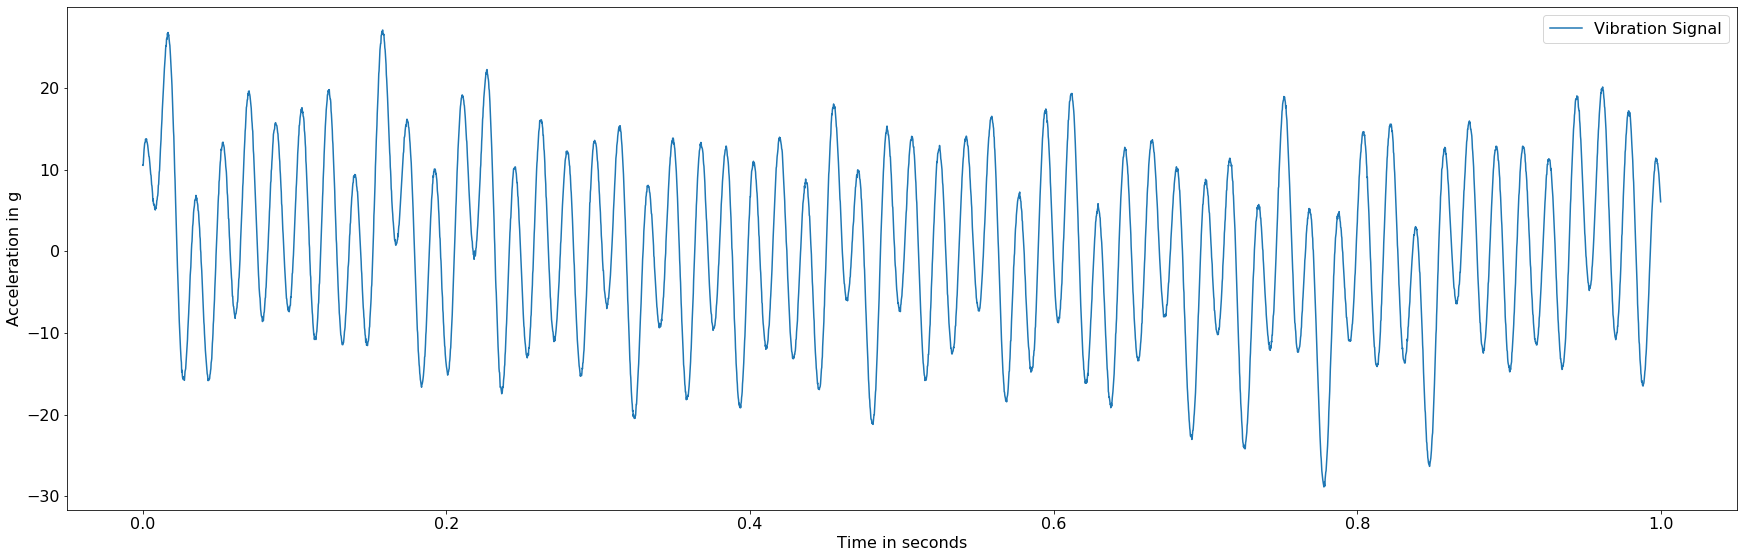

In [18]:
plt.plot(np.arange(0, sample_interval, 1/sample_rate), vibration)
plt.xlabel('Time in seconds'), plt.ylabel('Acceleration in g'), plt.legend(['Vibration Signal'])
plt.show()

<p>Summarize Vibration: <b>summary_vibration()</b></p>

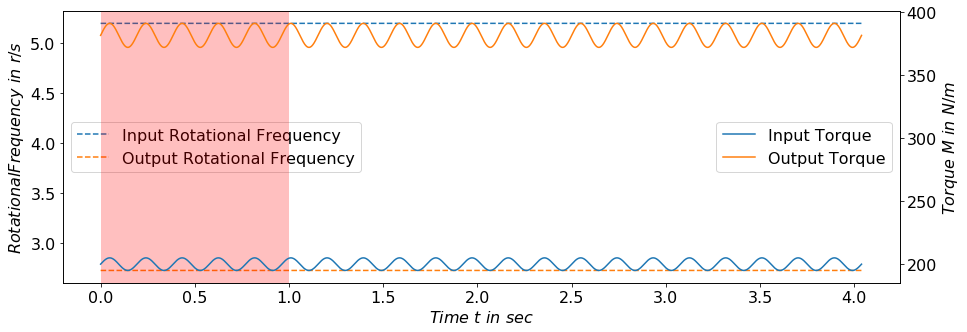

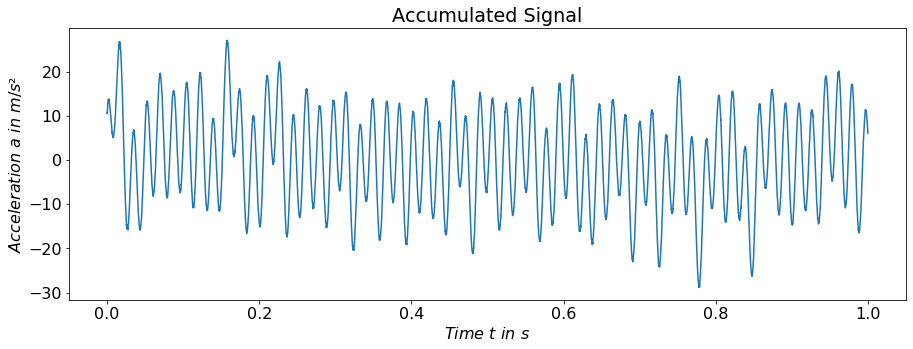

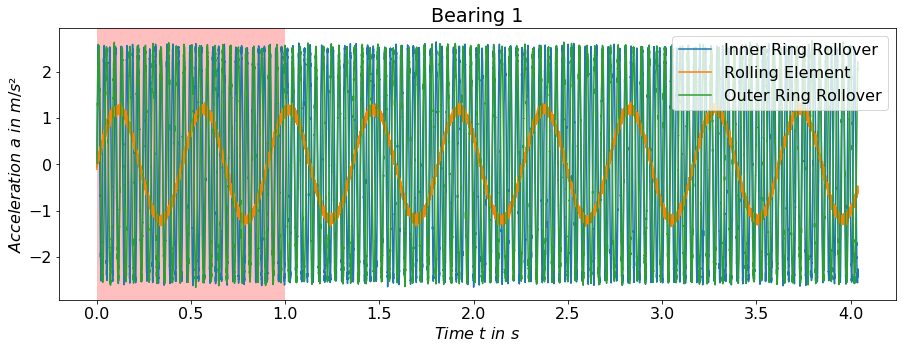

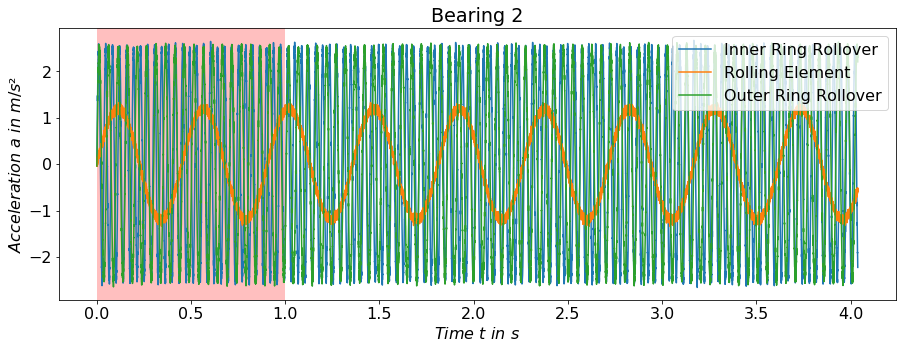

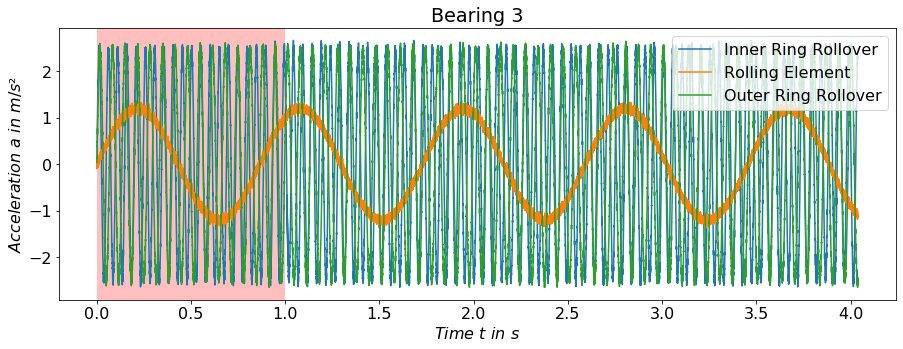

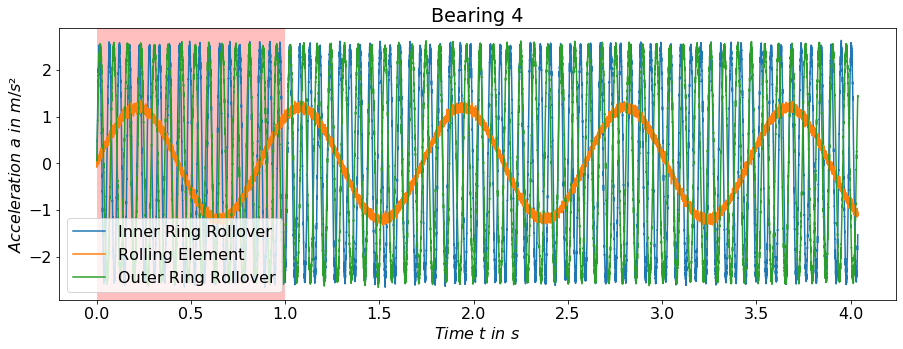

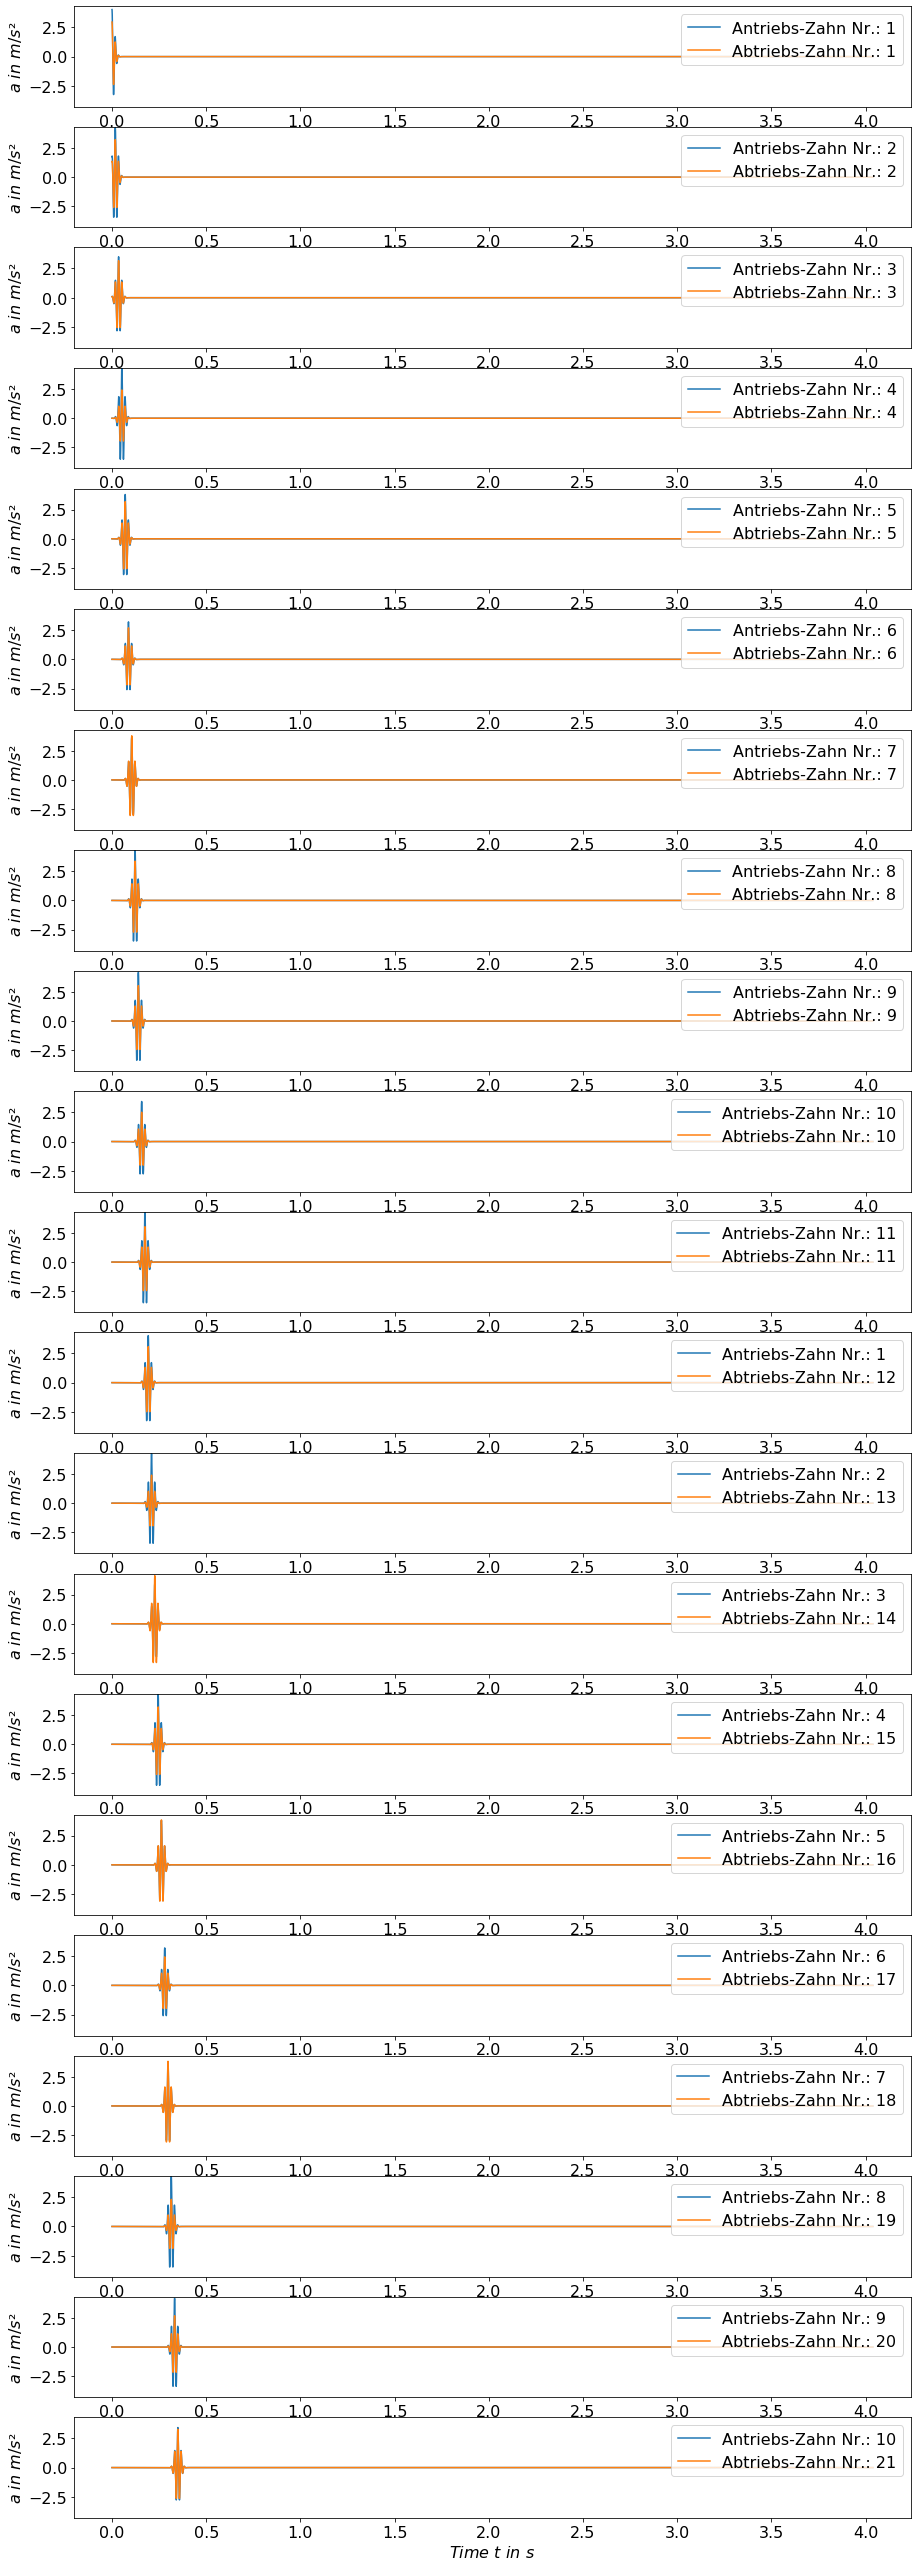

In [19]:
model.Vibration.summary_vibration()

<div style="background-color:rgb(0, 190, 255);color:black;padding:0.5em;letter-spacing:0.1em;font-size:1.5em;align=center">
<p><b>Run <u>only</u> Degradation</b></p>
</div>
<br>
<p>Initialize Degradation Module: <b>init_degradation()</b></p>
<p>Input Arguments:</p>
<p>Returns:</p>
<li>statei: DataFrame containing the degradation states</li>

In [20]:
statei = model.Degradation.init_degradation()


\\imapc\benutzer\Mitarbeiterdaten\henss\_02_software\_08_github\Gearbox\gearbox\degradation\helper\__init__.py:181: RuntimeWarning: invalid value encountered in log
  x = np.log((y - theta3) / theta1) / theta2


In [21]:
pd.DataFrame(statei['GearIn'])


1.0   2.0   3.0   4.0   5.0   6.0       7.0   8.0   9.0   10.0  11.0
$a_{0}$   NaN   NaN   NaN   NaN   NaN   NaN       NaN   NaN   NaN   NaN   NaN
$d_{0}$   NaN   NaN   NaN   NaN   NaN   NaN -1.434069   NaN   NaN   NaN   NaN

In [22]:
pd.DataFrame(statei['GearOut'])


1.0   2.0   3.0   4.0       5.0   6.0   7.0   8.0   9.0   10.0  ...  \
$a_{0}$   NaN   NaN   NaN   NaN       NaN   NaN   NaN   NaN   NaN   NaN  ...   
$d_{0}$   NaN   NaN   NaN   NaN -1.671099   NaN   NaN   NaN   NaN   NaN  ...   

             12.0  13.0      14.0  15.0  16.0  17.0  18.0  19.0  20.0  21.0  
$a_{0}$       NaN   NaN       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
$d_{0}$ -1.382792   NaN -0.391062   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[2 rows x 21 columns]

<p>Summarize Vibration: <b>summary_vibration()</b></p>

a0            n0  tooth          neol  aeol  theta1        theta2  \
0  0.661548  5.161122e+06      7  8.760057e+06   4.0  0.0501  5.000000e-07   
1  0.100020           NaN      3  1.175231e+07   4.0  0.0101  5.000000e-07   

         theta3        n0_old      neol_old  
0  1.776357e-15  5.656872e+06  8.721440e+06  
1  4.000000e-01  5.839910e+06  1.112036e+07

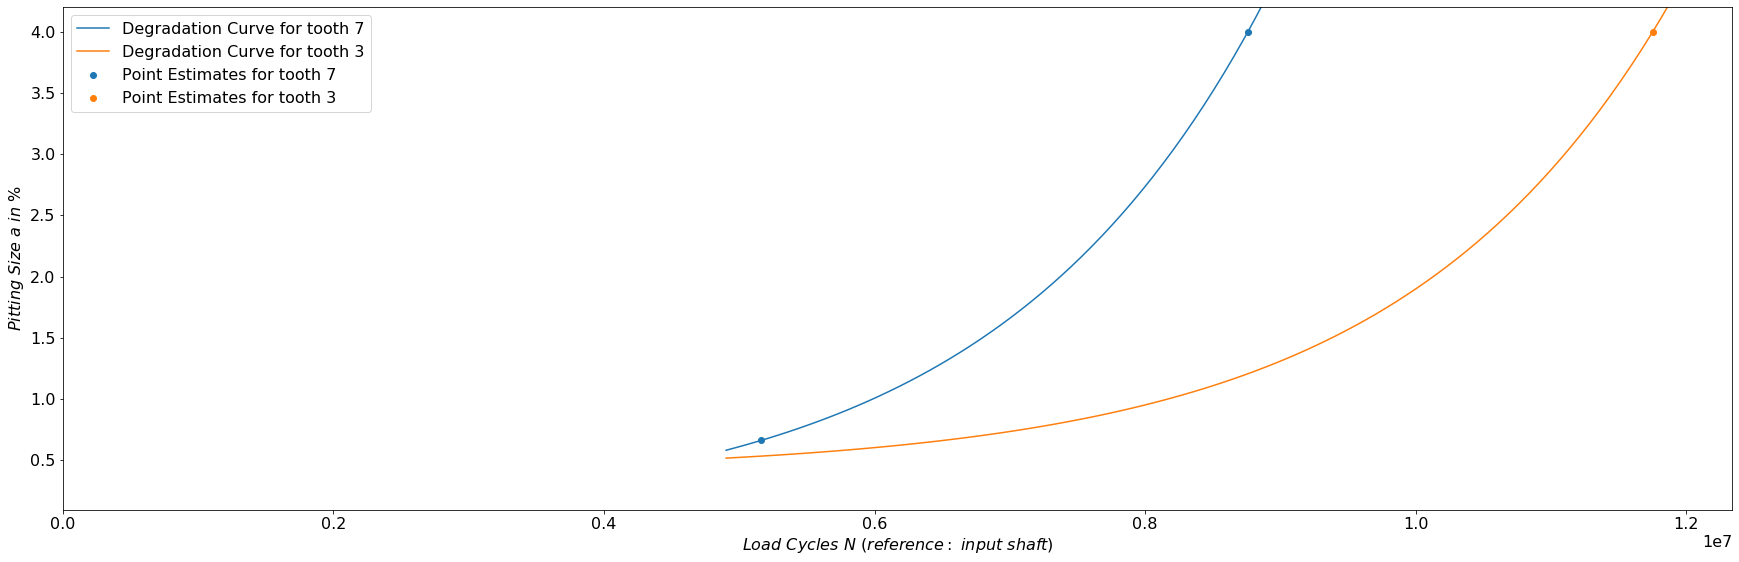

0
0 -1.434069
1       NaN

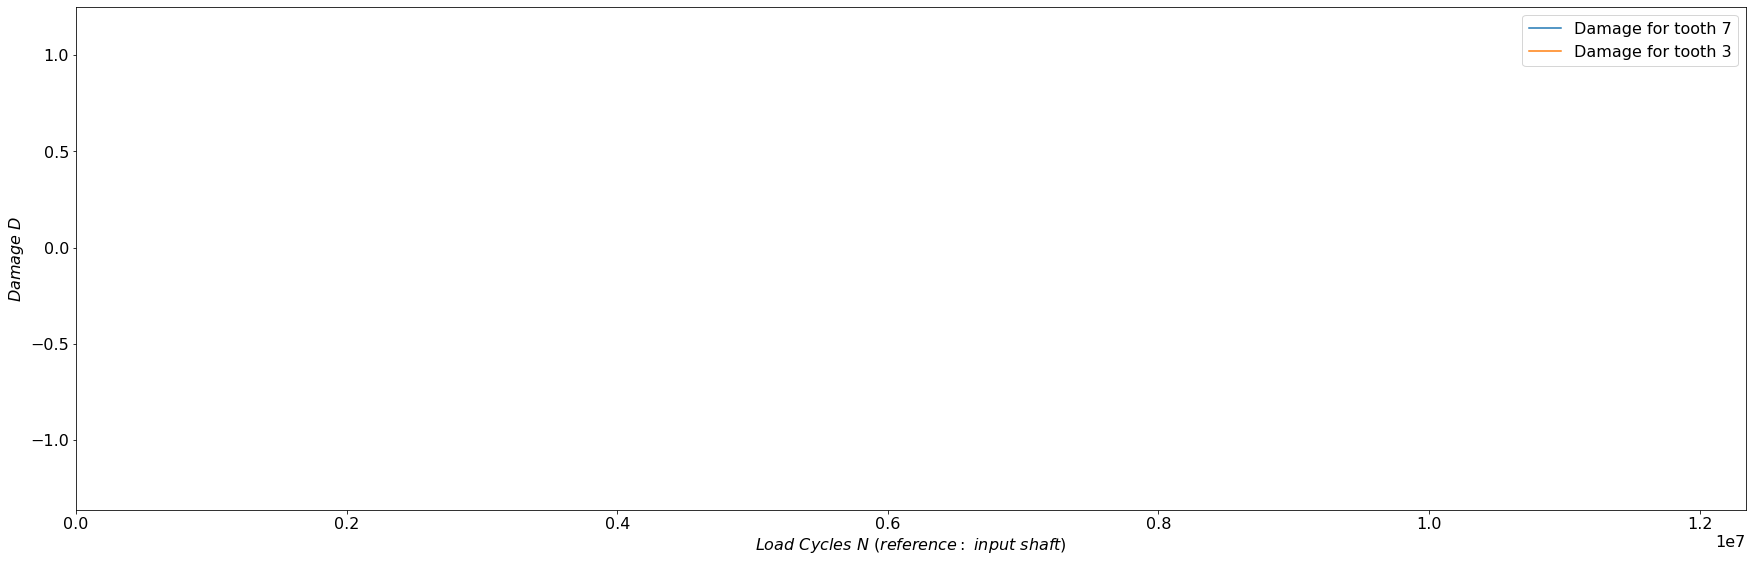

0
0 NaN
1 NaN

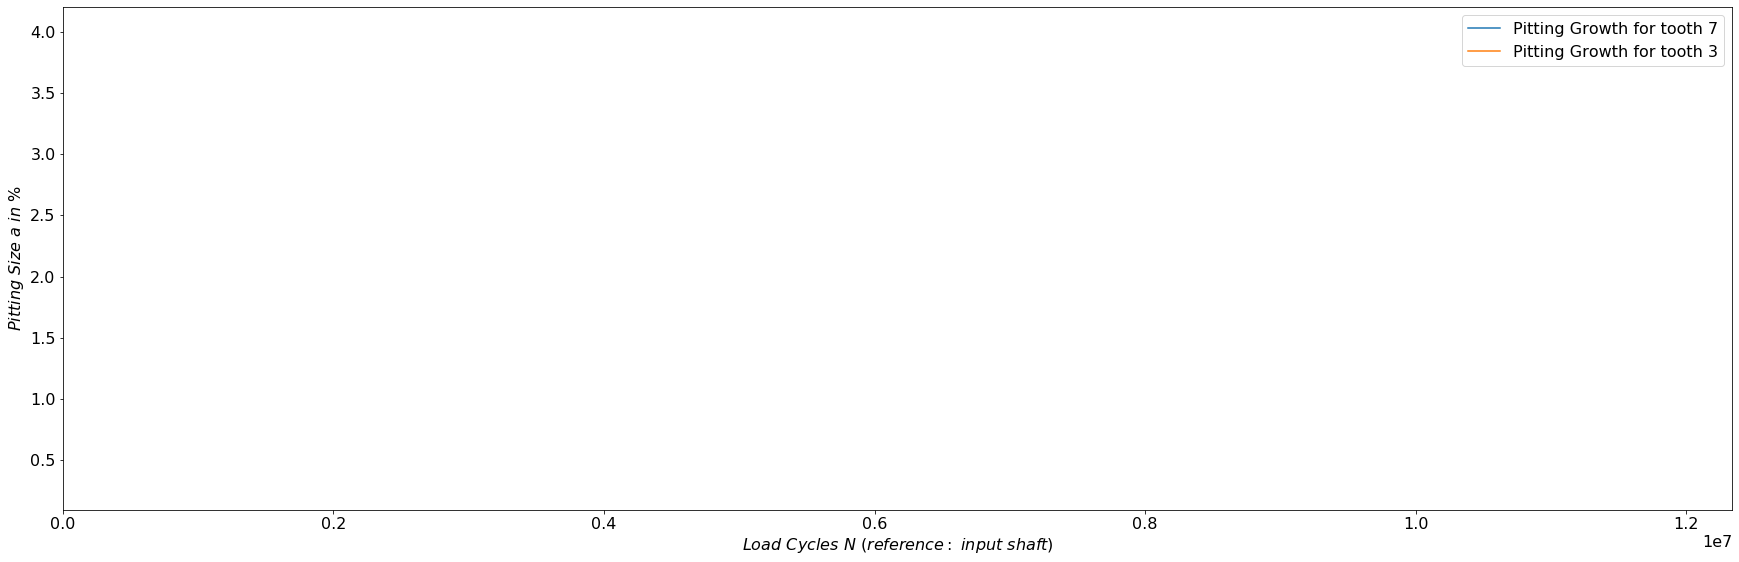

a0            n0  tooth          neol  aeol  theta1        theta2  \
0  0.579647  5.342086e+06     12  9.205347e+06   4.0  0.0401  5.000000e-07   
1  0.551336  6.623250e+06      5  1.058666e+07   4.0  0.0201  5.000000e-07   
2  0.146248  2.587852e+06     14  9.205347e+06   4.0  0.0401  5.000000e-07   

         theta3        n0_old      neol_old  
0  1.776357e-15  4.391948e+06  9.341308e+06  
1  1.776357e-15  5.441903e+06  1.073986e+07  
2  1.776357e-15  5.601978e+06  9.354910e+06

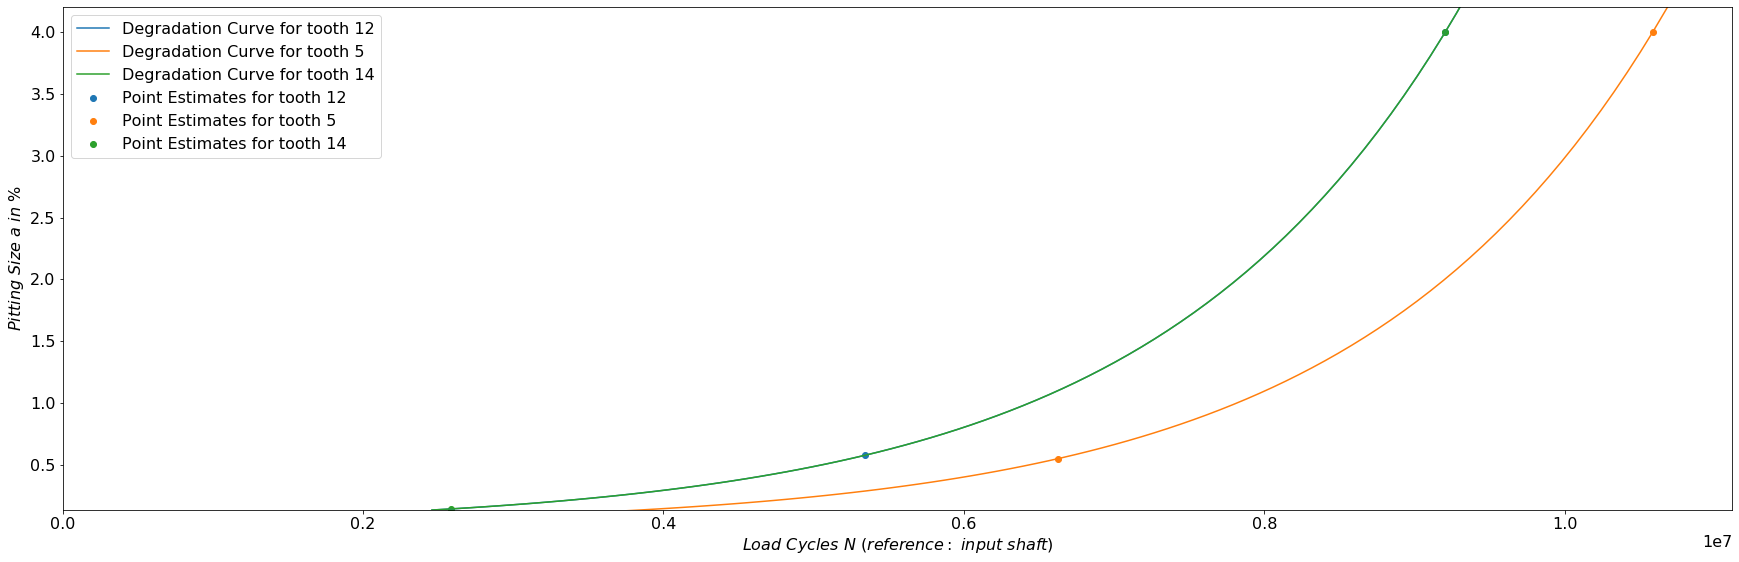

0
0 -1.382792
1 -1.671099
2 -0.391062

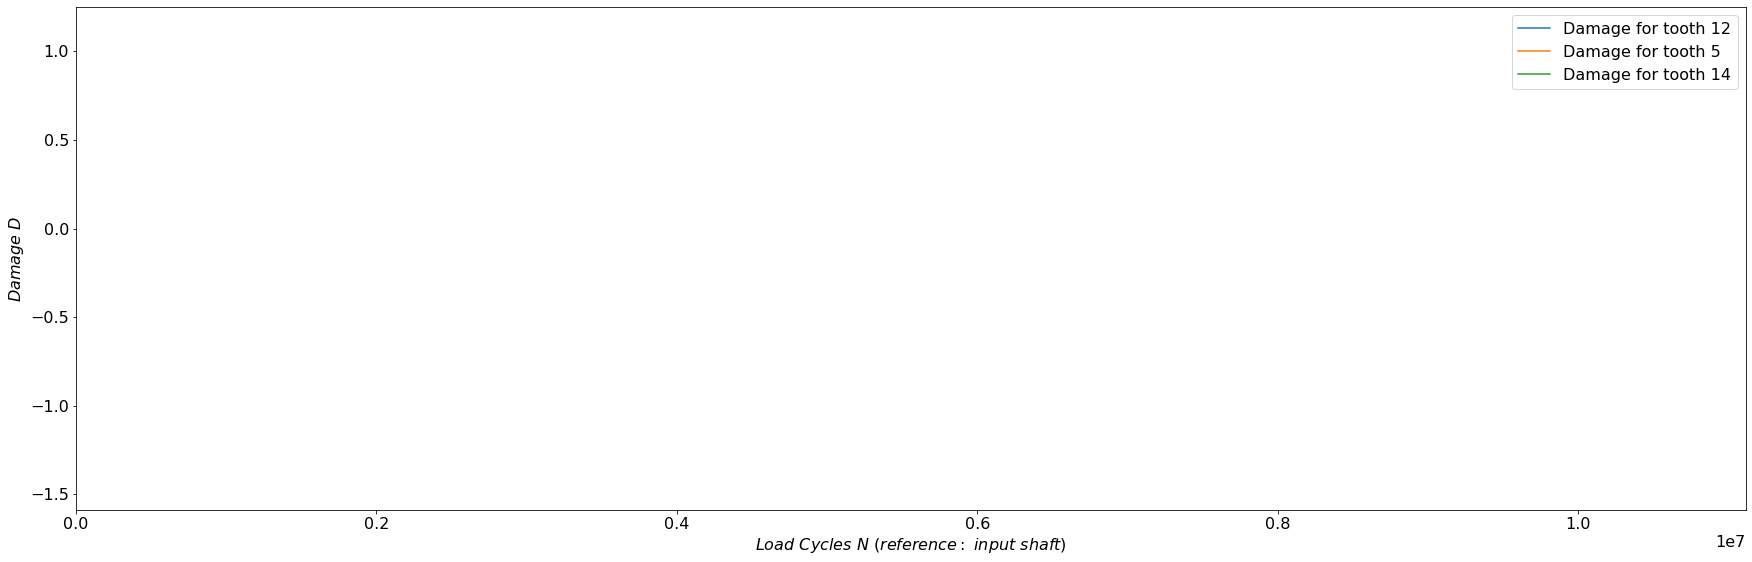

0
0 NaN
1 NaN
2 NaN

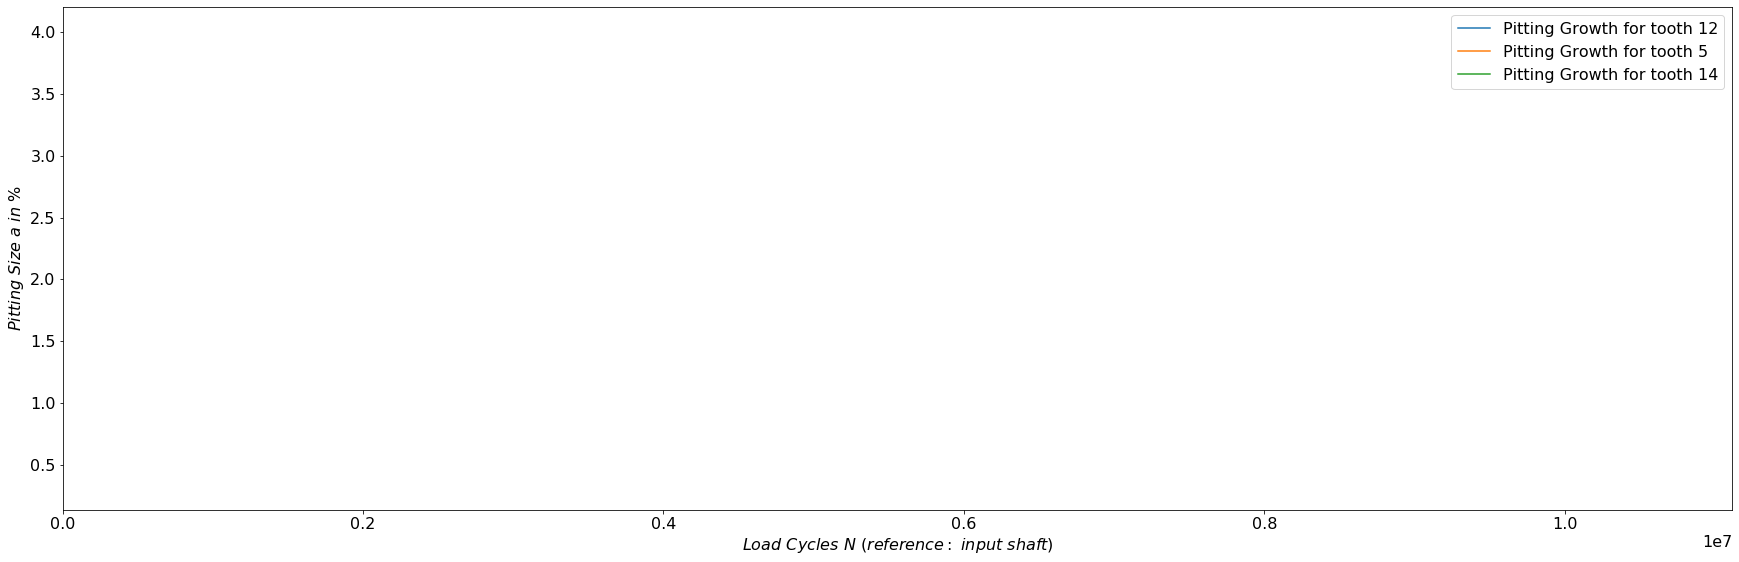

In [23]:
model.Degradation.summary_degradation()

<p>Get Degradation Growth: <b>run_degradation(nolc, loads)</b></p>
<p>Input Arguments:</p>
<li>nolc: current number of load cycle (must be greater than the previous given nolc)</li>
<li>loads: Dictionary regarding get_loads(torque) return</li>
<p>Returns:</p>
<li>statei </li>

In [25]:
loads = {'GearIn': {'7': [200], '3': [200]},
         'GearOut': {'12': [200], '5': [200], '14': [200]}}

for nolc in np.linspace(1e6, 6e6, 50):
    statei = model.Degradation.run_degradation(nolc, loads)
    

In [26]:
pd.DataFrame(statei['GearIn'])


1.0   2.0   3.0   4.0   5.0   6.0       7.0   8.0   9.0   10.0  \
$a_{6000000}$   NaN   NaN   NaN   NaN   NaN   NaN  1.006265   NaN   NaN   NaN   
$d_{6000000}$   NaN   NaN   NaN   NaN   NaN   NaN  0.233080   NaN   NaN   NaN   

               11.0  
$a_{6000000}$   NaN  
$d_{6000000}$   NaN

In [27]:
pd.DataFrame(statei['GearOut'])


1.0   2.0   3.0   4.0       5.0   6.0   7.0   8.0   9.0   10.0  \
$a_{6000000}$   NaN   NaN   NaN   NaN       NaN   NaN   NaN   NaN   NaN   NaN   
$d_{6000000}$   NaN   NaN   NaN   NaN -0.878143   NaN   NaN   NaN   NaN   NaN   

               ...     12.0  13.0      14.0  15.0  16.0  17.0  18.0  19.0  \
$a_{6000000}$  ...      NaN   NaN  0.193018   NaN   NaN   NaN   NaN   NaN   
$d_{6000000}$  ... -0.56928   NaN  0.083862   NaN   NaN   NaN   NaN   NaN   

               20.0  21.0  
$a_{6000000}$   NaN   NaN  
$d_{6000000}$   NaN   NaN  

[2 rows x 21 columns]

a0            n0  tooth          neol  aeol  theta1        theta2  \
0  0.661548  5.161122e+06      7  8.760057e+06   4.0  0.0501  5.000000e-07   
1  0.100020           NaN      3  1.175231e+07   4.0  0.0101  5.000000e-07   

         theta3        n0_old      neol_old  
0  1.776357e-15  5.656872e+06  8.721440e+06  
1  4.000000e-01  5.839910e+06  1.112036e+07

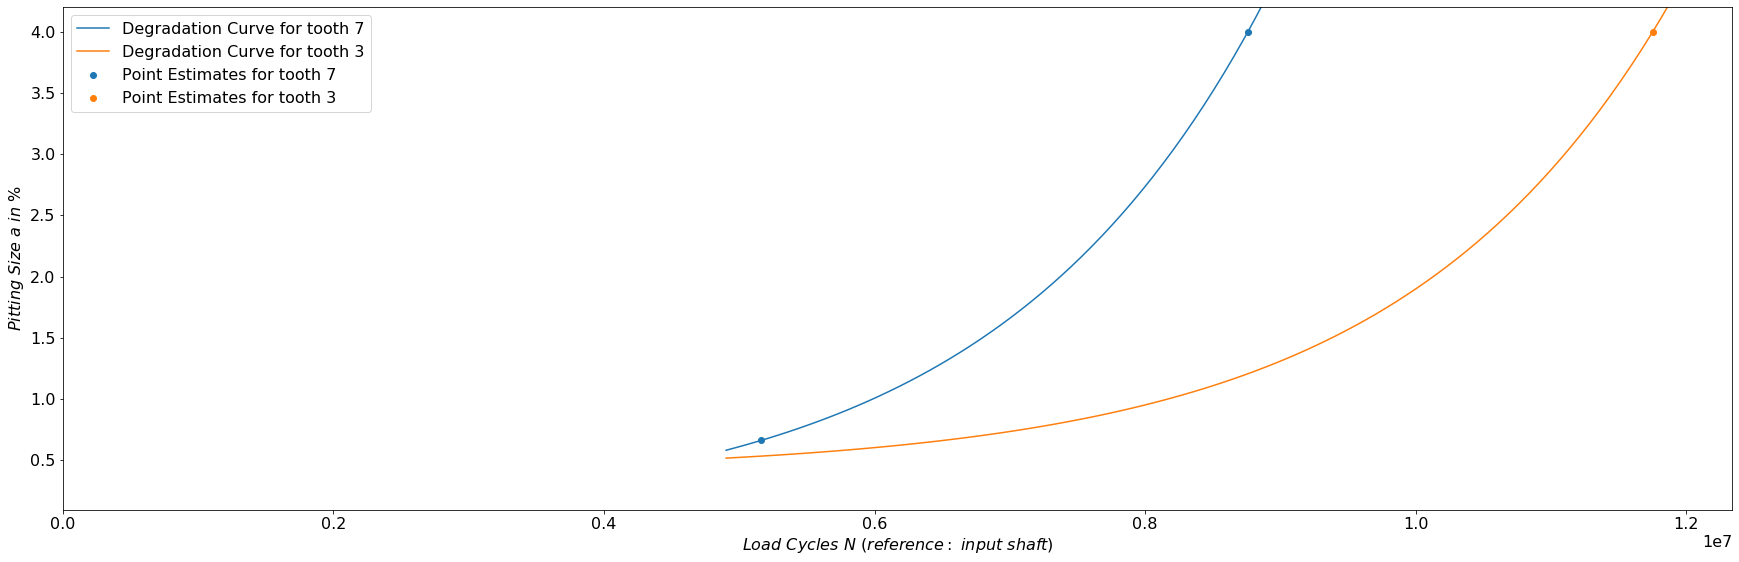

0.000000e+00  1.000000e+06  1.102041e+06  1.204082e+06  1.306122e+06  \
0     -1.434069     -1.156209     -1.127856     -1.099503     -1.071151   
1           NaN           NaN           NaN           NaN           NaN   

   1.408163e+06  1.510204e+06  1.612245e+06  1.714286e+06  1.816327e+06  ...  \
0     -1.042798     -1.014445     -0.986092     -0.957739     -0.929386  ...   
1           NaN           NaN           NaN           NaN           NaN  ...   

   5.081633e+06  5.183673e+06  5.285714e+06  5.387755e+06  5.489796e+06  \
0     -0.022096      0.006257       0.03461      0.062963      0.091315   
1           NaN           NaN           NaN           NaN           NaN   

   5.591837e+06  5.693878e+06  5.795918e+06  5.897959e+06  6.000000e+06  
0      0.119668      0.148021      0.176374      0.204727       0.23308  
1           NaN           NaN           NaN           NaN           NaN  

[2 rows x 51 columns]

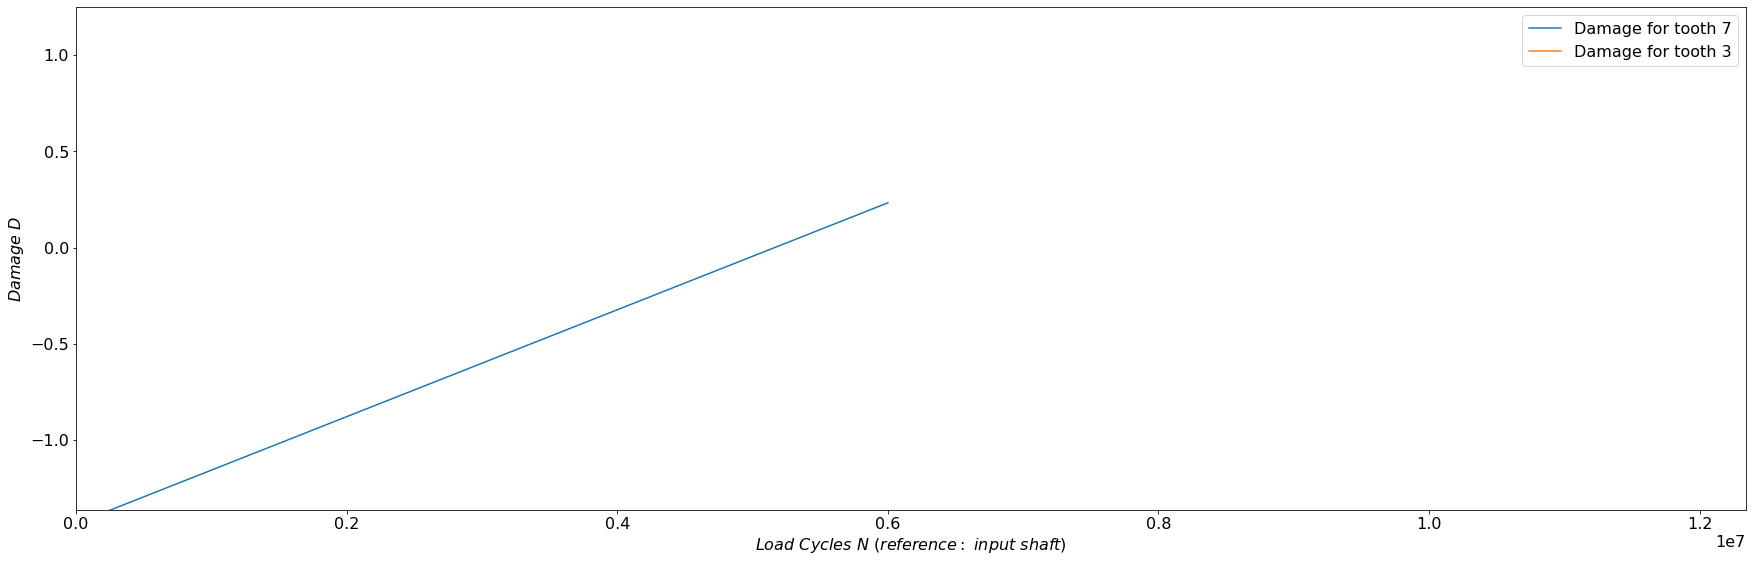

0.000000e+00  1.000000e+06  1.102041e+06  1.204082e+06  1.306122e+06  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   1.408163e+06  1.510204e+06  1.612245e+06  1.714286e+06  1.816327e+06  ...  \
0           NaN           NaN           NaN           NaN           NaN  ...   
1           NaN           NaN           NaN           NaN           NaN  ...   

   5.081633e+06  5.183673e+06  5.285714e+06  5.387755e+06  5.489796e+06  \
0           NaN      0.669038      0.704058      0.740911      0.779694   
1           NaN           NaN           NaN           NaN           NaN   

   5.591837e+06  5.693878e+06  5.795918e+06  5.897959e+06  6.000000e+06  
0      0.820506      0.863454      0.908651      0.956213      1.006265  
1           NaN           NaN           NaN           NaN           NaN  

[2 rows x 51 columns]

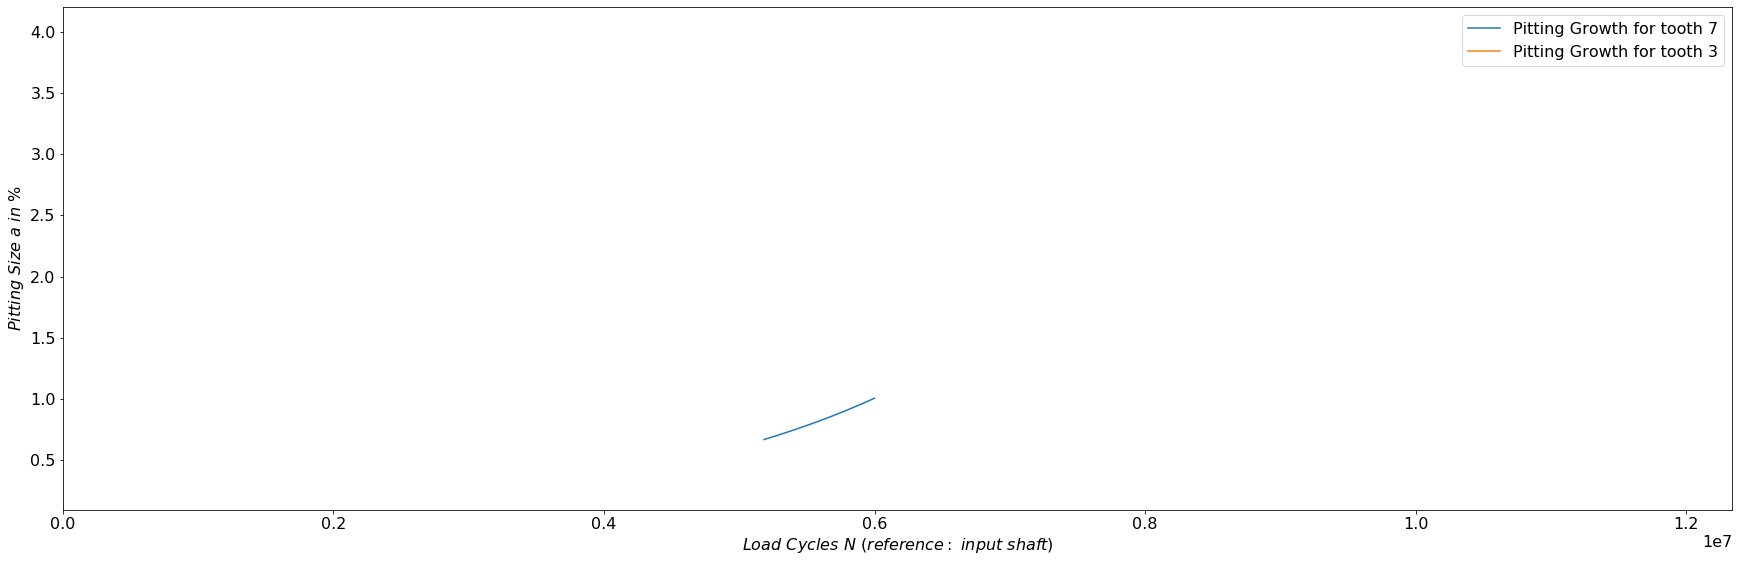

a0            n0  tooth          neol  aeol  theta1        theta2  \
0  0.579647  5.342086e+06     12  9.205347e+06   4.0  0.0401  5.000000e-07   
1  0.551336  6.623250e+06      5  1.058666e+07   4.0  0.0201  5.000000e-07   
2  0.146248  2.587852e+06     14  9.205347e+06   4.0  0.0401  5.000000e-07   

         theta3        n0_old      neol_old  
0  1.776357e-15  4.391948e+06  9.341308e+06  
1  1.776357e-15  5.441903e+06  1.073986e+07  
2  1.776357e-15  5.601978e+06  9.354910e+06

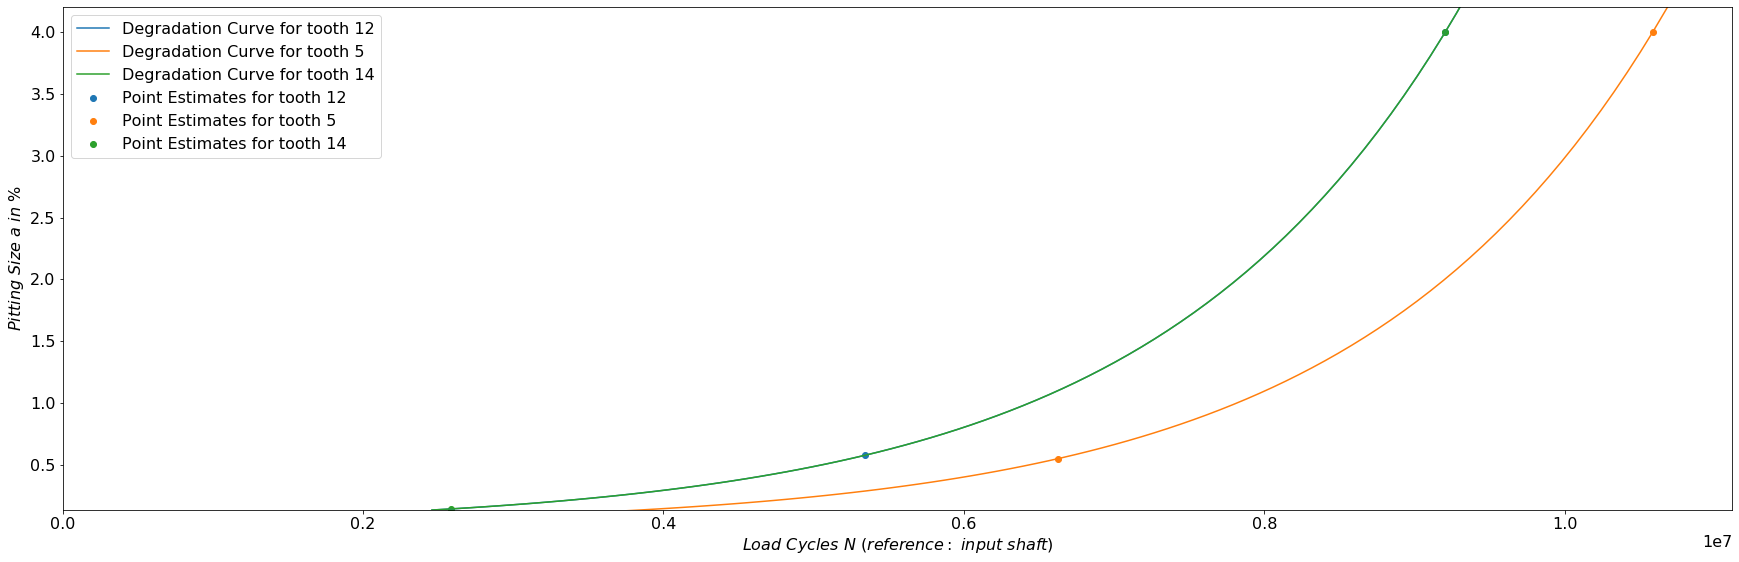

0.000000e+00  1.000000e+06  1.102041e+06  1.204082e+06  1.306122e+06  \
0     -1.382792     -1.247205     -1.233370     -1.219534     -1.205699   
1     -1.671099     -1.538938     -1.525452     -1.511967     -1.498481   
2     -0.391062     -0.311907     -0.303830     -0.295753     -0.287676   

   1.408163e+06  1.510204e+06  1.612245e+06  1.714286e+06  1.816327e+06  ...  \
0     -1.191864     -1.178029     -1.164194     -1.150358     -1.136523  ...   
1     -1.484995     -1.471510     -1.458024     -1.444539     -1.431053  ...   
2     -0.279599     -0.271522     -0.263445     -0.255369     -0.247292  ...   

   5.081633e+06  5.183673e+06  5.285714e+06  5.387755e+06  5.489796e+06  \
0     -0.693797     -0.679961     -0.666126     -0.652291     -0.638456   
1     -0.999513     -0.986028     -0.972542     -0.959057     -0.945571   
2      0.011170      0.019247      0.027324      0.035401      0.043478   

   5.591837e+06  5.693878e+06  5.795918e+06  5.897959e+06  6.000000e+06  
0     -0.624621     -0.610785     -0.596950     -0.583115     -0.569280  
1     -0.932085     -0.918600     -0.905114     -0.891629     -0.878143  
2      0.051555      0.059631      0.067708      0.075785      0.083862  

[3 rows x 51 columns]

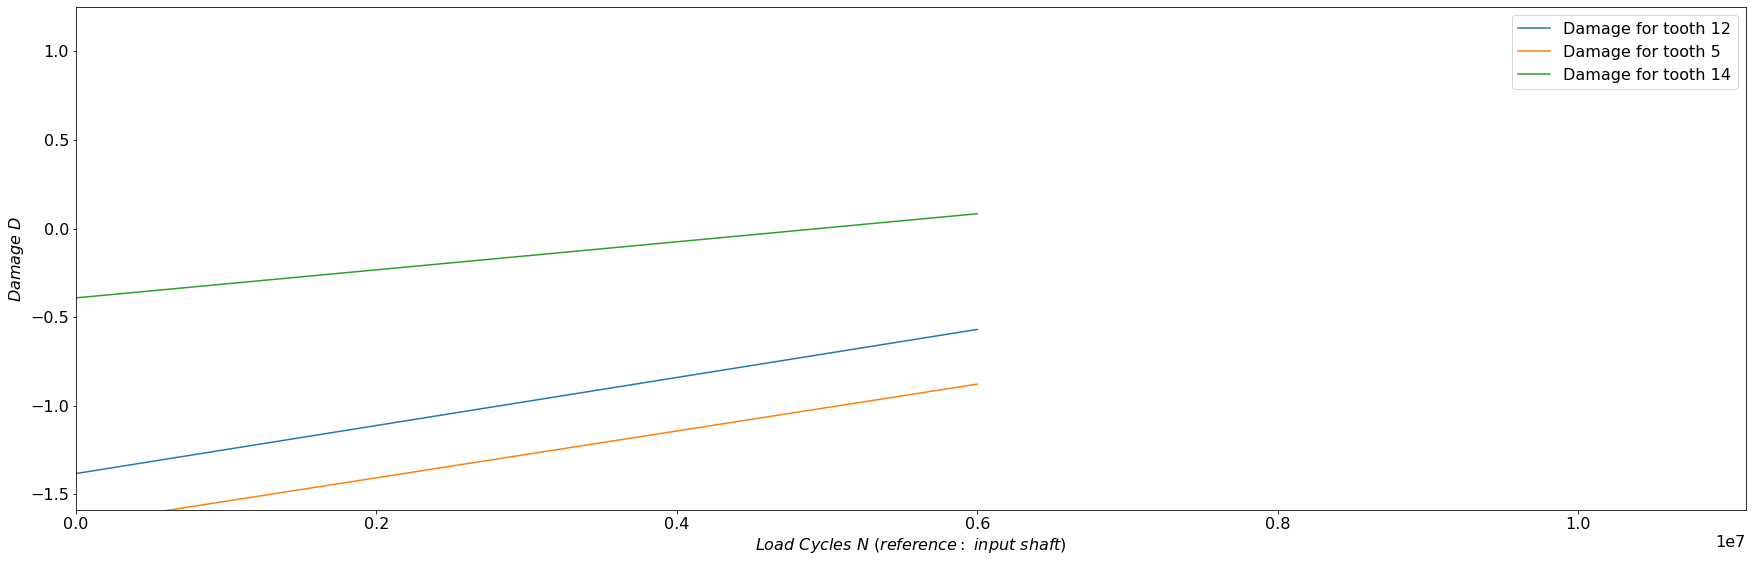

0.000000e+00  1.000000e+06  1.102041e+06  1.204082e+06  1.306122e+06  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   1.408163e+06  1.510204e+06  1.612245e+06  1.714286e+06  1.816327e+06  ...  \
0           NaN           NaN           NaN           NaN           NaN  ...   
1           NaN           NaN           NaN           NaN           NaN  ...   
2           NaN           NaN           NaN           NaN           NaN  ...   

   5.081633e+06  5.183673e+06  5.285714e+06  5.387755e+06  5.489796e+06  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2      0.151754      0.155864      0.160086      0.164422      0.168875   

   5.591837e+06  5.693878e+06  5.795918e+06  5.897959e+06  6.000000e+06  
0           NaN           NaN           NaN           NaN           NaN  
1           NaN           NaN           NaN           NaN           NaN  
2      0.173449      0.178147      0.182972      0.187928      0.193018  

[3 rows x 51 columns]

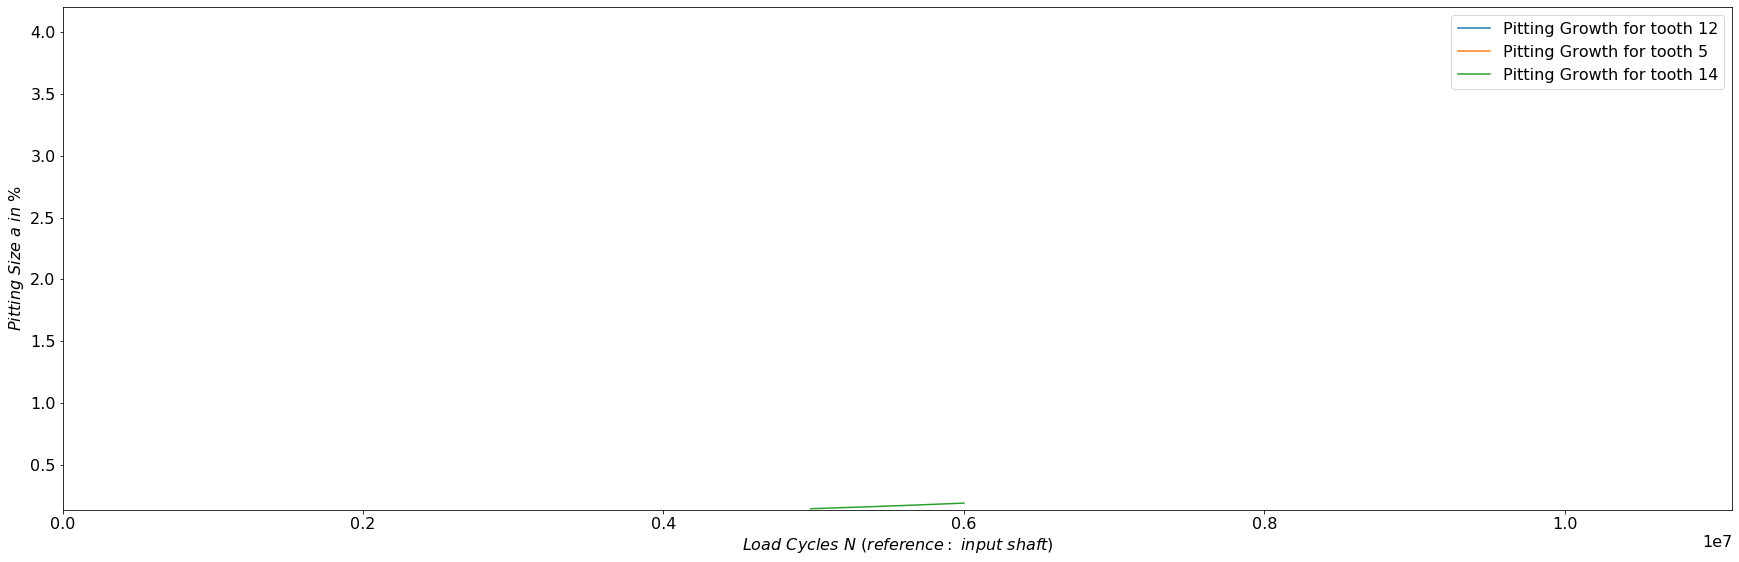

In [28]:
model.Degradation.summary_degradation()


In [29]:
loads = {'GearIn': {'7': [200], '3': [200]},
         'GearOut': {'12': [188], '5': [194], '14': [200]}}

for nolc in np.linspace(6.1e6, 10e6, 40):
    statei = model.Degradation.run_degradation(nolc, loads)
    

In [30]:
pd.DataFrame(statei['GearIn'])

1.0   2.0   3.0   4.0   5.0   6.0       7.0   8.0   9.0   \
$a_{10000000}$   NaN   NaN   NaN   NaN   NaN   NaN  7.435351   NaN   NaN   
$d_{10000000}$   NaN   NaN   NaN   NaN   NaN   NaN  1.344519   NaN   NaN   

                10.0  11.0  
$a_{10000000}$   NaN   NaN  
$d_{10000000}$   NaN   NaN

In [31]:
pd.DataFrame(statei['GearOut'])

1.0   2.0   3.0   4.0       5.0   6.0   7.0   8.0   9.0   \
$a_{10000000}$   NaN   NaN   NaN   NaN       NaN   NaN   NaN   NaN   NaN   
$d_{10000000}$   NaN   NaN   NaN   NaN -0.494206   NaN   NaN   NaN   NaN   

                10.0  ...      12.0  13.0      14.0  15.0  16.0  17.0  18.0  \
$a_{10000000}$   NaN  ...       NaN   NaN  0.550255   NaN   NaN   NaN   NaN   
$d_{10000000}$   NaN  ... -0.286066   NaN  0.400478   NaN   NaN   NaN   NaN   

                19.0  20.0  21.0  
$a_{10000000}$   NaN   NaN   NaN  
$d_{10000000}$   NaN   NaN   NaN  

[2 rows x 21 columns]

a0            n0  tooth          neol  aeol  theta1        theta2  \
0  0.661548  5.161122e+06      7  8.760057e+06   4.0  0.0501  5.000000e-07   
1  0.100020           NaN      3  1.175231e+07   4.0  0.0101  5.000000e-07   

         theta3        n0_old      neol_old  
0  1.776357e-15  5.656872e+06  8.721440e+06  
1  4.000000e-01  5.839910e+06  1.112036e+07

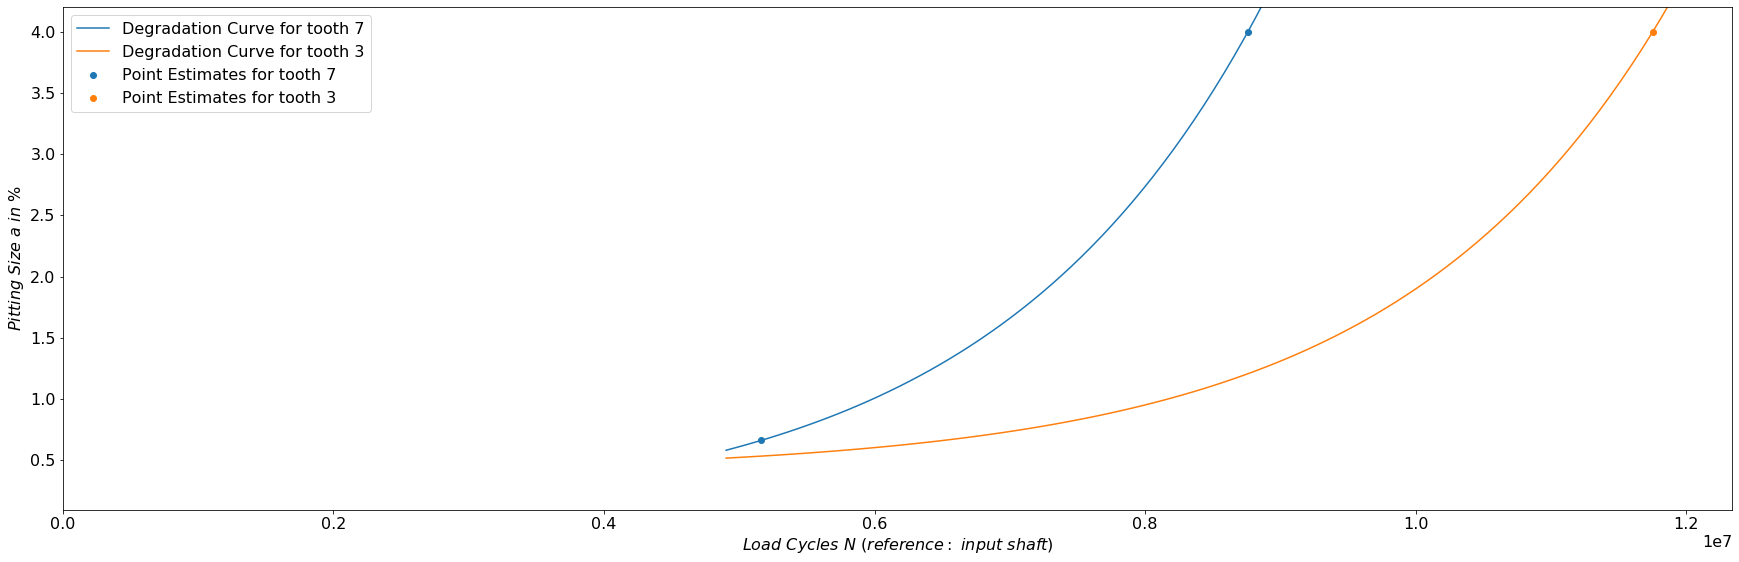

0.000000e+00  1.000000e+06  1.102041e+06  1.204082e+06  1.306122e+06  \
0     -1.434069     -1.156209     -1.127856     -1.099503     -1.071151   
1           NaN           NaN           NaN           NaN           NaN   

   1.408163e+06  1.510204e+06  1.612245e+06  1.714286e+06  1.816327e+06  ...  \
0     -1.042798     -1.014445     -0.986092     -0.957739     -0.929386  ...   
1           NaN           NaN           NaN           NaN           NaN  ...   

   9.100000e+06  9.200000e+06  9.300000e+06  9.400000e+06  9.500000e+06  \
0      1.094445      1.122231      1.150017      1.177803      1.205589   
1           NaN           NaN           NaN           NaN           NaN   

   9.600000e+06  9.700000e+06  9.800000e+06  9.900000e+06  1.000000e+07  
0      1.233375      1.261161      1.288947      1.316733      1.344519  
1           NaN           NaN           NaN           NaN           NaN  

[2 rows x 91 columns]

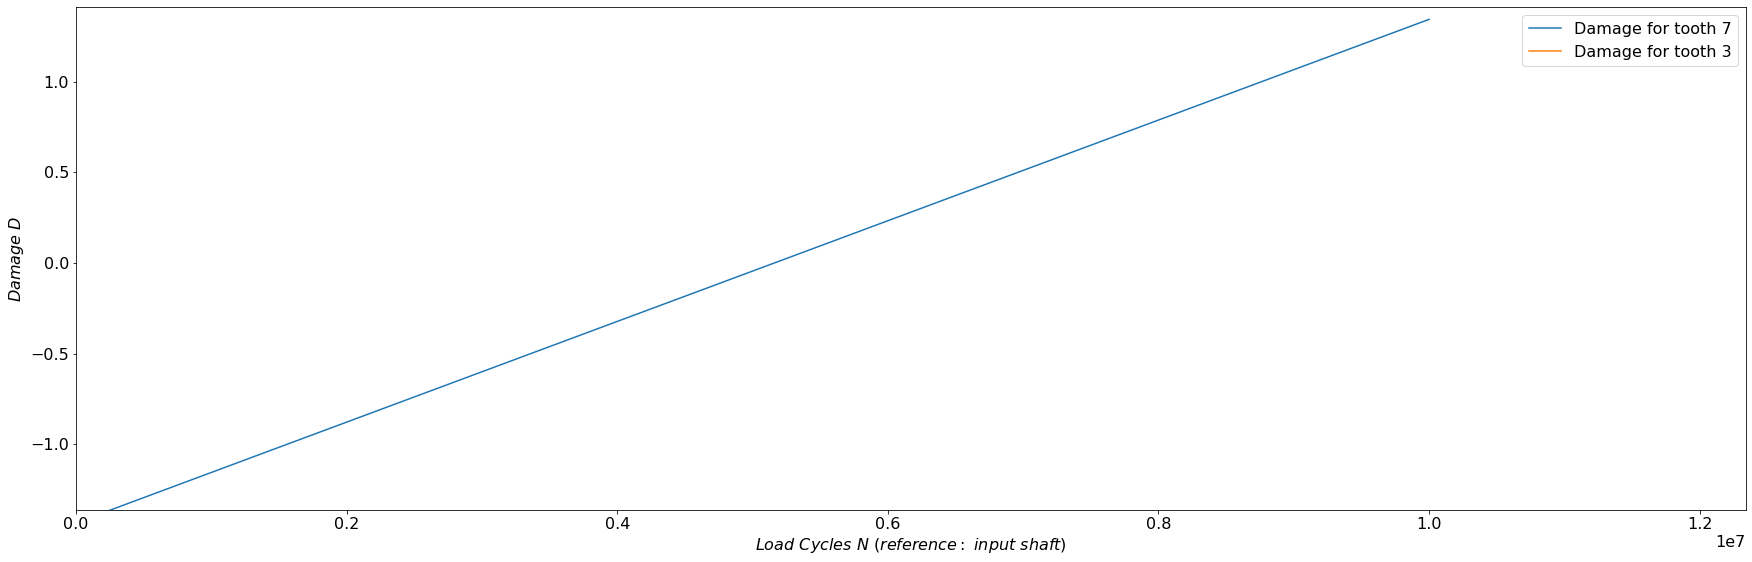

0.000000e+00  1.000000e+06  1.102041e+06  1.204082e+06  1.306122e+06  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   

   1.408163e+06  1.510204e+06  1.612245e+06  1.714286e+06  1.816327e+06  ...  \
0           NaN           NaN           NaN           NaN           NaN  ...   
1           NaN           NaN           NaN           NaN           NaN  ...   

   9.100000e+06  9.200000e+06  9.300000e+06  9.400000e+06  9.500000e+06  \
0      4.740989      4.984065      5.239603      5.508243      5.790657   
1           NaN           NaN           NaN           NaN           NaN   

   9.600000e+06  9.700000e+06  9.800000e+06  9.900000e+06  1.000000e+07  
0       6.08755      6.399666      6.727783      7.072724      7.435351  
1           NaN           NaN           NaN           NaN           NaN  

[2 rows x 91 columns]

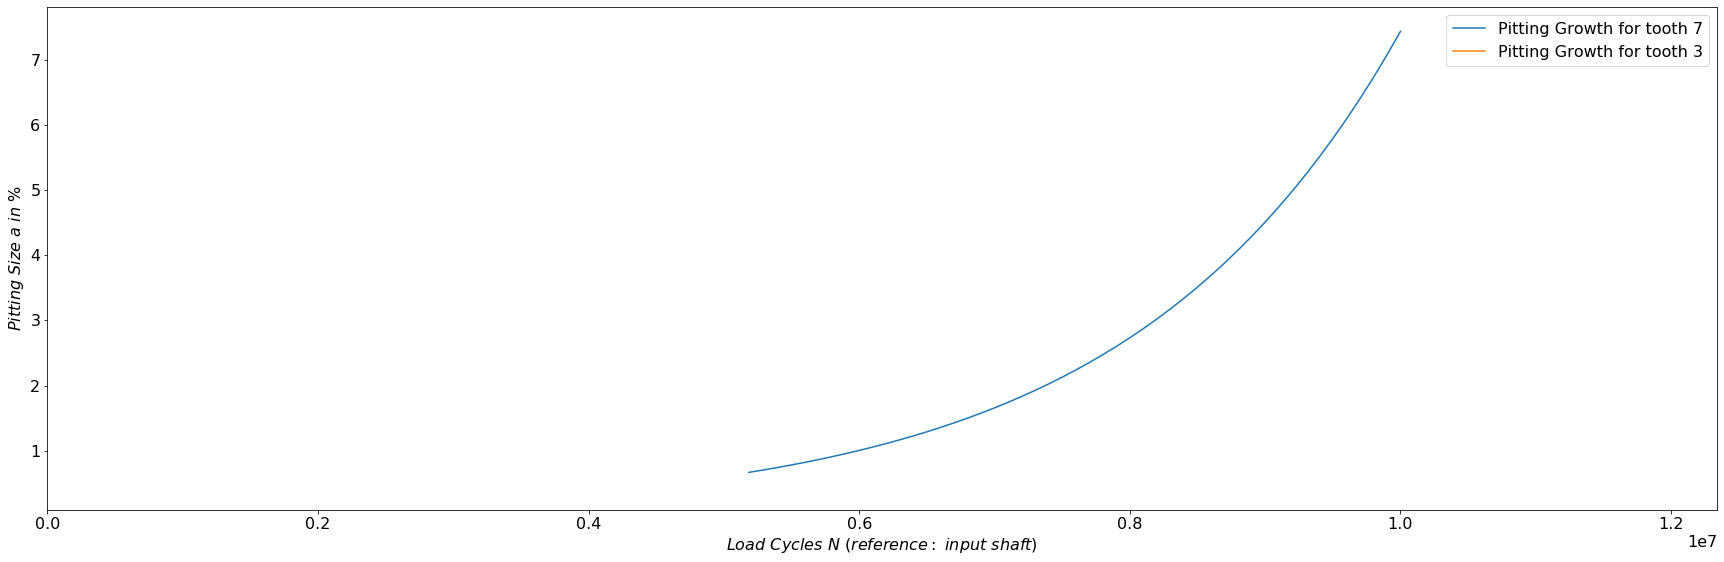

a0            n0  tooth          neol  aeol  theta1        theta2  \
0  0.579647  5.342086e+06     12  9.205347e+06   4.0  0.0401  5.000000e-07   
1  0.551336  6.623250e+06      5  1.058666e+07   4.0  0.0201  5.000000e-07   
2  0.146248  2.587852e+06     14  9.205347e+06   4.0  0.0401  5.000000e-07   

         theta3        n0_old      neol_old  
0  1.776357e-15  4.391948e+06  9.341308e+06  
1  1.776357e-15  5.441903e+06  1.073986e+07  
2  1.776357e-15  5.601978e+06  9.354910e+06

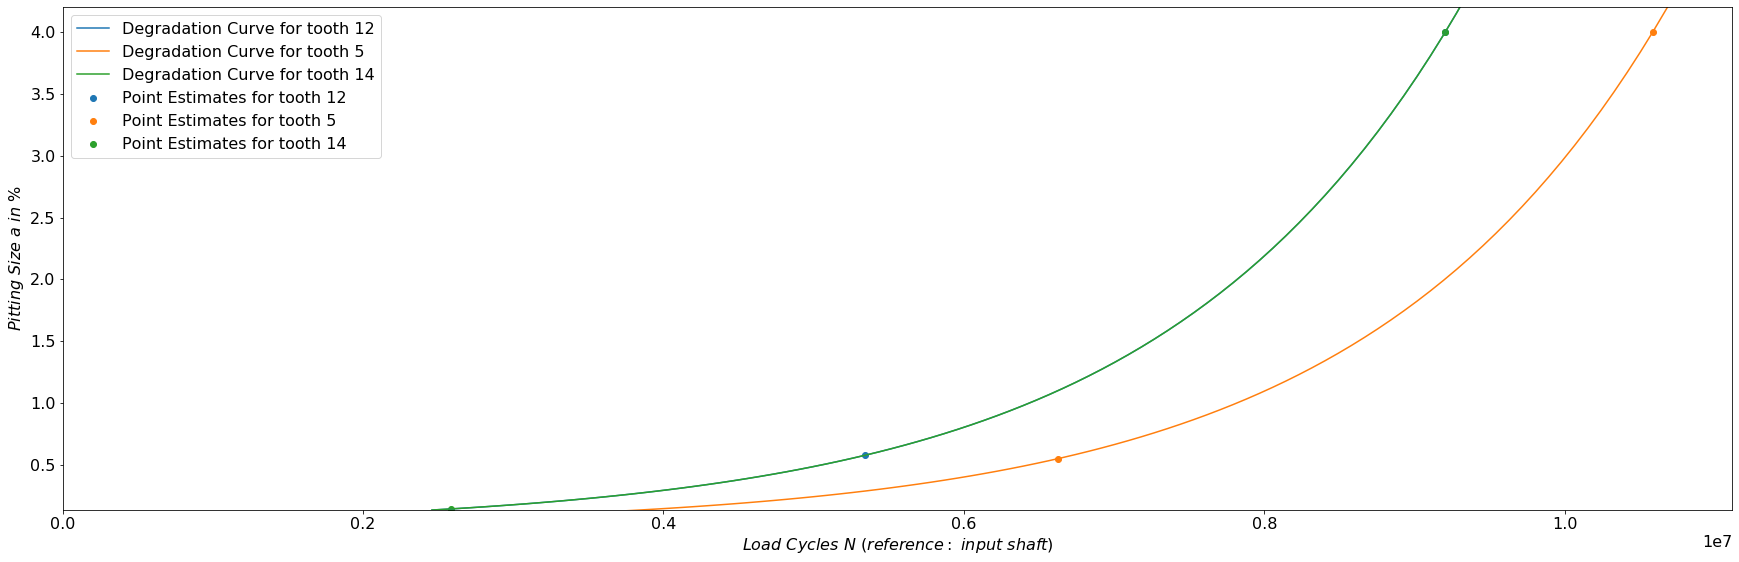

0.000000e+00  1.000000e+06  1.102041e+06  1.204082e+06  1.306122e+06  \
0     -1.382792     -1.247205     -1.233370     -1.219534     -1.205699   
1     -1.671099     -1.538938     -1.525452     -1.511967     -1.498481   
2     -0.391062     -0.311907     -0.303830     -0.295753     -0.287676   

   1.408163e+06  1.510204e+06  1.612245e+06  1.714286e+06  1.816327e+06  ...  \
0     -1.191864     -1.178029     -1.164194     -1.150358     -1.136523  ...   
1     -1.484995     -1.471510     -1.458024     -1.444539     -1.431053  ...   
2     -0.279599     -0.271522     -0.263445     -0.255369     -0.247292  ...   

   9.100000e+06  9.200000e+06  9.300000e+06  9.400000e+06  9.500000e+06  \
0     -0.349789     -0.342709     -0.335629     -0.328548     -0.321468   
1     -0.580592     -0.570994     -0.561395     -0.551797     -0.542198   
2      0.329239      0.337154      0.345070      0.352985      0.360901   

   9.600000e+06  9.700000e+06  9.800000e+06  9.900000e+06  1.000000e+07  
0     -0.314388     -0.307307     -0.300227     -0.293147     -0.286066  
1     -0.532600     -0.523001     -0.513403     -0.503805     -0.494206  
2      0.368816      0.376731      0.384647      0.392562      0.400478  

[3 rows x 91 columns]

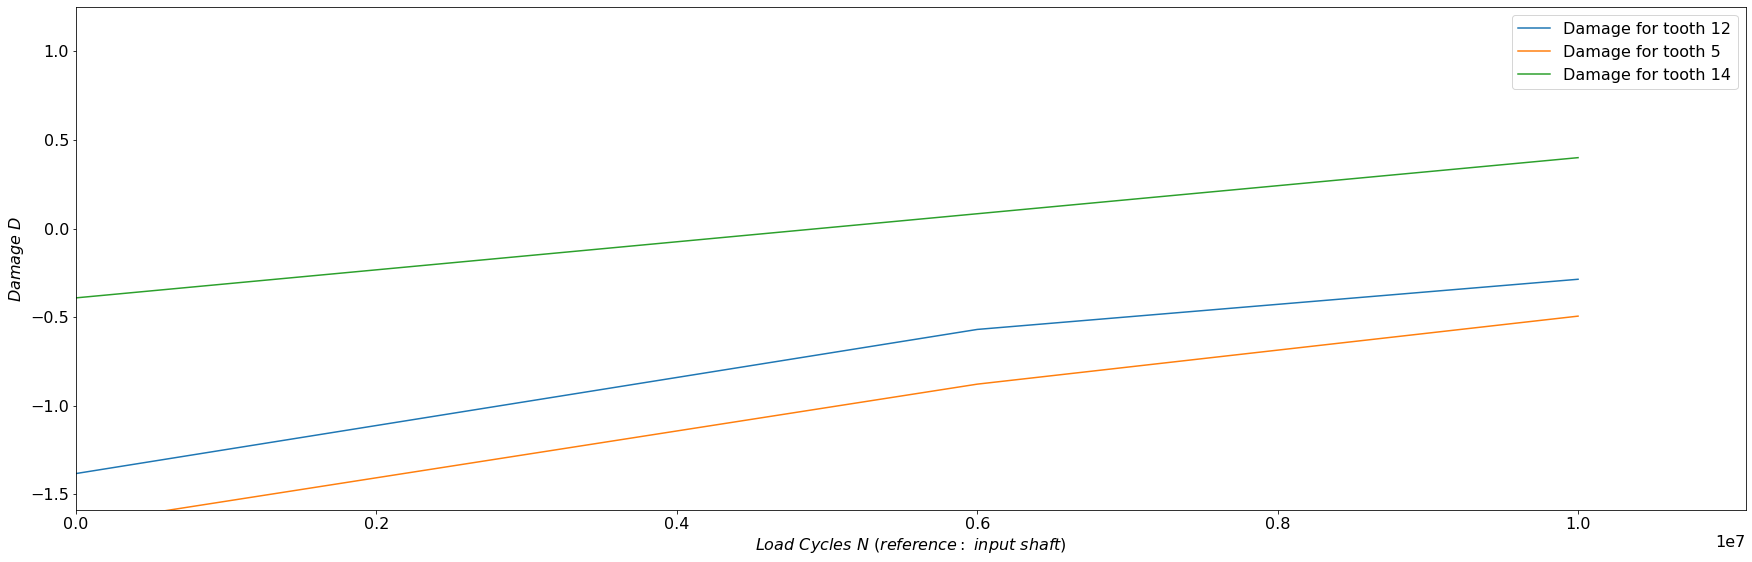

0.000000e+00  1.000000e+06  1.102041e+06  1.204082e+06  1.306122e+06  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN           NaN           NaN           NaN           NaN   

   1.408163e+06  1.510204e+06  1.612245e+06  1.714286e+06  1.816327e+06  ...  \
0           NaN           NaN           NaN           NaN           NaN  ...   
1           NaN           NaN           NaN           NaN           NaN  ...   
2           NaN           NaN           NaN           NaN           NaN  ...   

   9.100000e+06  9.200000e+06  9.300000e+06  9.400000e+06  9.500000e+06  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2      0.434707      0.446242      0.458083      0.470239      0.482717   

   9.600000e+06  9.700000e+06  9.800000e+06  9.900000e+06  1.000000e+07  
0           NaN           NaN           NaN           NaN           NaN  
1           NaN           NaN           NaN           NaN           NaN  
2      0.495527      0.508676      0.522174      0.536031      0.550255  

[3 rows x 91 columns]

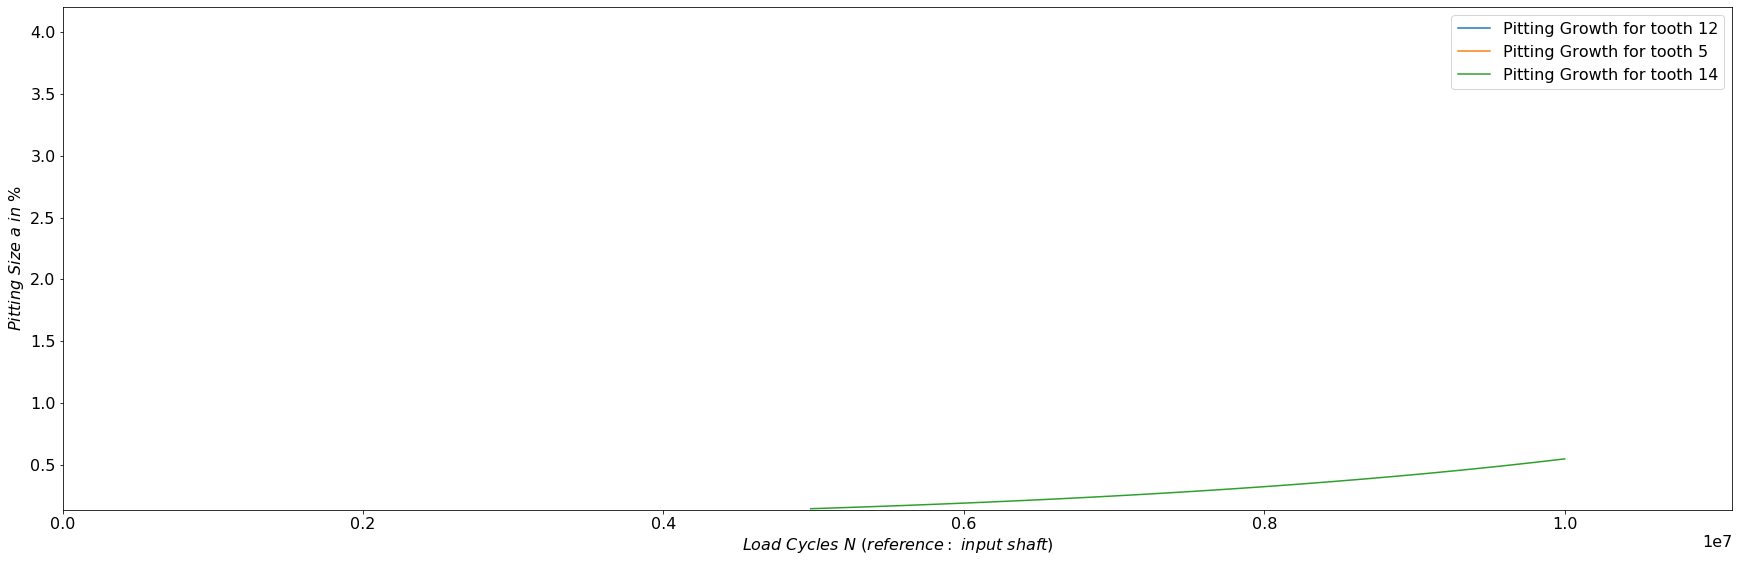

In [32]:
model.Degradation.summary_degradation()


<div style="background-color:rgb(0, 190, 255);color:black;padding:0.5em;letter-spacing:0.1em;font-size:1.5em;align=center">
<p><b>Run <u>All</u> Vibration and Degradation</b></p>
</div>
<br>
<p>Initialize Degradation Module: <b>initialize(torque)</b></p>
<p>Input Arguments:</p>
<li>torque: input torque</li>
<p>Returns:</p>

In [33]:
model.initialize(torque_in)

<p>Run Vibration and Degradation: <b>run(nolc, output=True)</b></p>
<p>Input Arguments:</p>
<li>nolc: current number of load cycle (must be greater than the previous given nolc)</li>
<li>output: if true returns vibration signal</li>
<p>Returns:</p>
<li>vibration (if output is True)</li>

<p>Set Torque for upcoming cycles: <b>set(nolc, torque)</b></p>
<p>Input Arguments:</p>
<li>nolc: current number of load cycle (must be <b>equal</b> to the previous nolc in run())</li>
<li>torque: input torque</li>
<p>Returns:</p>


In [34]:
for nolc in np.linspace(6.1e6, 9e6, 10):
    vibration = model.run(nolc, output=True)
    model.set(nolc, torque_in)
    

<p>Summarize Vibration and Degradation: <b>summary()</b></p>

a0            n0  tooth          neol  aeol  theta1        theta2  \
0  0.661548  5.161122e+06      8  8.760057e+06   4.0  0.0501  5.000000e-07   
1  0.100020  1.827980e+06      6  9.205347e+06   4.0  0.0401  5.000000e-07   

         theta3        n0_old      neol_old  
0  1.776357e-15  5.656872e+06  8.721440e+06  
1  1.776357e-15  5.839910e+06  9.181707e+06

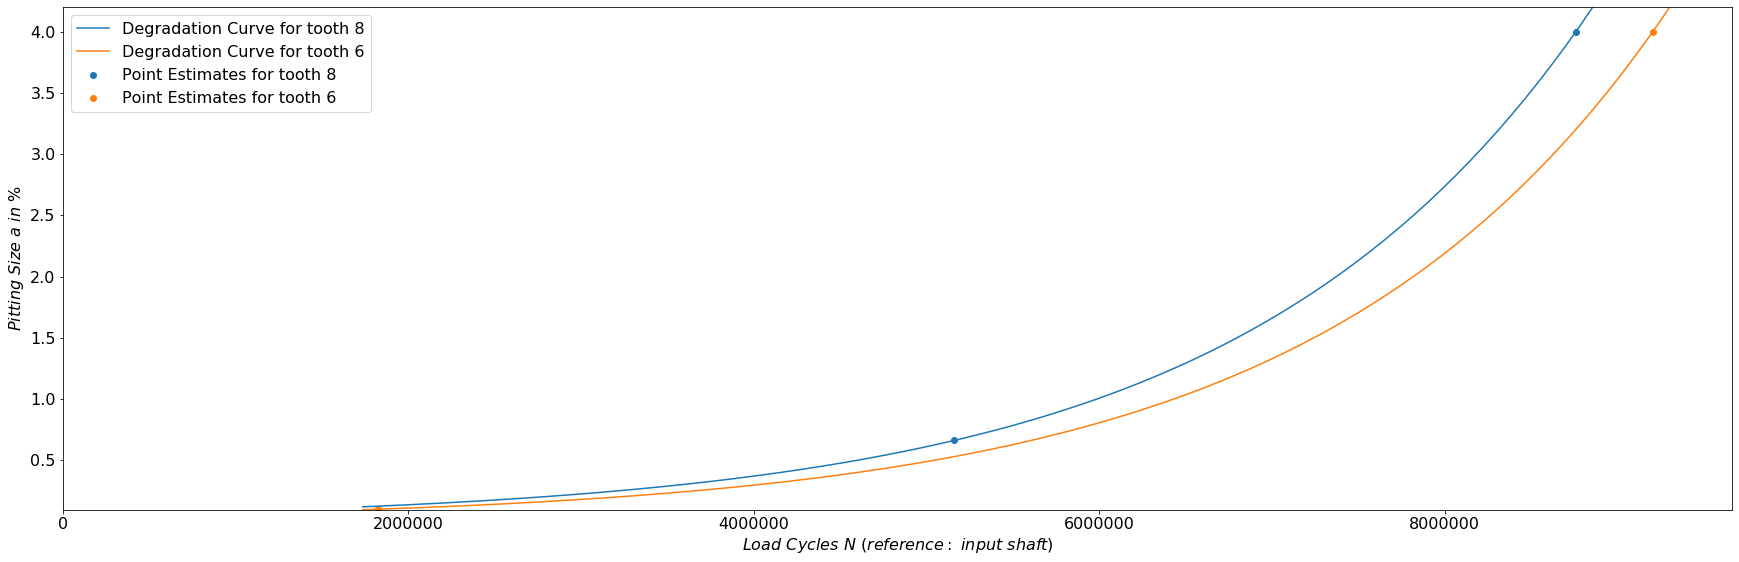

0.000000e+00  6.100000e+06  6.422222e+06  6.744444e+06  7.066667e+06  \
0     -1.434069     -0.041508      0.032052      0.105611      0.179171   
1     -0.247782      0.642824      0.689869      0.736914      0.783959   

   7.388889e+06  7.711111e+06  8.033333e+06  8.355556e+06  8.677778e+06  \
0      0.252731      0.326290      0.399850      0.473410      0.546969   
1      0.831003      0.878048      0.925093      0.972138      1.019182   

   9.000000e+06  
0      0.620529  
1      1.066227

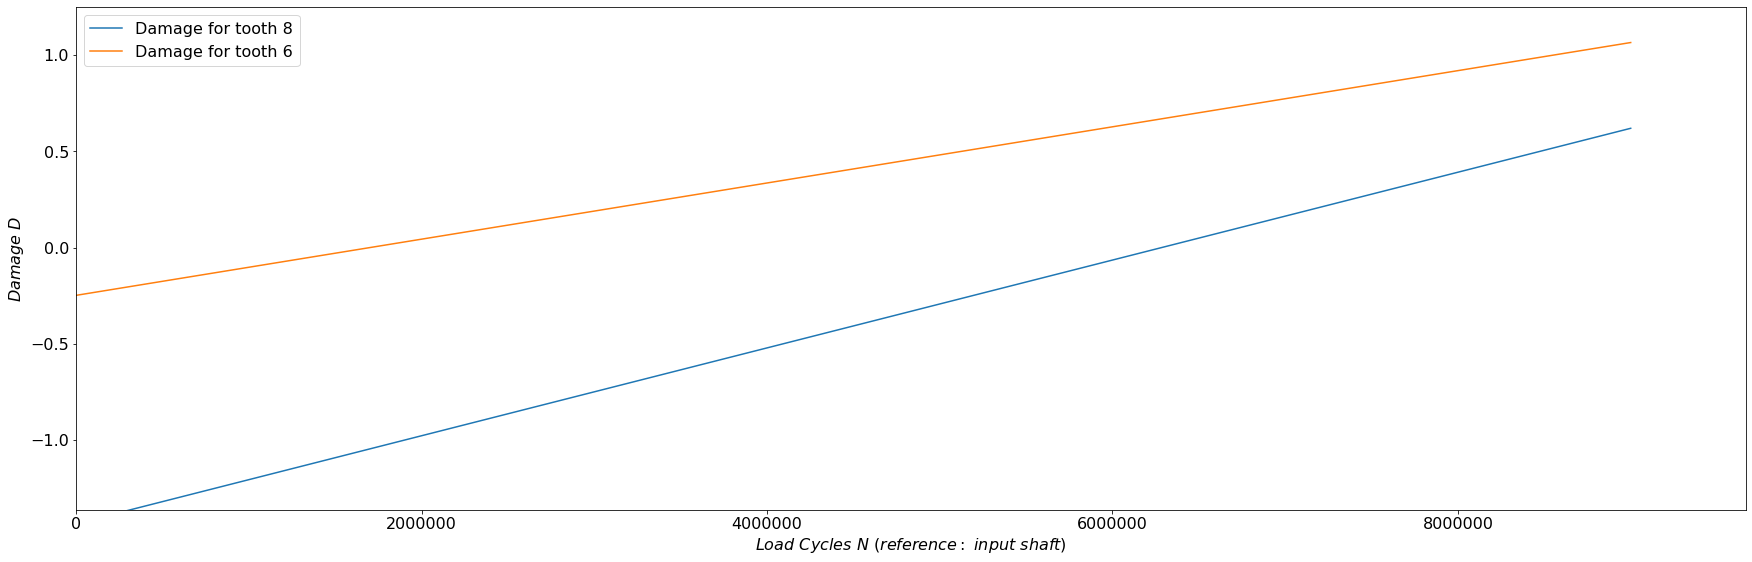

0.000000e+00  6.100000e+06  6.422222e+06  6.744444e+06  7.066667e+06  \
0           NaN           NaN      0.700825      0.800012      0.913236   
1           NaN      1.071208      1.274202      1.515663      1.802882   

   7.388889e+06  7.711111e+06  8.033333e+06  8.355556e+06  8.677778e+06  \
0      1.042485      1.190027      1.358449      1.550709      1.770178   
1      2.144528      2.550916      3.034316      3.609319      4.293286   

   9.000000e+06  
0      2.020709  
1      5.106864

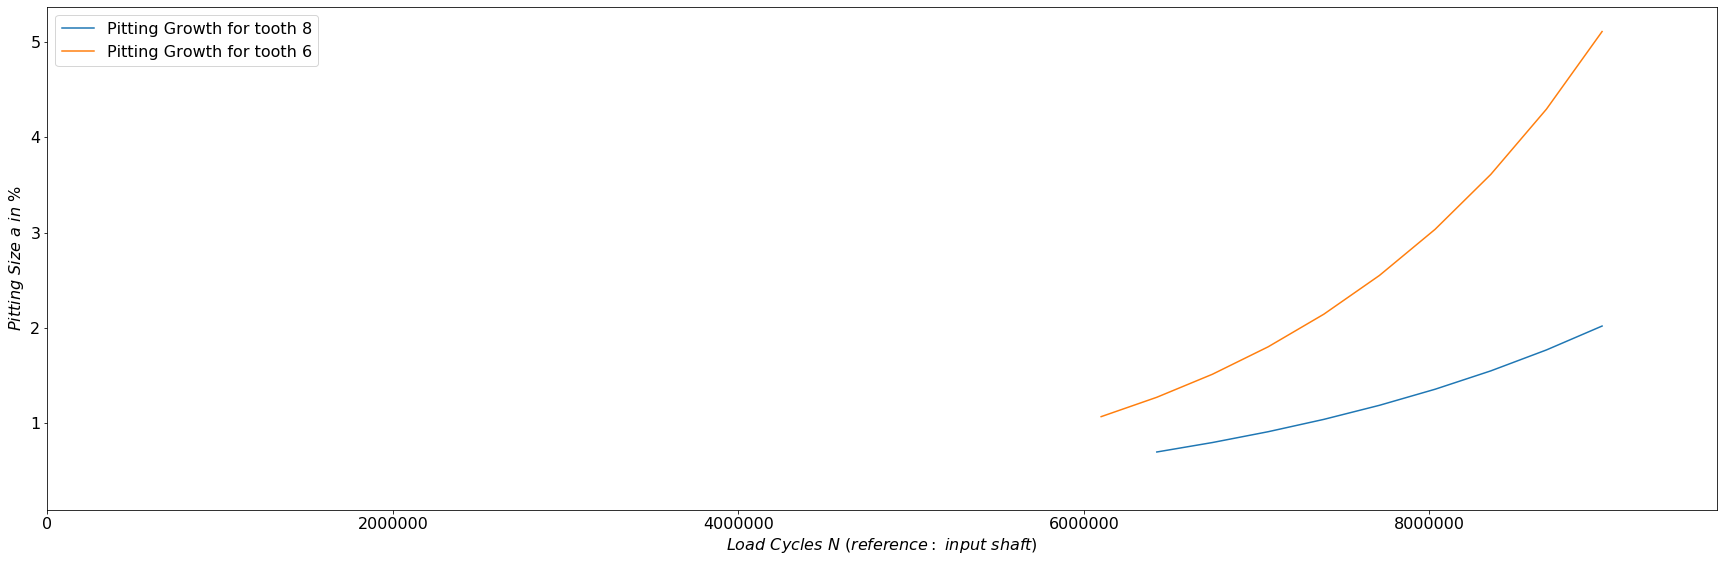

a0            n0  tooth          neol  aeol  theta1        theta2  \
0  0.579647  4.518059e+06      9  8.709422e+06   4.0  0.0501  5.000000e-07   
1  0.551336  6.623250e+06     18  1.058666e+07   4.0  0.0201  5.000000e-07   
2  0.146248  2.587852e+06     21  9.205347e+06   4.0  0.0401  5.000000e-07   

         theta3        n0_old      neol_old  
0  1.000000e-01  4.391948e+06  8.721440e+06  
1  1.776357e-15  5.441903e+06  1.073986e+07  
2  1.776357e-15  5.601978e+06  9.181707e+06

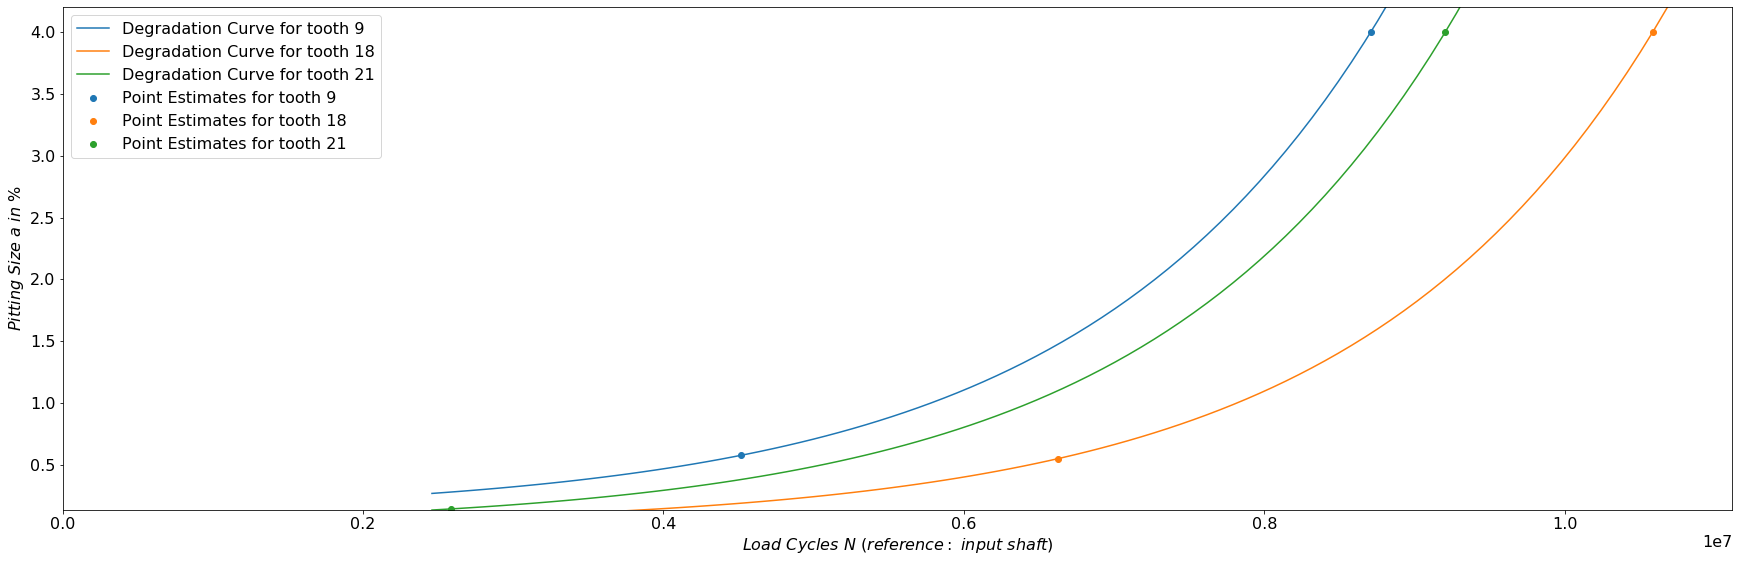

0.000000e+00  6.100000e+06  6.422222e+06  6.744444e+06  7.066667e+06  \
0     -1.077945     -0.304016     -0.263134     -0.222253     -0.181371   
1     -1.671099     -0.852686     -0.809455     -0.766223     -0.722992   
2     -0.391062      0.099115      0.125008      0.150900      0.176793   

   7.388889e+06  7.711111e+06  8.033333e+06  8.355556e+06  8.677778e+06  \
0     -0.140489     -0.099608     -0.058726     -0.017845      0.023037   
1     -0.679761     -0.636530     -0.593298     -0.550067     -0.506836   
2      0.202686      0.228579      0.254471      0.280364      0.306257   

   9.000000e+06  
0      0.063918  
1     -0.463604  
2      0.332150

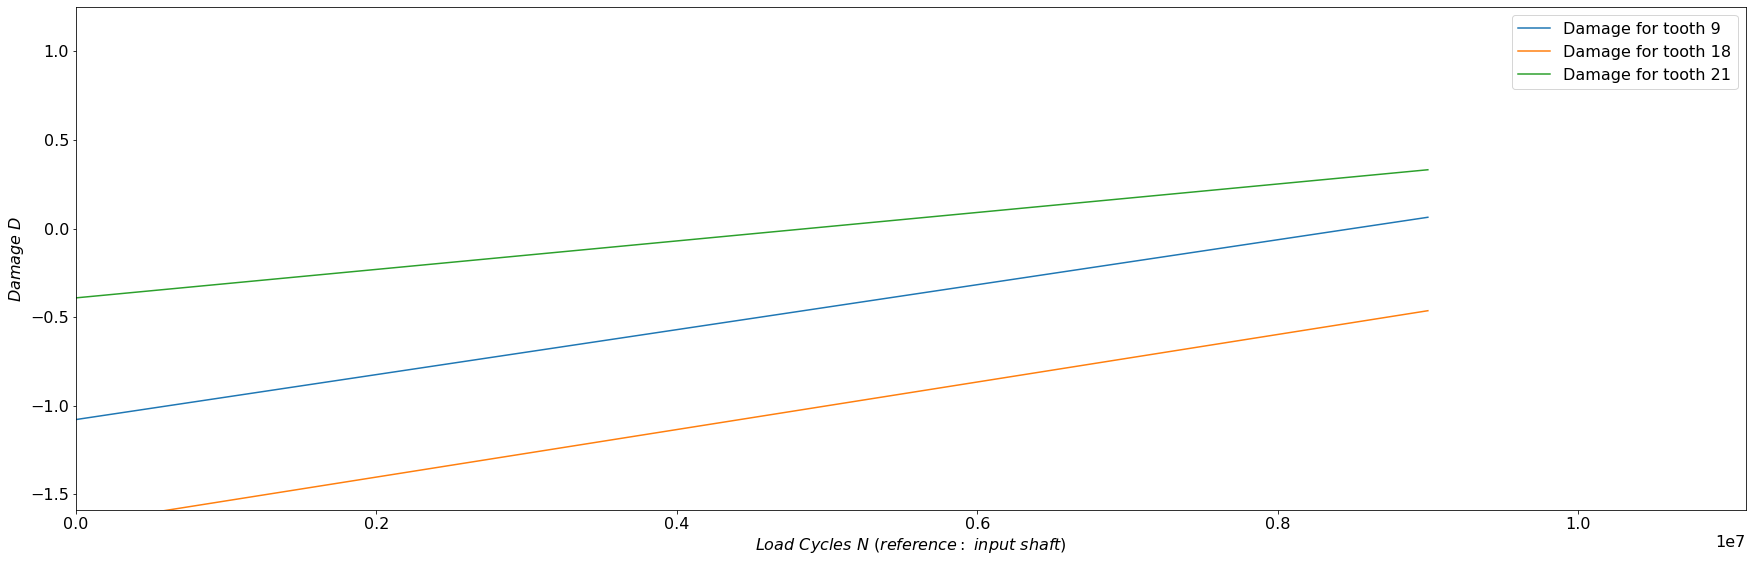

0.000000e+00  6.100000e+06  6.422222e+06  6.744444e+06  7.066667e+06  \
0           NaN           NaN           NaN           NaN           NaN   
1           NaN           NaN           NaN           NaN           NaN   
2           NaN      0.203009      0.221168      0.240951      0.262504   

   7.388889e+06  7.711111e+06  8.033333e+06  8.355556e+06  8.677778e+06  \
0           NaN           NaN           NaN           NaN      0.603372   
1           NaN           NaN           NaN           NaN           NaN   
2      0.285985      0.311566      0.339436      0.369798      0.402876   

   9.000000e+06  
0      0.648399  
1           NaN  
2      0.438913

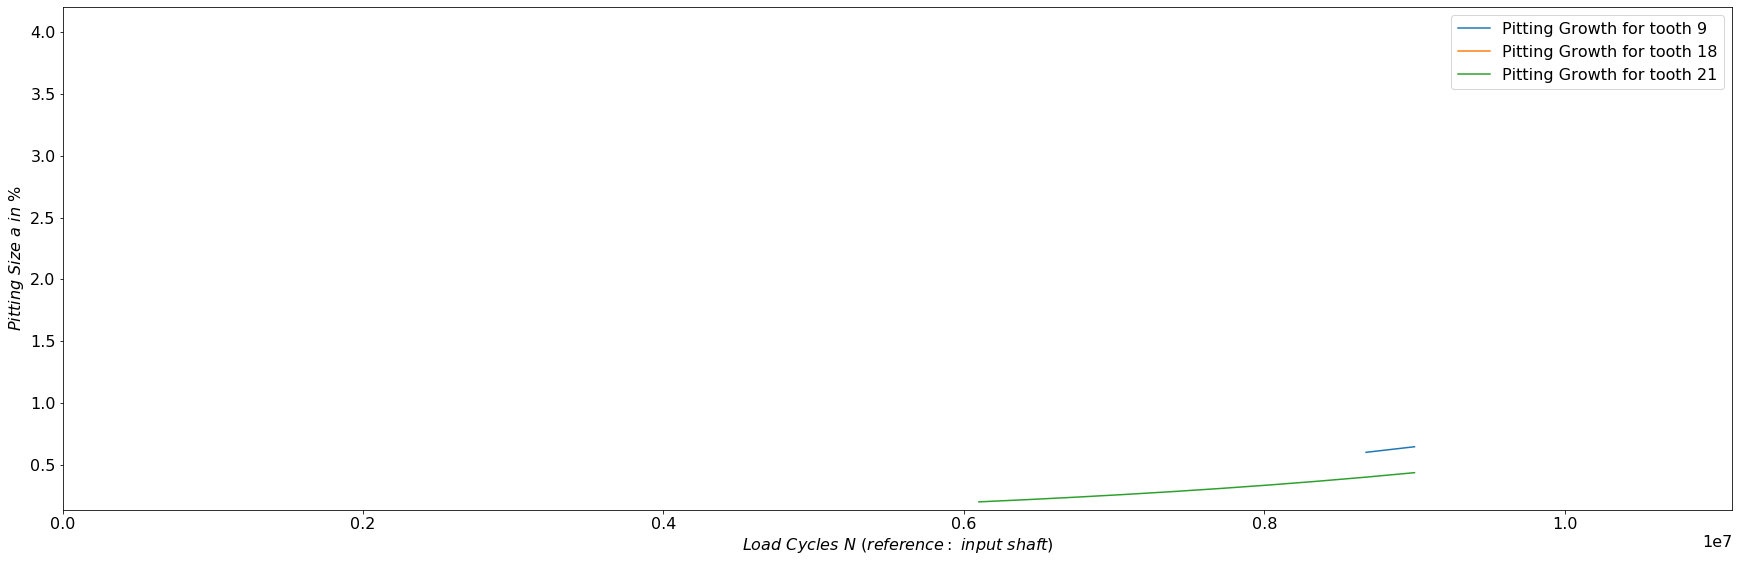

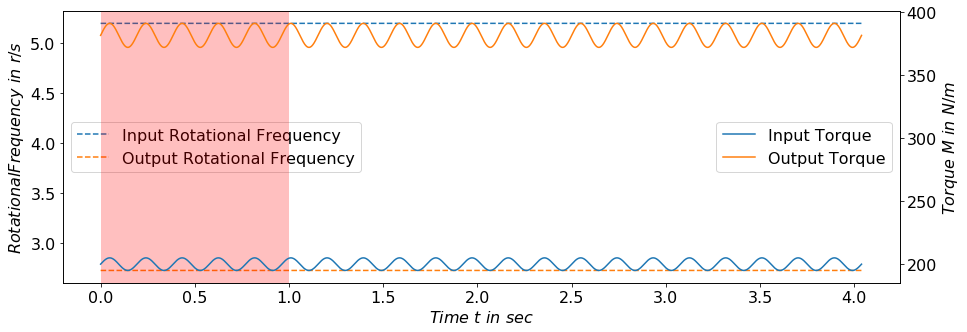

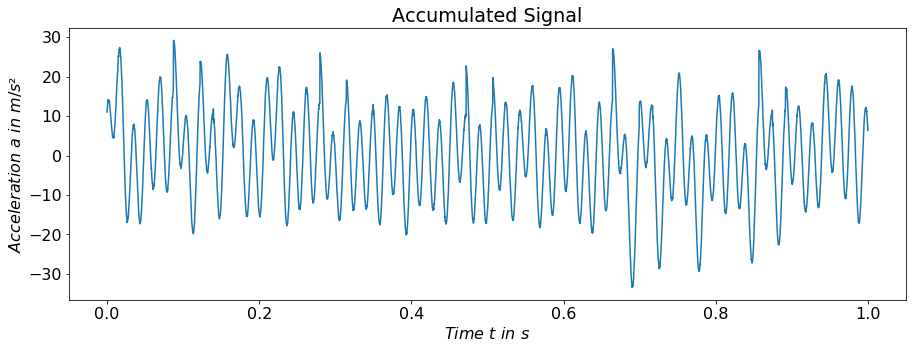

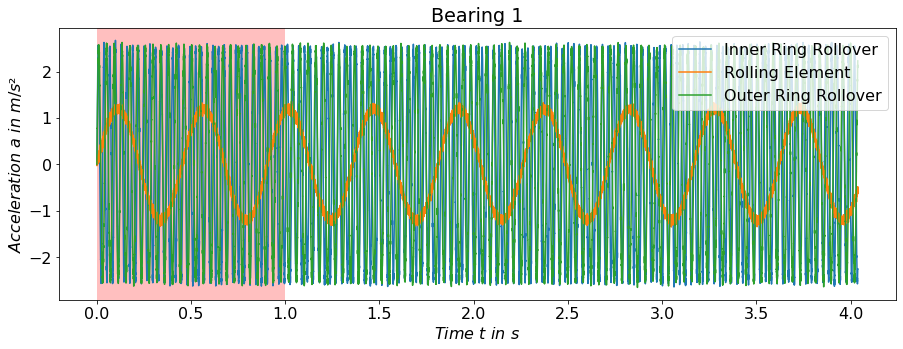

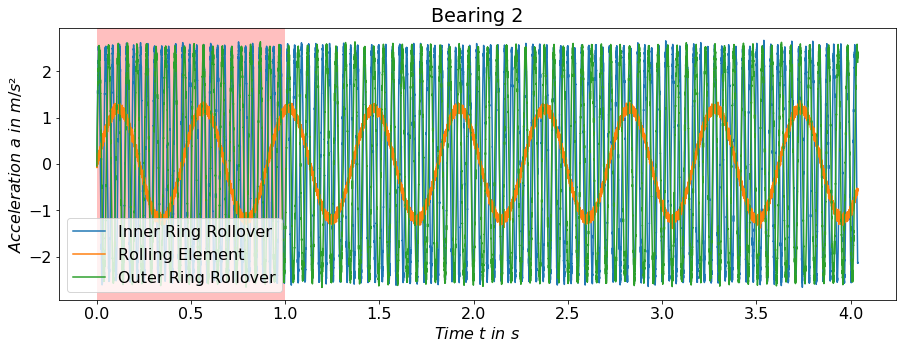

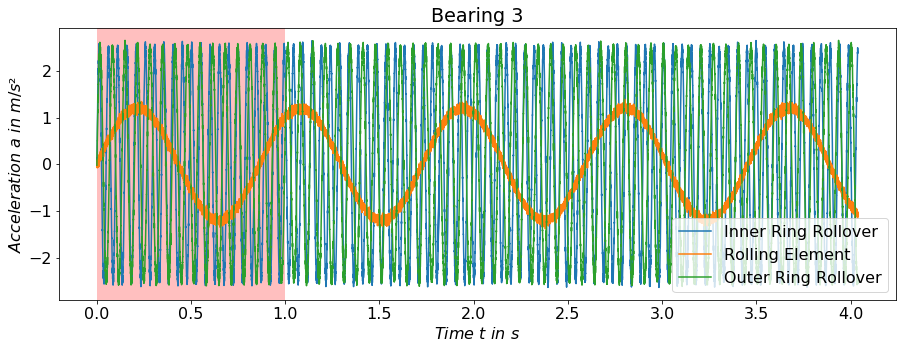

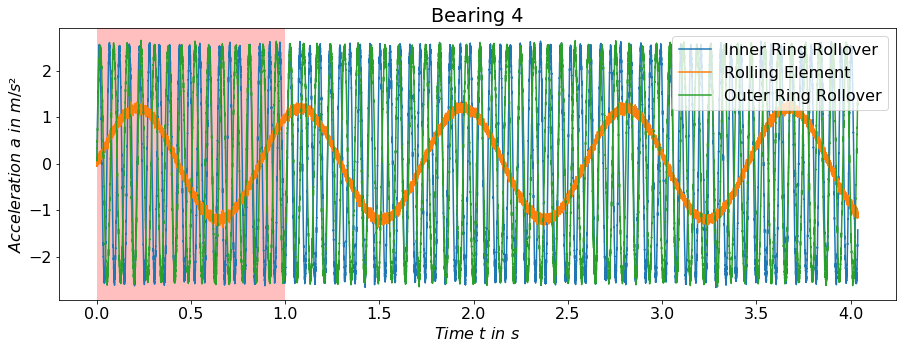

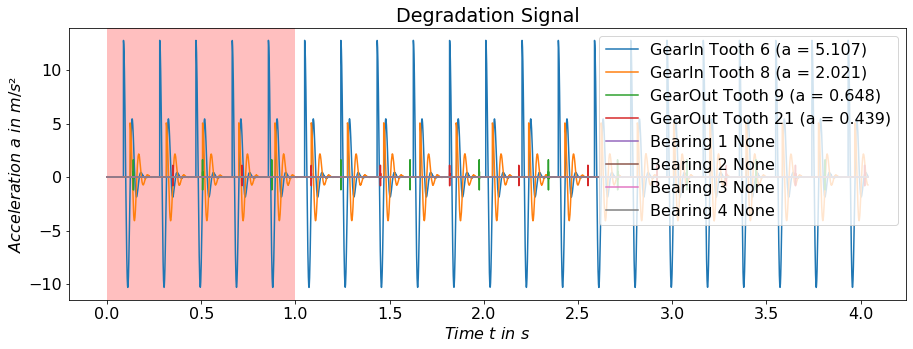

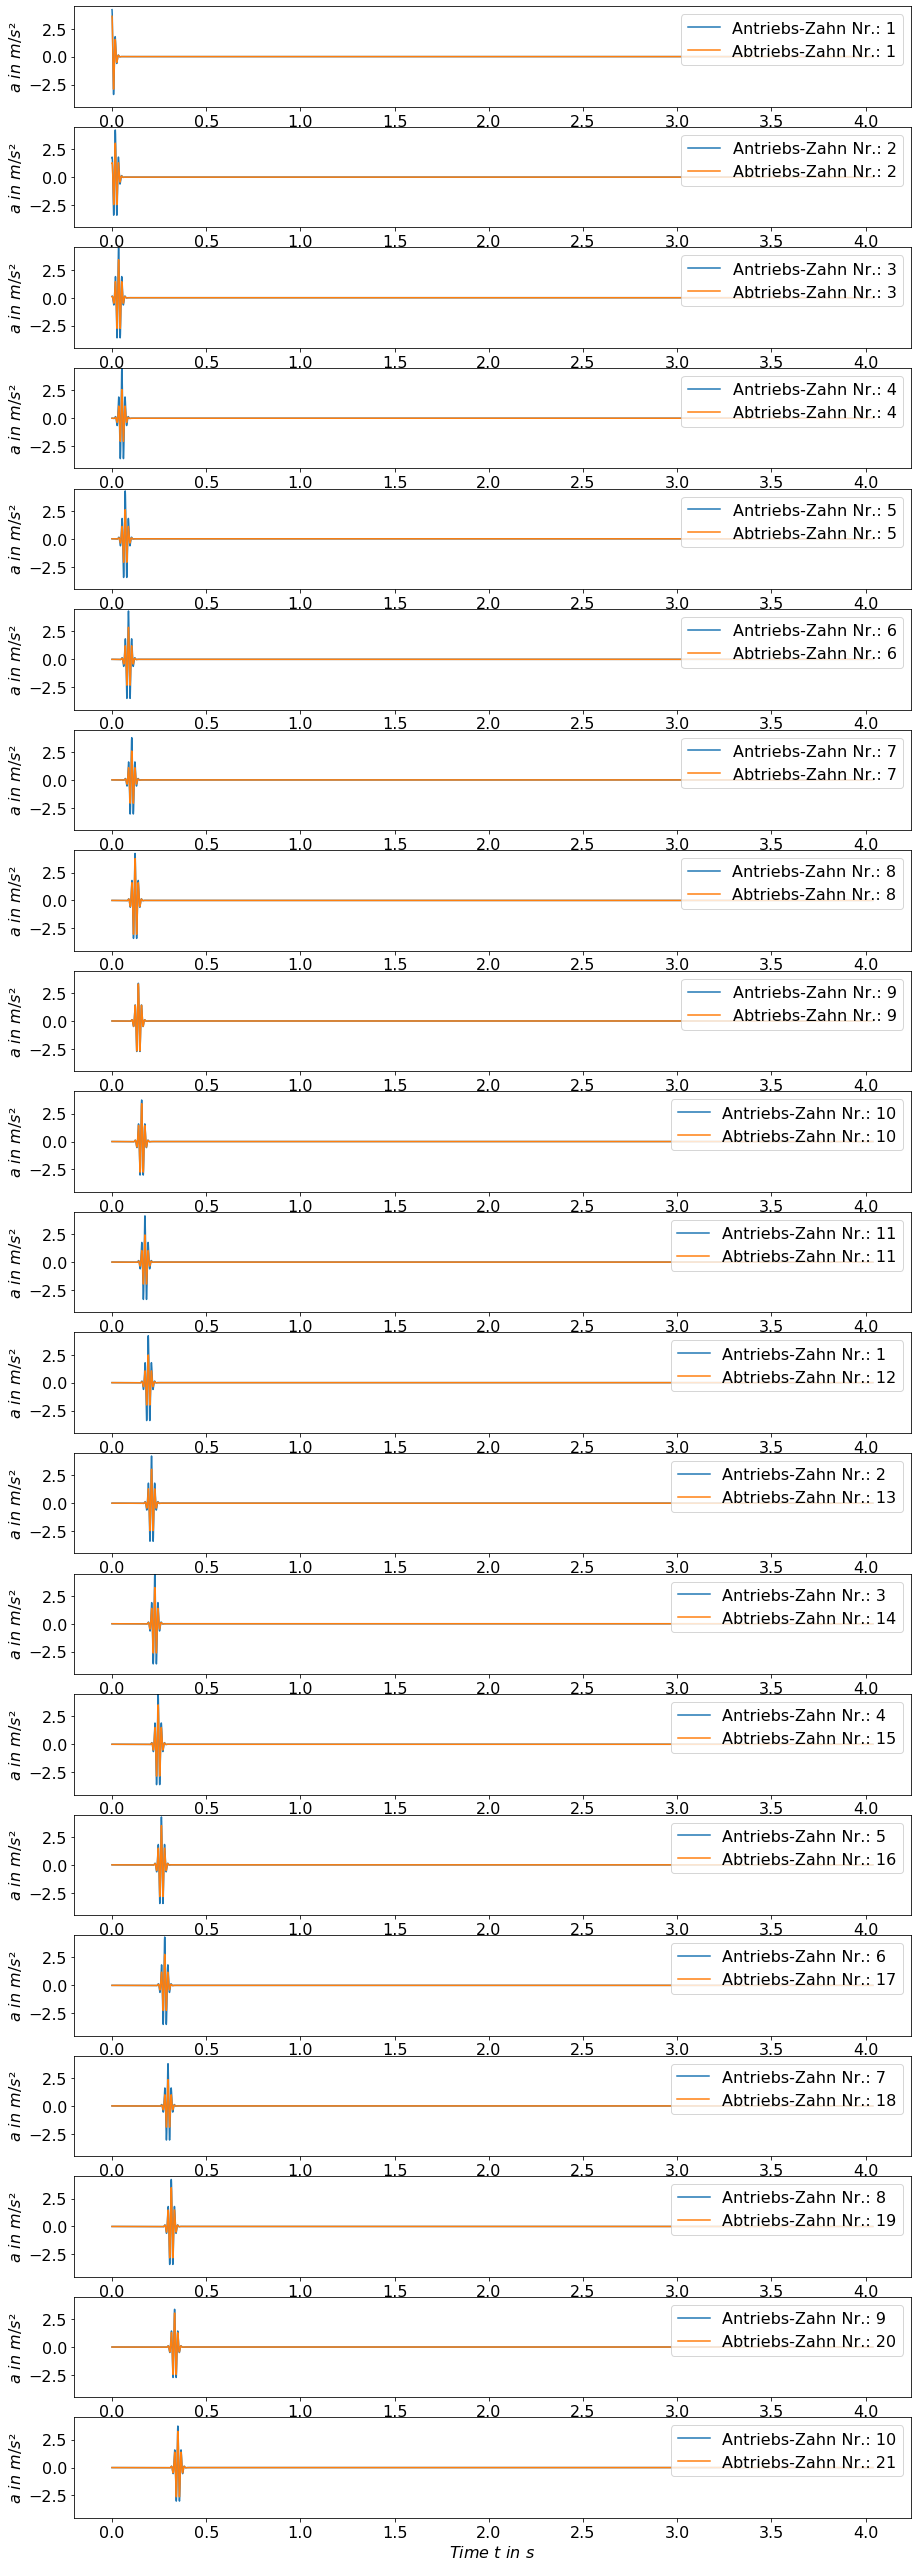

In [35]:
model.summary()


<div style="background-color:rgb(0, 81, 158);color:white;padding:1em;letter-spacing:0.1em;font-size:2em;align=center">
<p><b>Details and Theory</b></p>
</div>

<div style="background-color:rgb(0, 190, 255);color:black;padding:0.5em;letter-spacing:0.1em;font-size:1.5em;align=center">
<p><b>Module Structure</b></p>
</div>
<br>
<img src="__pictures/Modules.png" width="80%">


<li>GearBox Simulation Toolbox is structured in Modules</li>
<li>Top Modules are accesing lower Modules</li>
<li>Helper-Module is used by Modules on the same level</li>
<li>Modules consisting of several Module Methods</li>

<div style="background-color:rgb(0, 190, 255);color:black;padding:0.5em;letter-spacing:0.1em;font-size:1.5em;align=center">
<p><b>Vibration Element Definition</b></p>
</div>
<br>
<h3>Gear Element</h3>
<p>Keyword Attributes: <br>
<ol>
    <li><b>no_teeth: Number of teeth</b> <br></li>
    <li>signal: <a href="NonstationarySignals">Nonstationary Signals</a><br></li>
    <li>ampl_method: <a href="AmplitudeMethod">Method to create Signal Amplitude</a><br></li>
    <li>ampl_attributes: <a href="AmplitudeMethod">Attributes regarding the Method to create Signal Amplitude</a><br></li>
    <li>noise_method:  <a href="AmplitudeMethod">Method to create Signal Noise (repeat methods are not working)</a><br></li>
    <li>noise_attributes: <a href="AmplitudeMethod">Attributes regarding the Method to create Signal Noise</a><br></li>
    <li>torq_method:  <a href="TorqueMethod">Method to create Signal Noise (repeat methods are not working)</a><br></li>
    <li>torq_attributes: <a href="TorqueAmplitudeMethod">Attributes regarding the Method to create Signal Noise</a><br></li>
</ol>
</p>

<p>Gear Element:</p>

In [36]:
Gear = {'no_teeth': 10,                                         # Number of teeth
        'signal': 'gausspulse',                                 # Signal type for gear
        'ampl_method': 'gaussian_repeat',                       # Amplitude Method for inner gear
        'ampl_attributes': {'mu': 4, 'sigma': 0.5},             # Attributes regarding Amplitude Method for gear signal
        'noise_method': None,                                   # Noise Method for inner gear
        'noise_attributes': {'mu': 0, 'sigma': 0.25},           # Attributes regarding Noise Method for gear signal
        'torq_method': None,                                    # Torque Influence Method for inner gear
        'torq_attributes': {'scale_min': 0,
                            'scale_max': 0.2,
                            'value_min': 0,
                            'value_max': 50,
                            'norm_divisor': 200,
                            'exponent': 2},
        }

<p>Modelling:</p>

<li>The chosen Non-Stationary Signal is repeated every tooth mesh</li>
<li>Repeat Methods are modeling the same amplitude at tooth i</li>
<li>Using const_repeat argument constant must be a list of length no_teeth</li>

<h3>Bearing Element</h3>
<p>Keyword Attributes: <br>

<ol>
    <li><b>no_elements: Number of rolling elements</b> <br></li>
    <li>signal_*: <a href="NonstationarySignals">Nonstationary Signals</a><br></li>
    <li>ampl_method_*: <a href="AmplitudeMethod">Method to create Signal Amplitude</a><br></li>
    <li>ampl_attributes_*: <a href="AmplitudeMethod">Attributes regarding the Method to create Signal Amplitude</a><br></li>
    <li>noise_method_*:  <a href="AmplitudeMethod">Method to create Signal Noise (repeat methods are not working)</a><br></li>
    <li>noise_attributes_*: <a href="AmplitudeMethod">Attributes regarding the Method to create Signal Noise</a><br></li>
    <li>torq_method_*:  <a href="TorqueMethod">Method to create Signal Noise (repeat methods are not working)</a><br></li>
    <li>torq_attributes_*: <a href="TorqueAmplitudeMethod">Attributes regarding the Method to create Signal Noise</a><br></li>
</ol>
</p>

<p>*: Can be 'iring' (inner ring), 'relement' (rolling element) or 'oring' (ourter ring)</p>



In [37]:
Bearing =   {'no_elements': 11,                                    # Number of Rolling Elements
             # Inner Ring Rollover
             'signal_iring': 'sine',                               # Signal type for inner cage
             'ampl_method_iring': 'const',                         # Amplitude Method for inner cage signal (Repeat methods are not working for bearings)
             'ampl_attributes_iring': {'constant': 2.5},           # Attributes regarding Amplitude Method for inner cage signal
             'noise_method_iring': 'gaussian',                     # Noise Method for inner gear
             'noise_attributes_iring': {'mu': 0, 'sigma': 0.05},   # Attributes regarding Noise Method for gear signal
             'torq_method_iring': None,                         # Torque Influence Method for rolling element
             'torq_attributes_iring': {'scale_min': 0,          # Attributes regarding Torque Influence Method for rolling element signal
                                       'scale_max': 0.1,
                                       'value_min': 0,
                                       'value_max': 50,
                                       'norm_divisor': 1,
                                       'exponent': 4},           

             # Rolling Element:
             'signal_relement': 'sine',                            # Signal type for rolling element
             'ampl_method_relement': 'const',                      # Amplitude Method for rolling element signal (Repeat methods are not working for bearings)
             'ampl_attributes_relement': {'constant': 1.2},        # Attributes regarding Amplitude Method for rolling element signal
             'noise_method_relement': 'gaussian',                  # Noise Method for rolling element
             'noise_attributes_relement': {'mu': 0, 'sigma': 0.05},# Attributes regarding Noise Method for gear signal
             'torq_method_relement': None,                         # Torque Influence Method for rolling element
             'torq_attributes_relement': {'scale_min': 0,          # Attributes regarding Torque Influence Method for rolling element signal
                                          'scale_max': 0.1,
                                          'value_min': 0,
                                          'value_max': 50,
                                          'norm_divisor': 1,
                                          'exponent': 4},
             # Outer Ring Rollover
             'signal_oring': 'sine',                               # Signal type for inner cage
             'ampl_method_oring': 'const',                         # Amplitude Method for inner cage signal (Repeat methods are not working for bearings)
             'ampl_attributes_oring': {'constant': 2.5},           # Attributes regarding Amplitude Method for inner cage signal
             'noise_method_oring': 'gaussian',                     # Noise Method for inner gear
             'noise_attributes_oring': {'mu': 0, 'sigma': 0.05},   # Attributes regarding Noise Method for gear signal
             'torq_method_oring': None,                         # Torque Influence Method for rolling element
             'torq_attributes_oring': {'scale_min': 0,          # Attributes regarding Torque Influence Method for rolling element signal
                                       'scale_max': 0.1,
                                       'value_min': 0,
                                       'value_max': 50,
                                       'norm_divisor': 1,
                                       'exponent': 4},          
            }

<p>Modelling:</p>

<li>The frequencies for the chosen Stationary Signal are estimated by VDI 3832 (Estimation without geometrical dimensions)</li>
<li>Repeat Methods are not working</li>
<li>As approximation factor 0.425 is chosen</li>
<br>
<div class="container">
    <div class="col-lg-6 col-md-6  col-sm-2">
      <img src="__pictures/VDI3832_Bearing_formula.png" width="75%">
    </div>
    <div class="col-lg-6 col-md-6  col-sm-2" >
      <img src="__pictures/VDI3832_Bearing_symbols.png" width="75%">
    </div>
<div>




<div style="background-color:rgb(0, 190, 255);color:black;padding:0.5em;letter-spacing:0.1em;font-size:1.5em;align=center">
<p><b>Vibration Methods and Theory</b></p>
</div>
<br>

<p>Module Methods Structure:</p>

<img src="__pictures/Vibration_Method.png" width="100%">




<p>Required Inputs:</p>
<li>General Input Arguments (previous slides)</li>
<li>Vibration Method Definition for each Element (see following slides)</li>
<li>State of Degradation (given by degradation model)</li>

<p>Methods and Returns:</p>
<li>run(): Vibration Signal (for state s<sub>p</sub> = n<sub>lc</sub> based on previous torque<sub>p-1</sub>)</li>
<li>set(): Loads per tooth/bearing (based on current torque<sub>p</sub>)</li>


<h3>Element Method</h3>
<br>

<li>Creating Base Signals for Bearing and Gear Elements</li>
<li>Amplitude of +-1</li>
<li>For Bearing choose any stationary signal: 'sine'</li>
<li>For Gear choose any nonstationary signal: <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.gausspulse.html">'gausspulse'</a> <br>
</li>


<p>Example Non-Stationary Sine Signal</p>

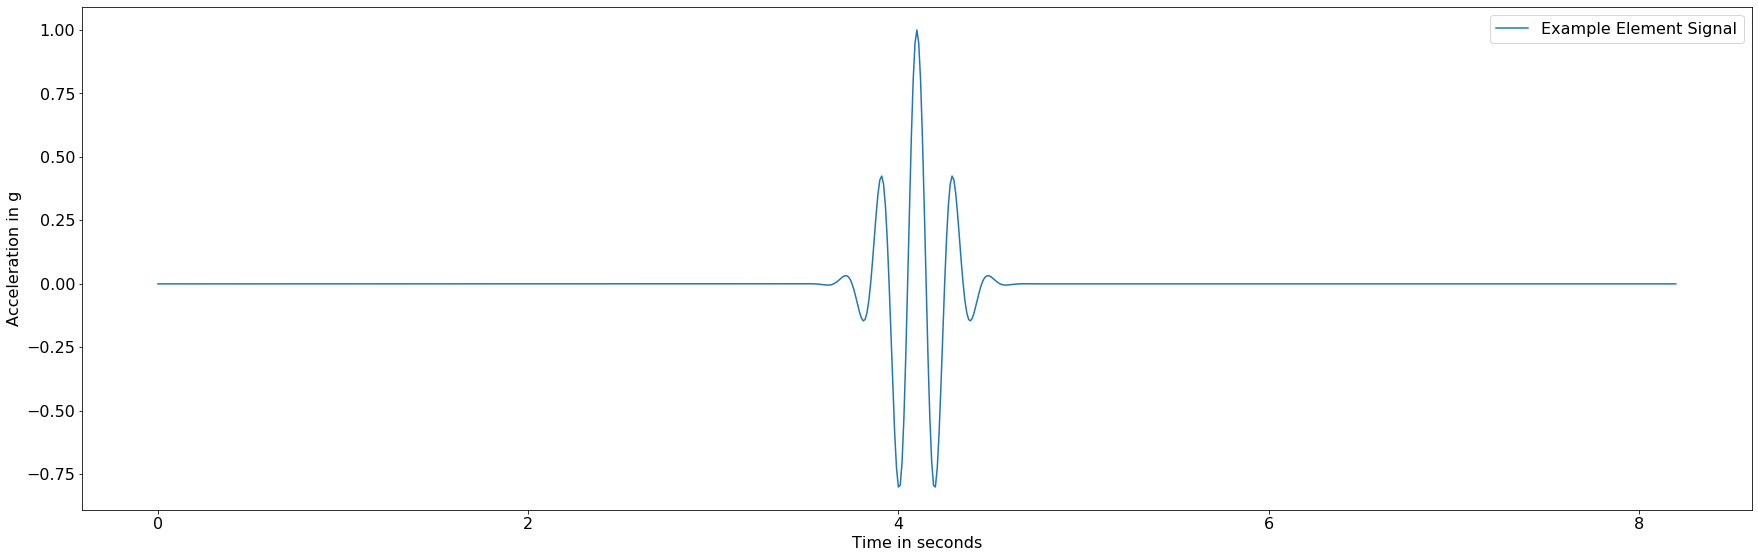

In [38]:
from scipy.signal import gausspulse
fi, fs = 5, 100
time_vector = gf.get_sample_time_torque(fi, fs, 21, 41)
element_signal = gausspulse(np.linspace(-max(time_vector)/2, max(time_vector)/2, time_vector.size), fc=fi, bw=0.5, bwr=-6, tpr=-60, retquad=False, retenv=False) # Nm | array

plt.plot(time_vector, element_signal)
plt.xlabel('Time in seconds'), plt.ylabel('Acceleration in g'), plt.legend(['Example Element Signal'])
plt.show()

<p>Example Stationary Sine Signal</p>

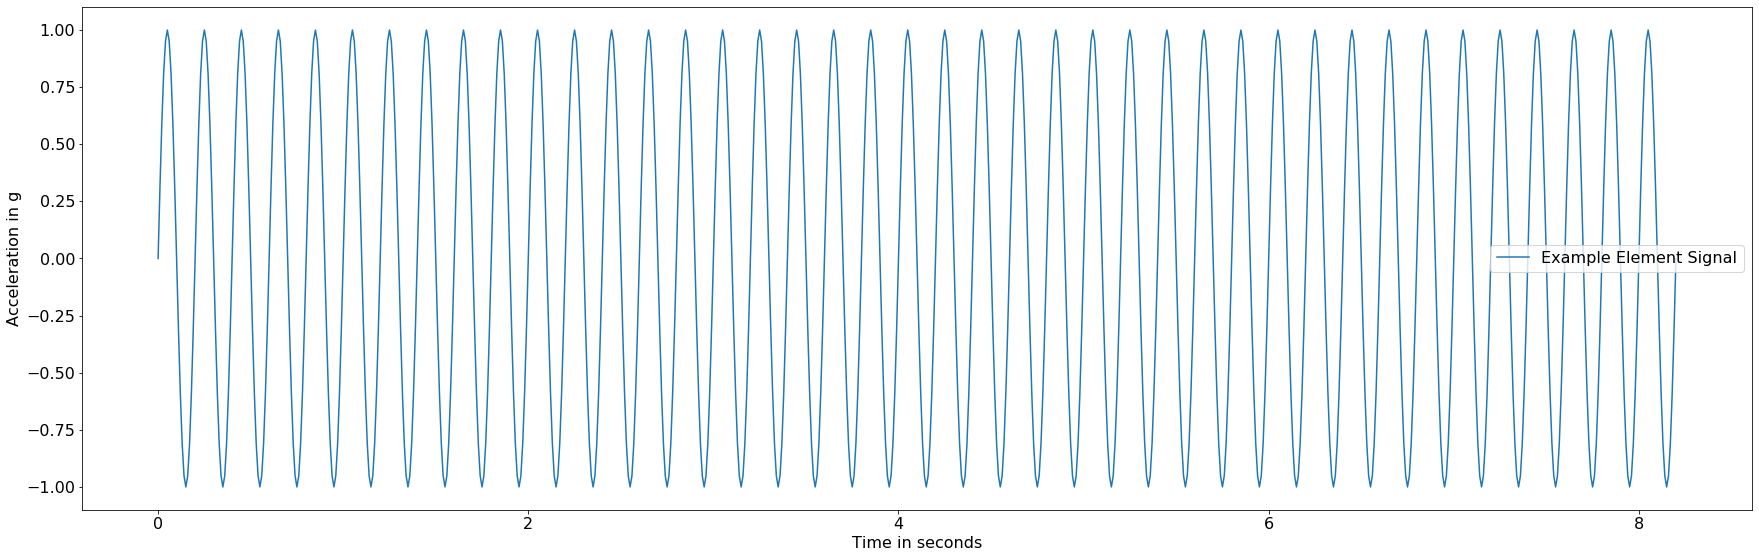

In [39]:
fi, fs = 5, 100
time_vector = gf.get_sample_time_torque(fi, fs, 21, 41)
element_signal = np.sin((2 * np.pi * fi * time_vector)) # Nm | array

plt.plot(time_vector, element_signal)
plt.xlabel('Time in seconds'), plt.ylabel('Acceleration in g'), plt.legend(['Example Element Signal'])
plt.show()

<h3>Amplitude Method</h3>
<br>

<li>Scaling the Base Signals</li>
<li>Various methods can be chosen (depending on Element)</li>
<li>Depending on the chosen Method, different Attributes must be given</li>
<li>'repeat' Methods create a pattern which will be repeated</li>

<p>Methods:</p>
<li>None: Method not used</li>
<li>'const': Constant Amplitude for all teeth and all tooth mesh repetitions (<u>attributes:</u> 'constant' (scalar))</li>
<li>'const_repeat': Constant Amplitude for each tooth (list), and unchanging over all tooth mesh repetitions (<u>attributes:</u> 'constant' (list, tuple))</li>
<li>'gaussian': Gaussian Random Amplitude for all teeth and all tooth mesh repetitions (<u>attributes:</u> 'mu' (scalar), 'sigma' (scalar)) </li>
<li>'gaussian_repeat': Gaussian Random Amplitude for each tooth, and unchanging over all tooth mesh repetitions (<u>attributes:</u> 'mu' (scalar), 'sigma' (scalar)) </li>


<p>Example Stationary Sine Signal * const Amplitude</p>

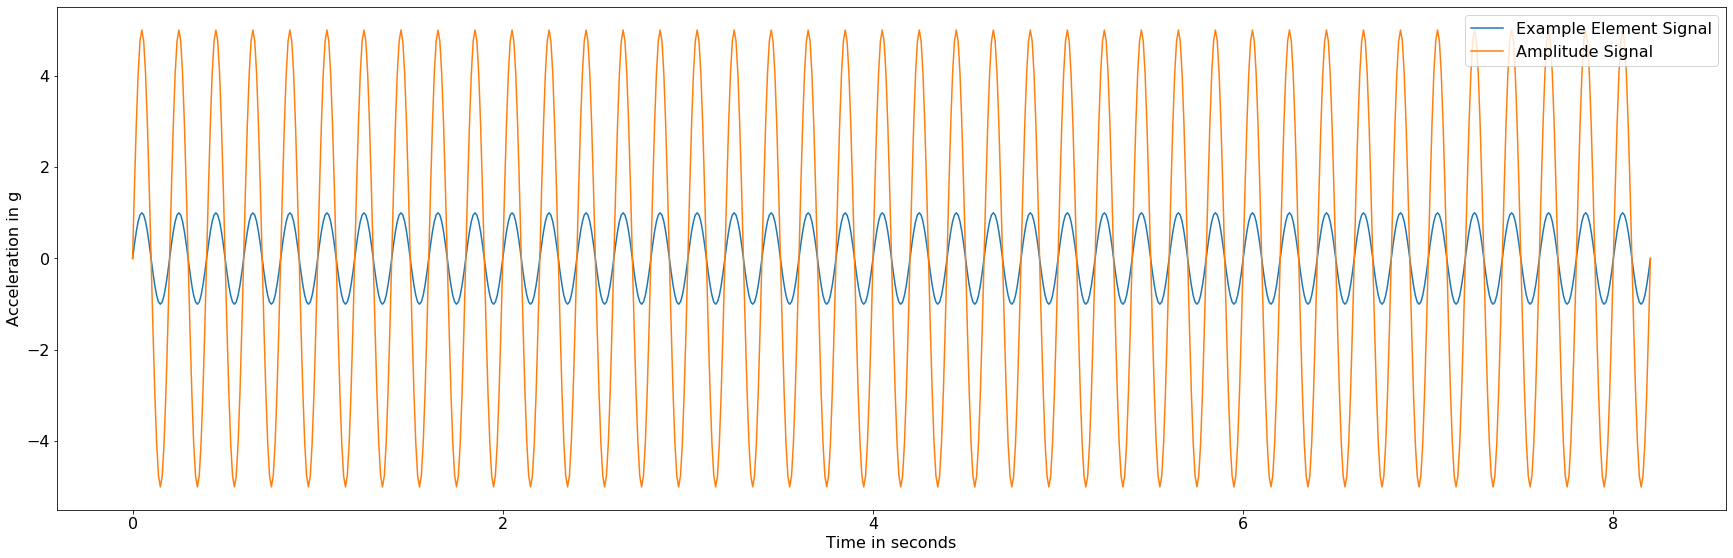

In [40]:
const = 5
amplitude_signal = element_signal * const

plt.plot(time_vector, element_signal, time_vector, amplitude_signal)
plt.xlabel('Time in seconds'), plt.ylabel('Acceleration in g'), plt.legend(['Example Element Signal', 'Amplitude Signal'])
plt.show()

<h3>Noise Method</h3>
<br>

<li>Adds noise to the signal</li>
<li>Based on the Amplitude Methods Toolbox (repeat methods are not working)</li>
<li>General use: Adding Gaussian Noise</li>

<p>Methods:</p>

<li>None: Method not used</li>
<li>'const': Constant Amplitude for all teeth and all tooth mesh repetitions (<u>attributes:</u> 'constant' (scalar))</li>
<li><strike>'const_repeat': Constant Amplitude for each tooth (list), and unchanging over all tooth mesh repetitions (<u>attributes:</u> 'constant' (list, tuple))</strike></li>
<li>'gaussian': Gaussian Random Amplitude for all teeth and all tooth mesh repetitions (<u>attributes:</u> 'mu' (scalar), 'sigma' (scalar)) </li>
<li><strike>'gaussian_repeat': Gaussian Random Amplitude for each tooth, and unchanging over all tooth mesh repetitions (<u>attributes:</u> 'mu' (scalar), 'sigma' (scalar))</strike></li>

<p>Example Stationary Sine Signal * const Amplitude + noise</p>

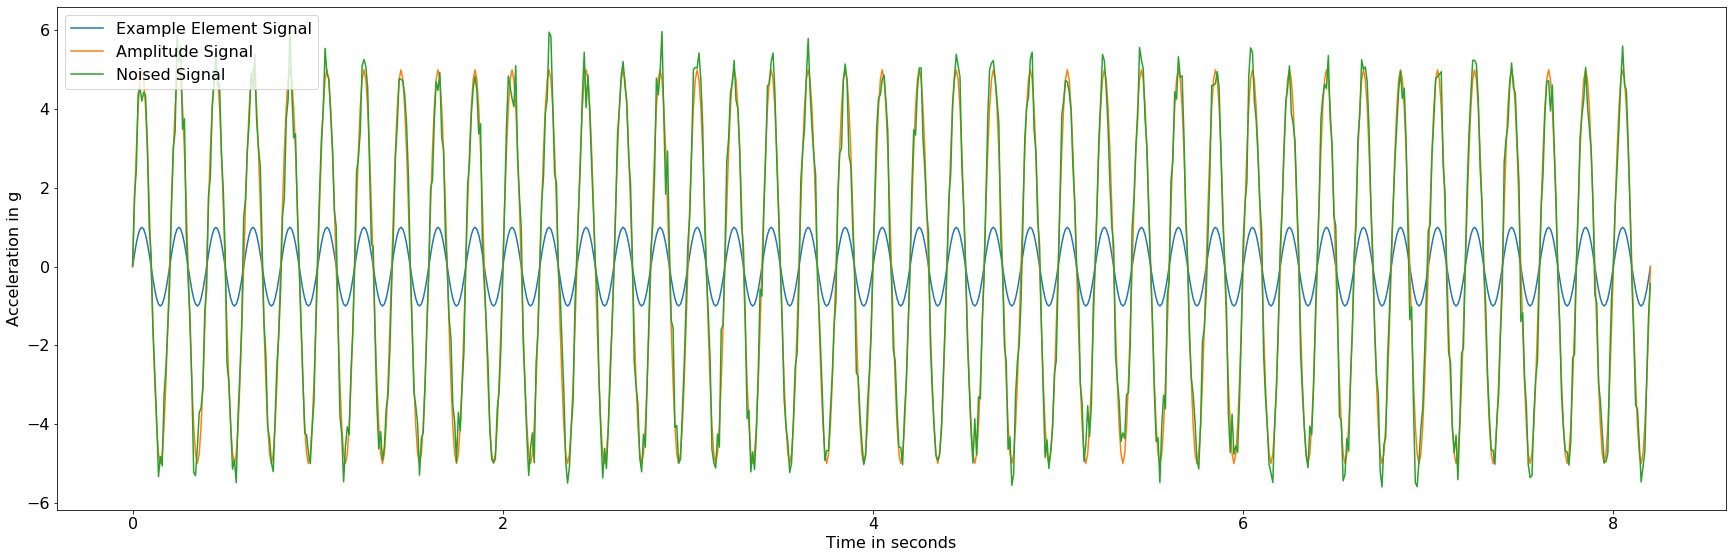

In [41]:
noise = np.random.randn(time_vector.size)*0.5
noised_signal = amplitude_signal + noise

plt.plot(time_vector, element_signal, time_vector, amplitude_signal, time_vector, noised_signal)
plt.xlabel('Time in seconds'), plt.ylabel('Acceleration in g'), plt.legend(['Example Element Signal', 'Amplitude Signal', 'Noised Signal'])
plt.show()

<h3>Torque Method</h3>
<br>

<li>Scales Signal s regarding the torque s<sub>t</sub></li>
<li>1. s<sub>t</sub> = s<sub>t</sub>/s<sub>norm</sub>, norm signal by s<sub>norm</sub></li>
<li>2. s<sub>t</sub> = f(s<sub>t</sub>), while f can be linear, polynomial and exponential</li>
<li>3. s<sub>t</sub> = scale(s<sub>t</sub>), scale into range scale_min-scale_max while scale_min corresponds to value_min and scale_max to value_max</li>
<li>4. s<sub>t</sub> = s<sub>t</sub> + 1, add one to retain origninal signal and add torque on top</li>
<li>5. s = s * s<sub>t</sub></li>

<p>Methods:</p>

<li>None: Method not used</li>
<li>'linear': f in step 2 is linear transformation (no transformation)</li>
<li>'polynomial': f in step 2 is polynomial with given exponent argument</li>
<li>'exponential': f in step 2 is exponential</li>

<p>Example Torque Signal 200 Nm +- 5 Nm</p>

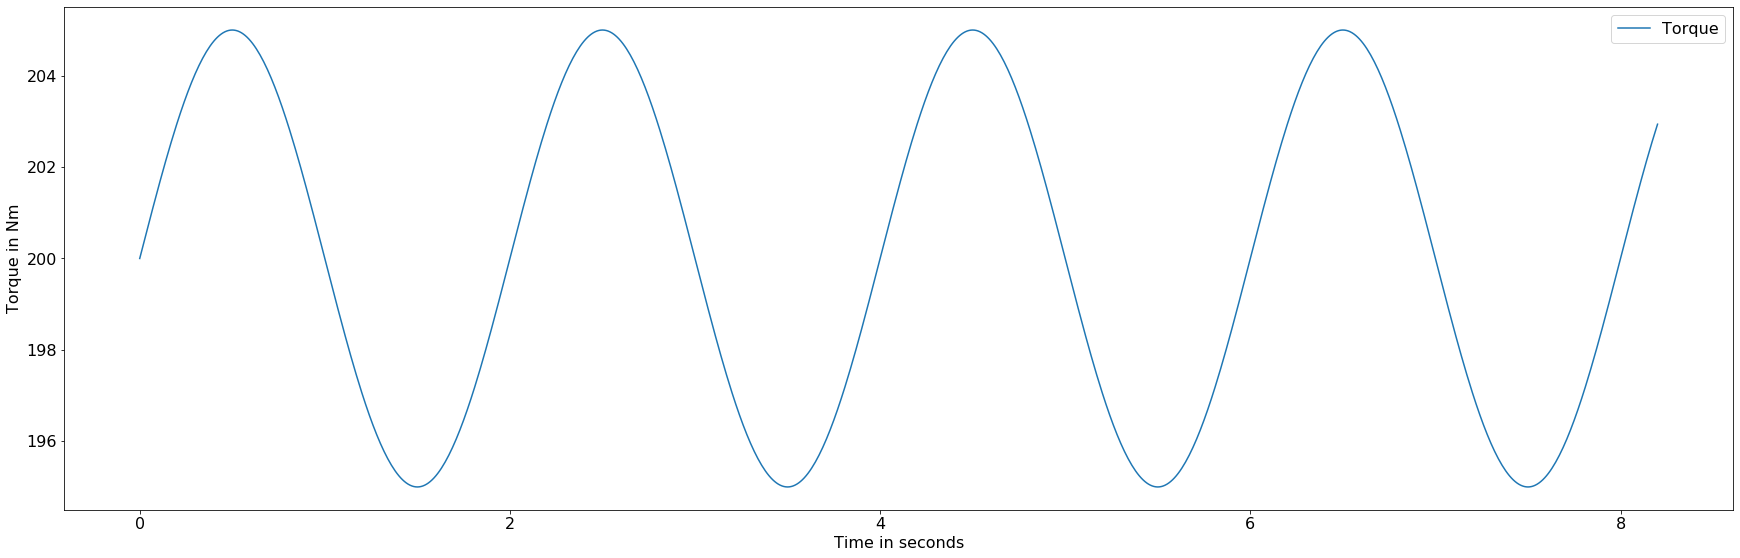

In [42]:
torque = np.sin((2 * np.pi * fi /10 * time_vector))*5 + 200 # Nm | array

plt.plot(time_vector, torque)
plt.xlabel('Time in seconds'), plt.ylabel('Torque in Nm'), plt.legend(['Torque'])
plt.show()


<p>Define Scale Arguments</p>

In [43]:
scale_min = 0                   
scale_max = 0.2
value_min = 1-0.01
value_max = 1.01
norm_divisor = 200
exponent = 2


<p>1. s<sub>t</sub> = s<sub>t</sub>/s<sub>norm</sub>, norm signal by s<sub>norm</sub></p>

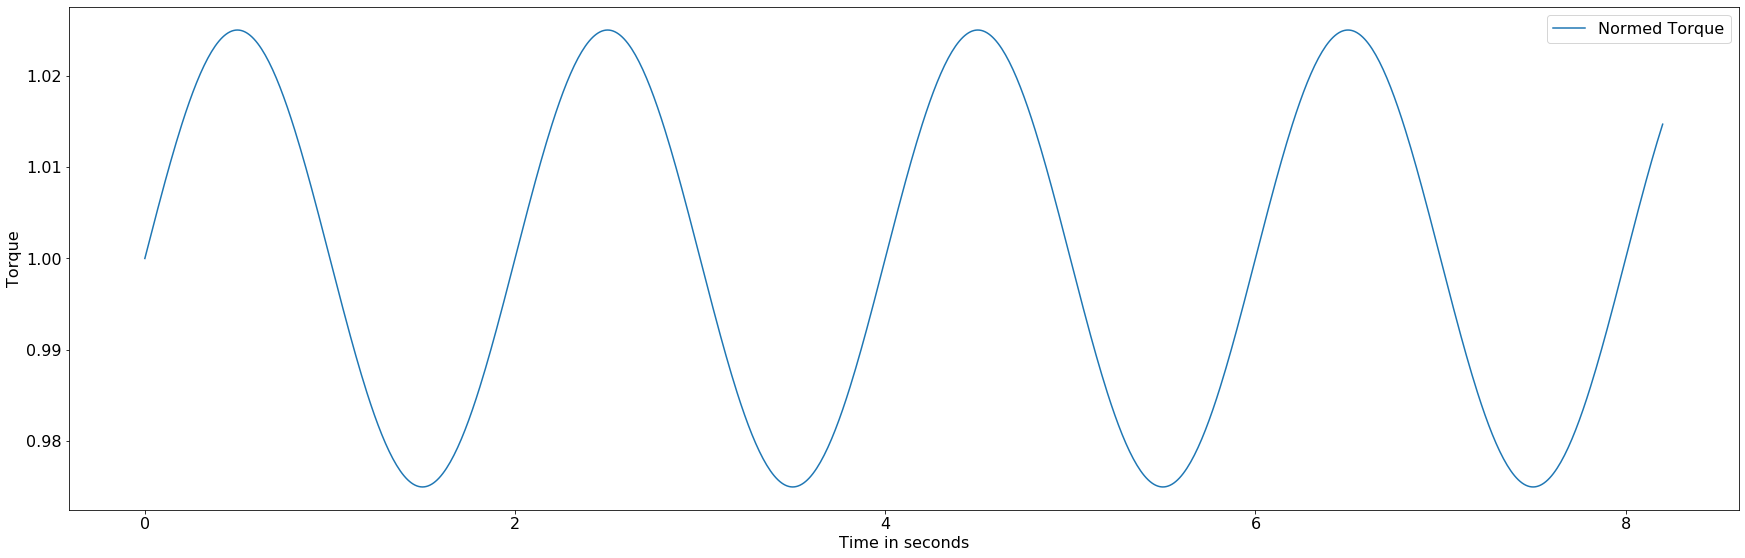

In [44]:
torque_1 = torque / norm_divisor

plt.plot(time_vector, torque_1)
plt.xlabel('Time in seconds'), plt.ylabel('Torque'), plt.legend(['Normed Torque'])
plt.show()

<p>2. s<sub>t</sub> = f(s<sub>t</sub>), while f can be linear, polynomial and exponential</p>

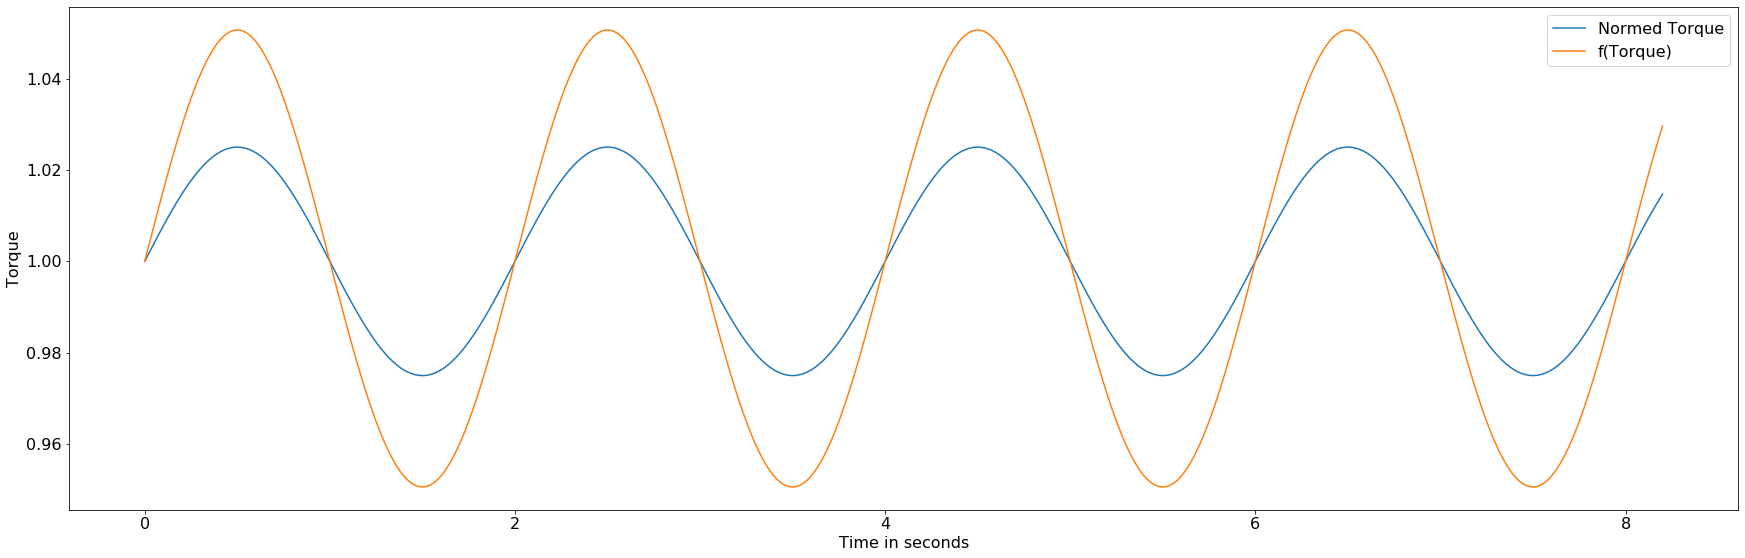

In [45]:
torque_2 = np.power(torque_1, exponent) 

plt.plot(time_vector, torque_1, time_vector, torque_2)
plt.xlabel('Time in seconds'), plt.ylabel('Torque'), plt.legend(['Normed Torque', 'f(Torque)'])
plt.show()

<p>3. s<sub>t</sub> = scale(s<sub>t</sub>), scale into range scale_min-scale_max while scale_min corresponds to value_min and scale_max to value_max</p>

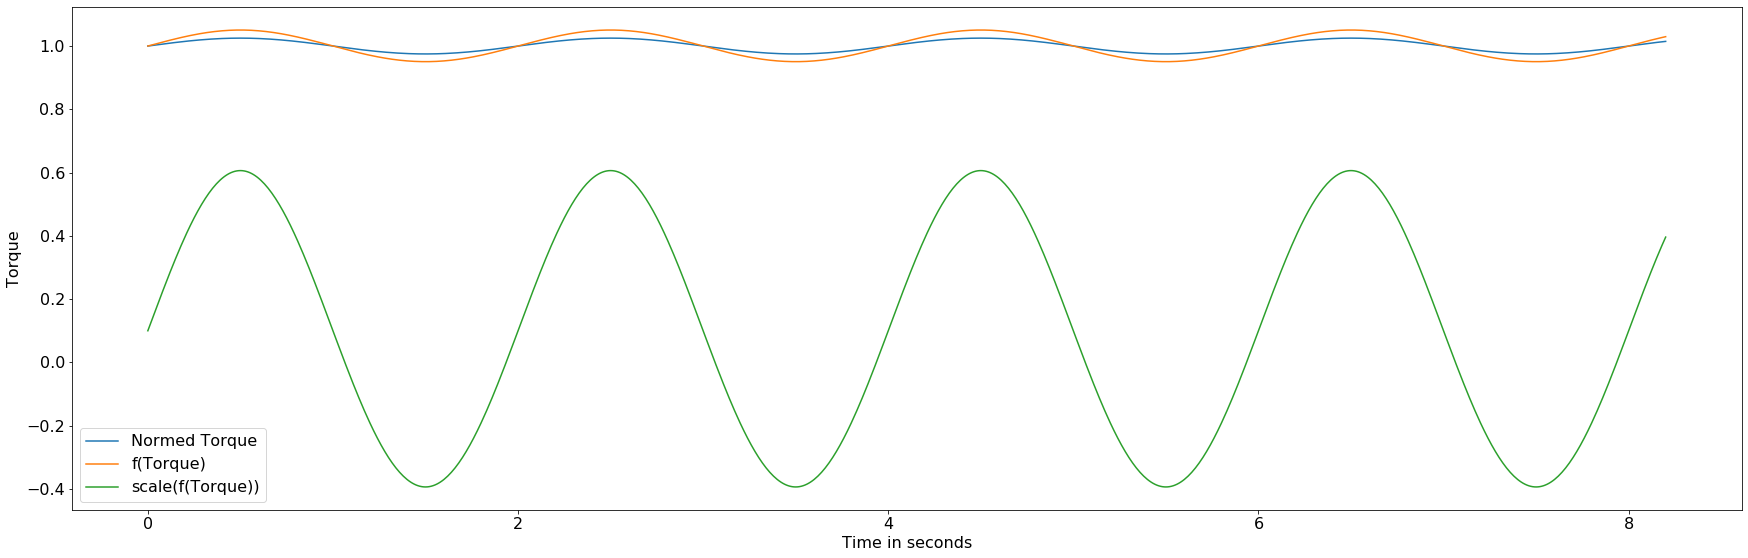

In [46]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(scale_min, scale_max))
scaler.fit(np.array([value_min, value_max]).reshape(-1, 1))
torque_3 = scaler.transform(torque_2.reshape(-1, 1)) 

plt.plot(time_vector, torque_1, time_vector, torque_2, time_vector, torque_3)
plt.xlabel('Time in seconds'), plt.ylabel('Torque'), plt.legend(['Normed Torque', 'f(Torque)', 'scale(f(Torque))'])
plt.show()

<p>4. s<sub>t</sub> = s<sub>t</sub> + 1, add one to retain origninal signal and add torque on top</p>

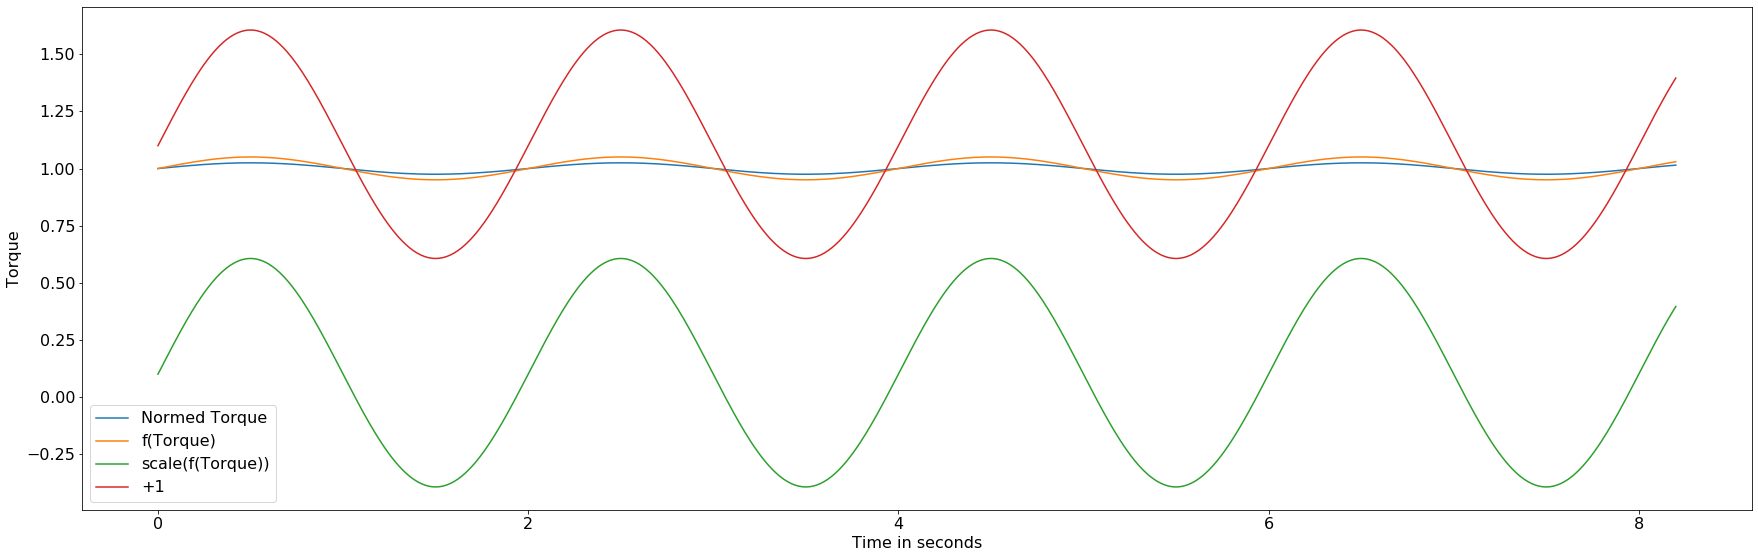

In [47]:
torque_4 = torque_3 + 1 

plt.plot(time_vector, torque_1, time_vector, torque_2, time_vector, torque_3, time_vector, torque_4)
plt.xlabel('Time in seconds'), plt.ylabel('Torque'), plt.legend(['Normed Torque', 'f(Torque)', 'scale(f(Torque))', '+1'])
plt.show()

<p>5. s = s * s<sub>t</sub></p>
<p>(Example Stationary Sine Signal * const Amplitude + noise) * Torque</p>

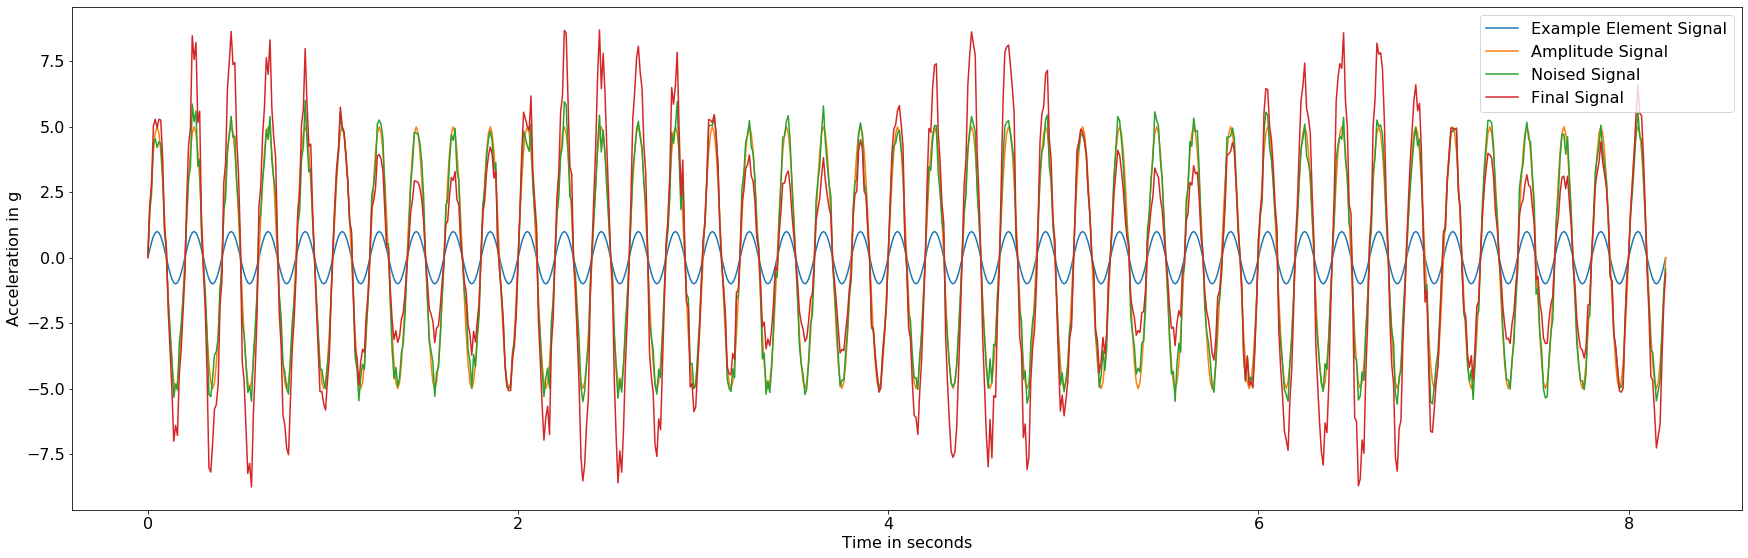

In [48]:
final_signal = noised_signal * torque_4.reshape(-1)

plt.plot(time_vector, element_signal, time_vector, amplitude_signal, time_vector, noised_signal, time_vector, final_signal)
plt.xlabel('Time in seconds'), plt.ylabel('Acceleration in g'), plt.legend(['Example Element Signal', 'Amplitude Signal', 'Noised Signal', 'Final Signal'])
plt.show()

<div style="background-color:rgb(0, 190, 255);color:black;padding:0.5em;letter-spacing:0.1em;font-size:1.5em;align=center">
<p><b>Degradation Element Definition</b></p>
</div>
<br>
<h3>Gear Element</h3>
<p>Keyword Attributes: <br>
<ol>
    <li>Failing Teeth: Number of teeth failing at given Gear</li>
    <li>Chances: Various chances influencing the teeth failing order</li>
    <li>PDF_Deg_Init: PDF for pitting_size and load_cycles @ pitting initialization</li>
    <li>PDF_Deg_EOL: PDF for pitting_size and load_cycles @ pitting end of life</li>
    <li>Woehler: Woehler Definition</li>
    <li>GridSearch: Slices for exp.-function Parameters to be determined in Gridsearch</li>
</ol>
</p>


In [49]:
Deg_Gear = {'Failing_Teeth': 2,                                      # Number of Teeth falling at Gear
            'Chances': {'neighbouring': 1,                           # Chance that multiple falling teeth are neighbouring 
                        'opposite': 1,                               # Chance that multiple falling teeth are opposite to each other 
                        'keeporder': 10},                            # Chance that multiple falling teeth are keeping order from init to eol
            'PDF_Deg_Init': {'n': norm(loc=6.875e6, scale=1.053e6),  # P(n_0)
                             'a': norm(loc=0.450, scale=0.305)},     # P(a_0)
            'PDF_Deg_EOL': {'n': norm(loc=10390000, scale=1.053e6),  # P(n_eol)
                            'a': norm(loc=4.0, scale=0.)},           # P(a_eol)
            'Woehler': {'k': 8.5,                                   # Woehler Exponent 
                        'np': 10390000,                              # Woehler Reference n
                        'torqp': 200},                               # Woehler Reference sigma in Nm
            'GridSearch': {'slice_theta1': (0.0001, 0.0902, 0.01),   # Grid for function a = theta1 * exp(theta2 * n) + theta3 defined in slices
                           'slice_theta2': (0.10/1e6, 1.51/1e6, 0.2/1e6), #tbd change step to 0.02/1e6
                           'slice_theta3':(-2.0, 0.5, 0.1)}
           }


<h3>Bearing Element</h3>
<p>Keyword Attributes: <br>
<ol>
    <li>TBD</li>
</ol>
</p>


<div style="background-color:rgb(0, 190, 255);color:black;padding:0.5em;letter-spacing:0.1em;font-size:1.5em;align=center">
<p><b>Degradation Methods</b></p>
</div>
<br>


<p>Module Methods Structure:</p>

<img src="__pictures/Degradation_Method.png" width="100%">




<p>Load the Gear Degradation Module for demonstration purposes</p>

In [50]:
# os.chdir()
os.chdir(hd)
from gearbox.degradation.gear import Gear_Degradation
os.chdir(wd)

<h3>Chances</h3>
<br>

<p>Chances are descriping <u>how many times more likely</u> it is that an event occurs compared to the event dont occure</p>
<p>Events:</p>
<li>neighbouring: The next failing tooth is a neighbour of an already fallen one</li>
<li>opposite: The next failing tooth is opposite of an already fallen one</li>
<li>keeporder: The teeth are keeping the same order in initialization and end of life (first tooth with initialization is also the first reachning end of life</li>


<p>Random Pitting Initialization</p>

In [51]:
Deg_Gear['Chances'] = {'neighbouring': 1, 'opposite': 1, 'keeporder': 1}  
deg_model = Gear_Degradation(17, Deg_Gear, 1)
deg_model.get_initial_values()

deg_model.state0.head()

a0            n0  tooth          neol  aeol
0  0.122745  5.716048e+06     13  1.130127e+07   4.0
1  0.895943  5.889635e+06     17  7.966480e+06   4.0
2  0.945425  5.950615e+06      8  9.833835e+06   4.0
3  0.397409  5.984998e+06      4  9.985591e+06   4.0
4  0.332863  6.146681e+06     11  8.220672e+06   4.0

<p>Visualization of Pitting Size at Initialization</p>

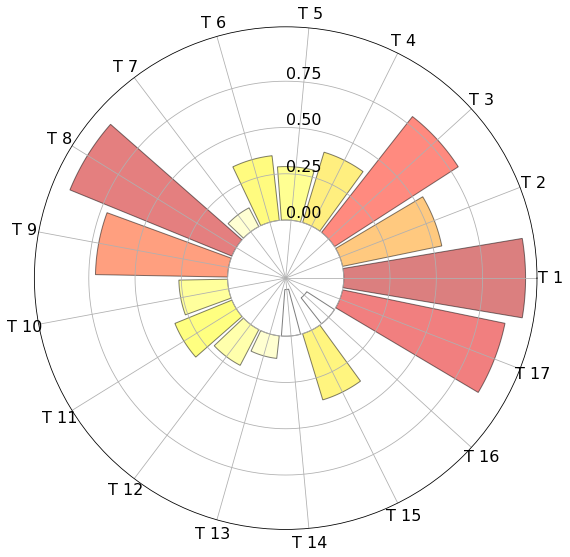

In [52]:
gf.plot_gear_polar(deg_model.state0, kind='pitting', key='a0')


<p>Pitting Order Visualization</p>

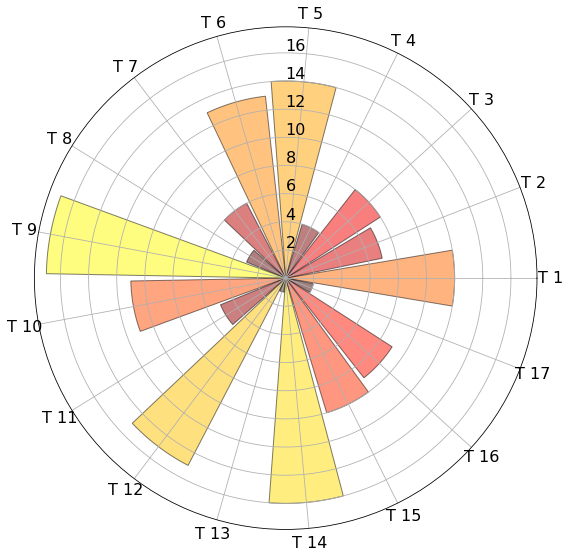

In [53]:
gf.plot_gear_polar(deg_model.state0, kind='order')


<p>Neighbouring favoured Pitting Initialization</p>

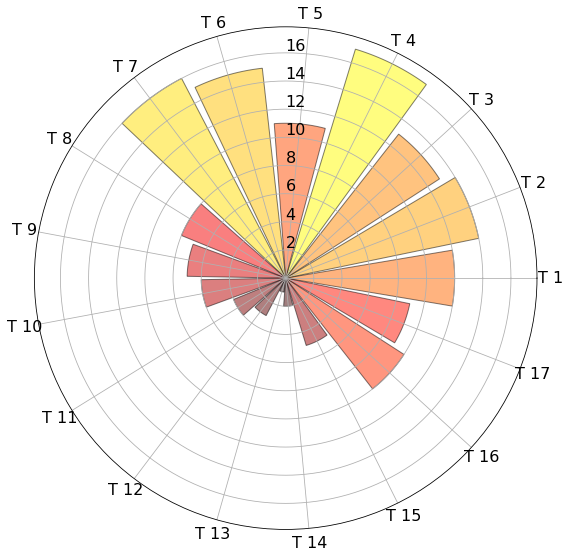

In [54]:
Deg_Gear['Chances'] = {'neighbouring': 100, 'opposite': 1, 'keeporder': 1}  
deg_model = Gear_Degradation(17, Deg_Gear, 1)
deg_model.get_initial_values()
gf.plot_gear_polar(deg_model.state0, kind='order')

<p>Opposite favoured Pitting Initialization</p>

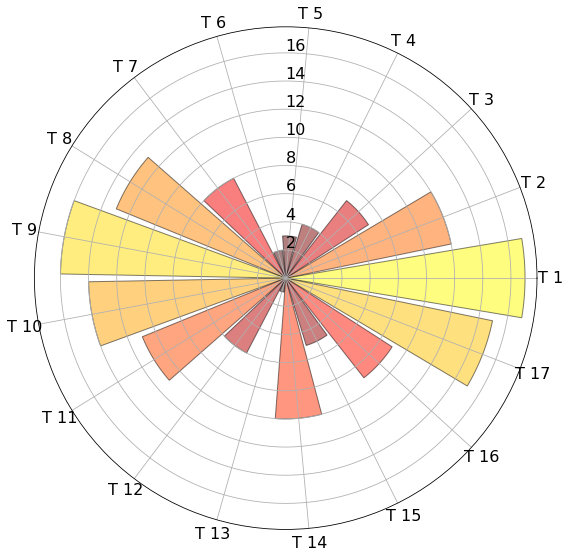

In [55]:
Deg_Gear['Chances'] = {'neighbouring': 1, 'opposite': 100, 'keeporder': 1}  
deg_model = Gear_Degradation(17, Deg_Gear, 1)
deg_model.get_initial_values()
gf.plot_gear_polar(deg_model.state0, kind='order')

<p>Neighbouring and Opposite favoured Pitting Initialization</p>

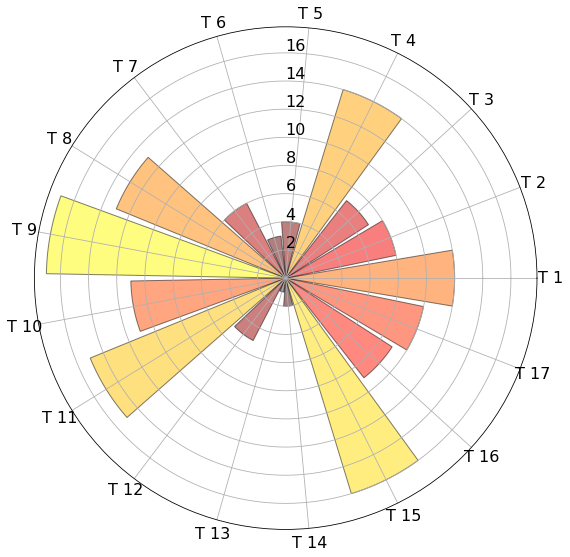

In [56]:
Deg_Gear['Chances'] = {'neighbouring': 100, 'opposite': 100, 'keeporder': 1}  
deg_model = Gear_Degradation(17, Deg_Gear, 1)
deg_model.get_initial_values()
gf.plot_gear_polar(deg_model.state0, kind='order')

<p>Keeporder favoured Initialization</p>

In [57]:
Deg_Gear['Chances'] = {'neighbouring': 1, 'opposite': 1, 'keeporder': 100}  
deg_model = Gear_Degradation(17, Deg_Gear, 1)
deg_model.get_initial_values()

deg_model.state0.head()

a0            n0  tooth          neol  aeol
0  0.122745  5.716048e+06     13  7.966480e+06   4.0
1  0.895943  5.889635e+06     17  8.220672e+06   4.0
2  0.945425  5.950615e+06      8  9.231814e+06   4.0
3  0.397409  5.984998e+06      4  9.260164e+06   4.0
4  0.332863  6.146681e+06     11  1.222729e+07   4.0

<h3>PDF Degradation</h3>
<br>

<p>Probability Density Function for Degradation <u>Initialization</u></p>
<li>n: Initialization Load Cycle PDF - P(n<sub>0</sub>)</li>
<li>a: Initialization Pitting Size PDF - P(a<sub>0</sub>)</li>

<p>Probability Density Function for Degradation <u>End of Life</u></p>
<li>n: EOL Load Cycle PDF - P(n<sub>eol</sub>)</li>
<li>a: EOL Pitting Size PDF - P(a<sub>eol</sub>)</li>

<p> PDF can be defined as any continuous distribution function available on <a href="https://docs.scipy.org/doc/scipy/reference/stats.html">'Scipy Stats'</a></p>
<p><b>PDFs are valid for a reference torque, defined by woehler</b></p>


<p>P(n<sub>0</sub>) and P(n<sub>eol</sub>)</p>

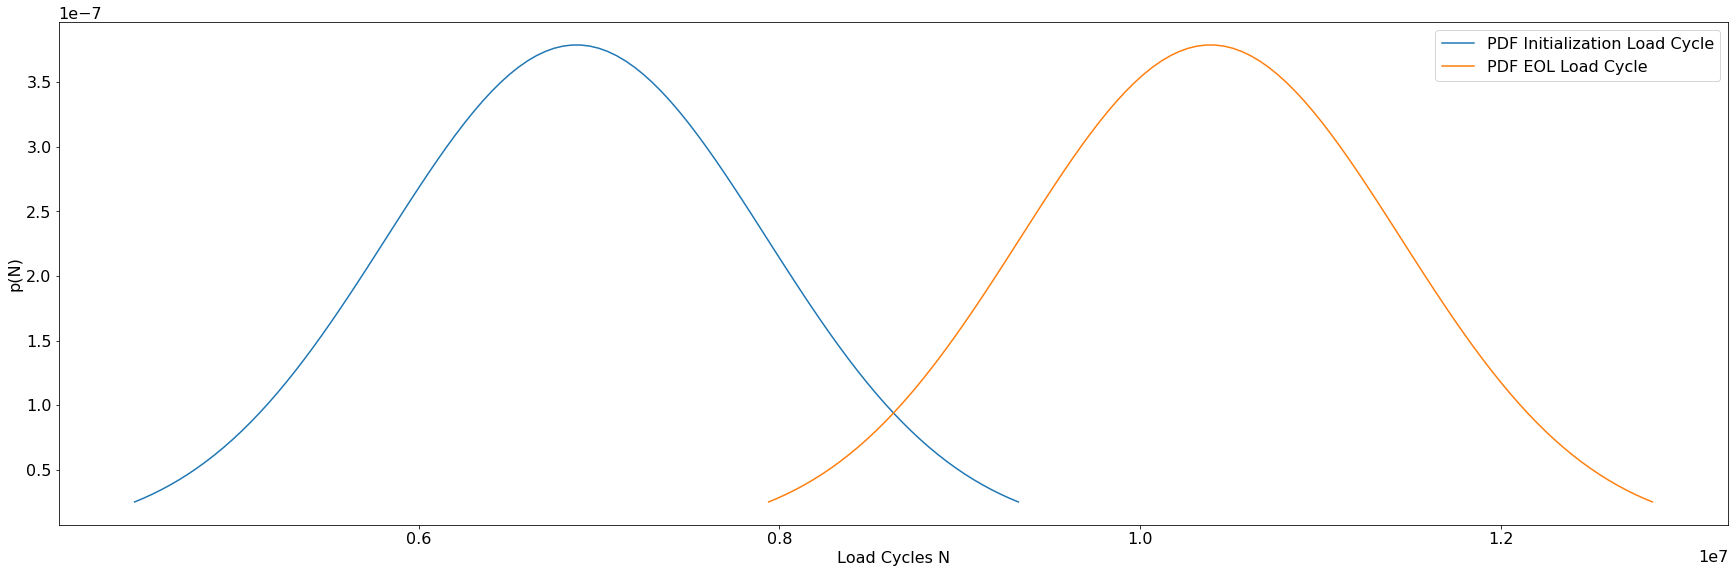

In [58]:
P_n0, P_neol= norm(loc=6.875e6, scale=1.053e6), norm(loc=10390000, scale=1.053e6)
n0, neol = np.linspace(P_n0.ppf(0.01), P_n0.ppf(0.99), 100), np.linspace(P_neol.ppf(0.01), P_neol.ppf(0.99), 100)

plt.plot(n0, P_n0.pdf(n0), neol, P_neol.pdf(neol))
plt.xlabel('Load Cycles N'), plt.ylabel('p(N)'), plt.legend(['PDF Initialization Load Cycle', 'PDF EOL Load Cycle'])
plt.show()

<p>P(a<sub>0</sub>) and P(a<sub>eol</sub>)</p>

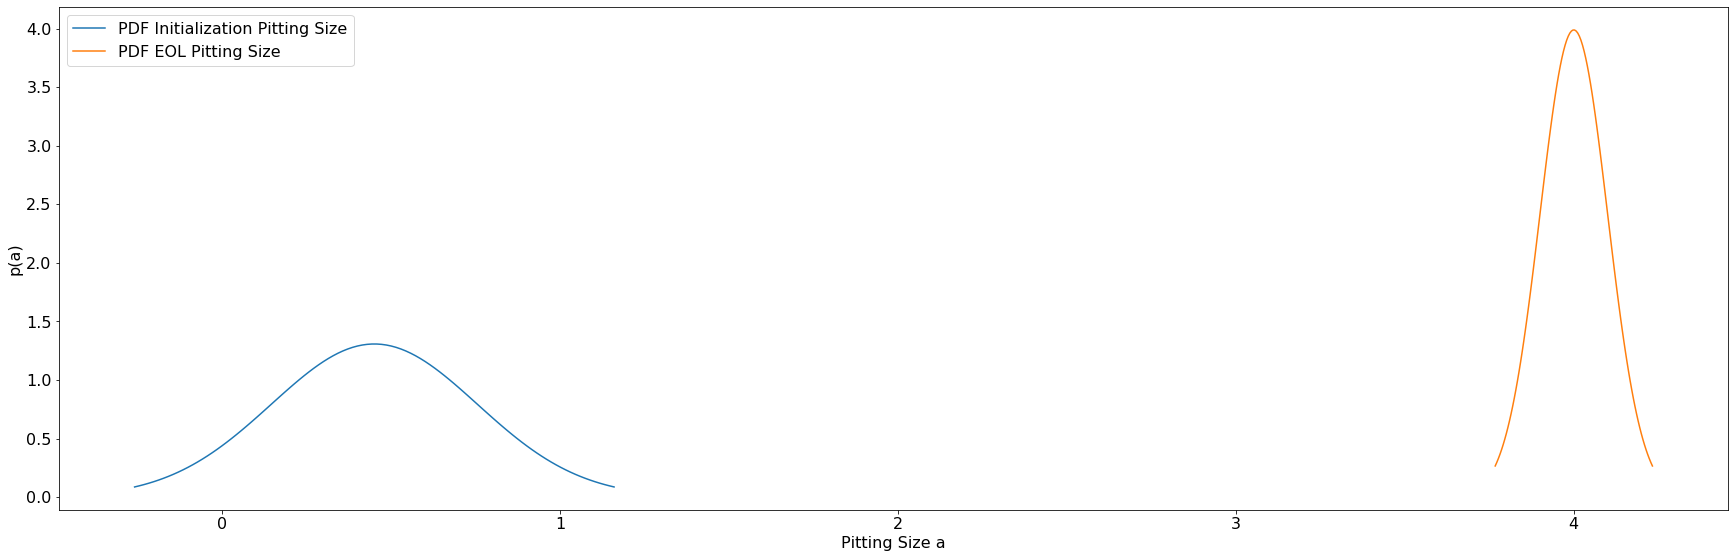

In [59]:
P_a0, P_aeol= norm(loc=0.450, scale=0.305), norm(loc=4.0, scale=0.1)
a0, aeol = np.linspace(P_a0.ppf(0.01), P_a0.ppf(0.99), 100), np.linspace(P_aeol.ppf(0.01), P_aeol.ppf(0.99), 100)

plt.plot(a0, P_a0.pdf(a0), aeol, P_aeol.pdf(aeol))
plt.xlabel('Pitting Size a'), plt.ylabel('p(a)'), plt.legend(['PDF Initialization Pitting Size', 'PDF EOL Pitting Size'])
plt.show()

<h3>Woehler Curve</h3>
<br>

<p>Definition of Woehler Curve for EOL</p>
<li>k: Woehler exponent (measure for gradien)</li>
<li>np: Reference Load Cycle on Woehler Curve - pair (np, torquep)</li>
<li>torquep: Reference Torque on Woehler Curve - pair (np, torquep)</li>


<p>The definition of the reference points (np, torquep) also determines the probability of failure Px for which the Woehler line applies.</p>




<p>Woehler Curve Plot</p>

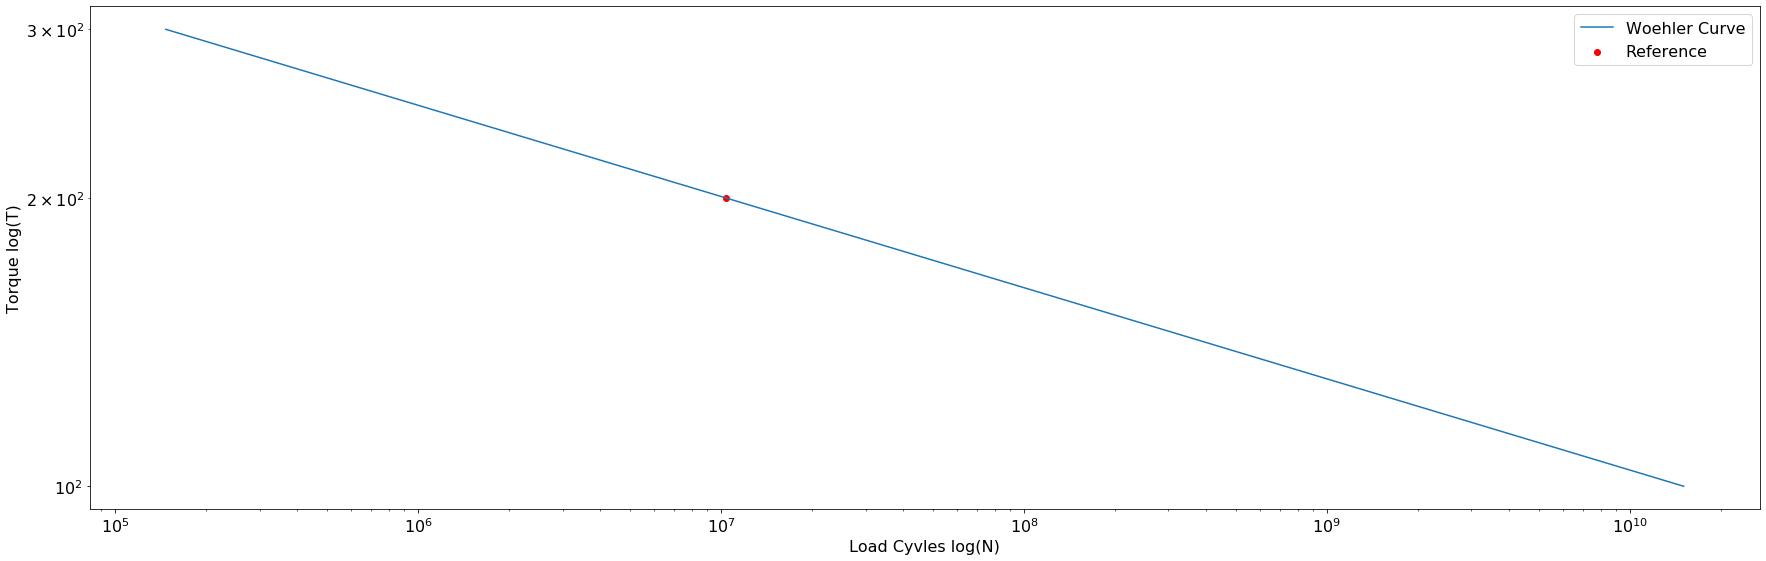

In [60]:
k, n_p, torq_p = 10.5, 10390000., 200.
torq = np.linspace(torq_p*0.5, torq_p*1.5, 10)
N = n_p * np.power((torq / torq_p), -1*k)

plt.plot(N, torq), plt.scatter(n_p, torq_p, c='r')
plt.xscale('log'), plt.yscale('log'), plt.xlabel('Load Cyvles log(N)'), plt.ylabel('Torque log(T)'), plt.legend(['Woehler Curve', 'Reference'])
plt.show()

<h3>GridSearch</h3>
<br>

<p>Definition of <u>Slices</u> for Exponential Function Parameters &theta;</p>
<li>Function: a = &theta;<sub>1</sub> * exp(&theta;<sub>2</sub> * n) + &theta;<sub>3</sub></li>
<li>Two points Given: (a<sub>0</sub>, n<sub>0</sub>) and (a<sub>eol</sub>, n<sub>eol</sub>)</li>
<li>GridSearch for best fit</li>
<li>Only failing teeth</li>

<p>The definition of the reference points (np, torquep) also determines the probability of failure Px for which the Woehler line applies.</p>



In [61]:
Deg_Gear['GridSearch'] = {'slice_theta1': (0.0001, 0.0902, 0.01),
                          'slice_theta2': (0.10/1e6, 1.51/1e6, 0.2/1e6),
                          'slice_theta3':(-2.0, 0.5, 0.1)}


<div style="background-color:rgb(0, 190, 255);color:black;padding:0.5em;letter-spacing:0.1em;font-size:1.5em;align=center">
<p><b>Degradation Theory</b></p>
</div>
<br>

<li>How Degradation Simulation Works</li>
<li>Running Example for one tooth</li>


<h3>1. Define Degradation Dictionary</h3>


In [62]:
Deg_Gear = {'Failing_Teeth': 2,                                      # Number of Teeth falling at Gear
            'Chances': {'neighbouring': 1,                           # Chance that multiple falling teeth are neighbouring 
                        'opposite': 10,                               # Chance that multiple falling teeth are opposite to each other 
                        'keeporder': 1},                            # Chance that multiple falling teeth are keeping order from init to eol
            'PDF_Deg_Init': {'n': norm(loc=6.875e6, scale=1.053e6),  # P(n_0)
                             'a': norm(loc=0.450, scale=0.305)},     # P(a_0)
            'PDF_Deg_EOL': {'n': norm(loc=10390000, scale=1.053e6),  # P(n_eol)
                            'a': norm(loc=4.0, scale=0.)},           # P(a_eol)
            'Woehler': {'k': 8.5,                                   # Woehler Exponent 
                        'np': 10390000,                              # Woehler Reference n
                        'torqp': 200},                               # Woehler Reference sigma in Nm
            'GridSearch': {'slice_theta1': (0.00, 0.09, 0.01),   # Grid for function a = theta1 * exp(theta2 * n) + theta3 defined in slices
                           'slice_theta2': (0.30/1e6, 0.61/1e6, 0.005/1e6), #tbd change step to 0.02/1e6
                           'slice_theta3':(-.1, 0.4, 0.01)}
           }
no_teeth = 10
seed = 4

<h3>2. Draw (tooth, a<sub>0</sub>, n<sub>0</sub>, a<sub>eol</sub>, n<sub>eol</sub>) Pairs for all teeth considering chances</h3>

In [63]:
deg_model = Gear_Degradation(no_teeth, Deg_Gear, seed)
deg_model.get_initial_values()

deg_model.state0.head()

a0            n0  tooth          neol  aeol
0  0.322418  5.656872e+06      6  1.102030e+07   4.0
1  0.252449  6.235948e+06      1  9.181707e+06   4.0
2  0.602485  6.782350e+06      8  8.721440e+06   4.0
3  0.100020  6.923581e+06      3  1.044324e+07   4.0
4  0.661548  7.224863e+06      2  9.707965e+06   4.0

<h3>3. GridSearch for all failing teeth to get individual degradation function</h3>
<br>
<li>If Failing_Teeth is n --> First n teeth are considered</li>
<li>!! Value Pairs will be adjusted to fit on Degradation Function !!</li>

In [64]:
deg_model = Gear_Degradation(no_teeth, Deg_Gear, seed)
deg_model.init_gear_degradation()

1.0   2.0   3.0   4.0   5.0       6.0   7.0   8.0   9.0   10.0
$a_{0}$       NaN   NaN   NaN   NaN   NaN       NaN   NaN   NaN   NaN   NaN
$d_{0}$ -0.944191   NaN   NaN   NaN   NaN -1.028415   NaN   NaN   NaN   NaN

<p>Results:</p>

In [65]:
deg_model.state0

a0            n0  tooth          neol  aeol  theta1        theta2  \
0  0.322418  5.588442e+06      6  1.102248e+07   4.0    0.02  4.800000e-07   
1  0.252449  4.477089e+06      1  9.218807e+06   4.0    0.02  5.750000e-07   

   theta3        n0_old      neol_old  
0    0.03  5.656872e+06  1.102030e+07  
1   -0.01  6.235948e+06  9.181707e+06

<p>Gear Visualization:</p>

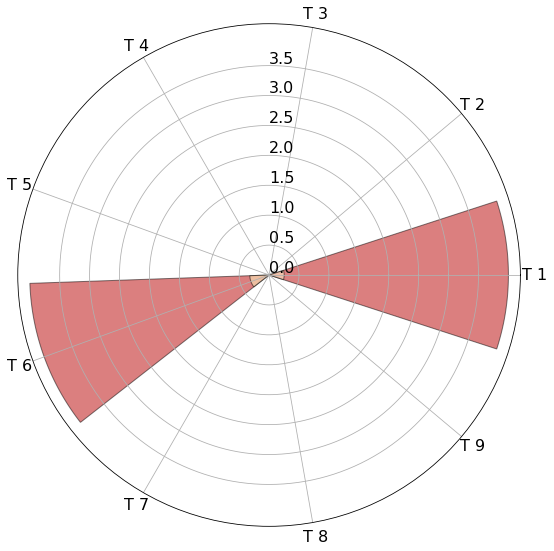

In [66]:
gf.plot_gear_polar(deg_model.state0, kind='pitting_growth', no_teeth=no_teeth, key1='a0', key2='aeol')

<p>Degradation Function Visualization:</p>

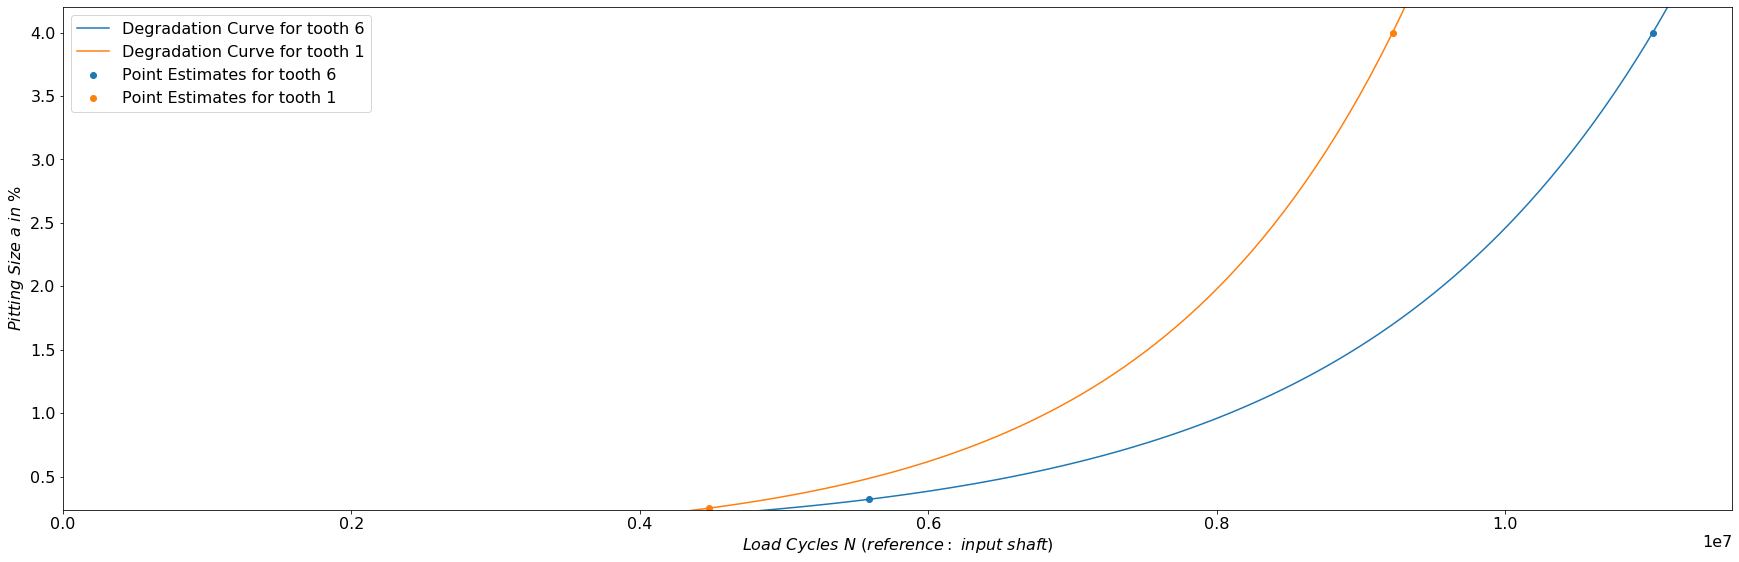

In [67]:
deg_model.plot_state0()

<h3>4. Transform Degradation to Damage D</h3>
<br>
<li>Under constant torque load degradation starts at n<sub>0</sub> and ends at n<sub>eol</sub> </li>
<li>D(n<sub>0</sub>) = 0</li>
<li>D(n<sub>eol</sub>) = 1</li>
<li>Assumption: Linear Damage Accumulation</li>

<p>Draw D(n<sub>0</sub>) = 0 and D(n<sub>eol</sub>) = 1</p>

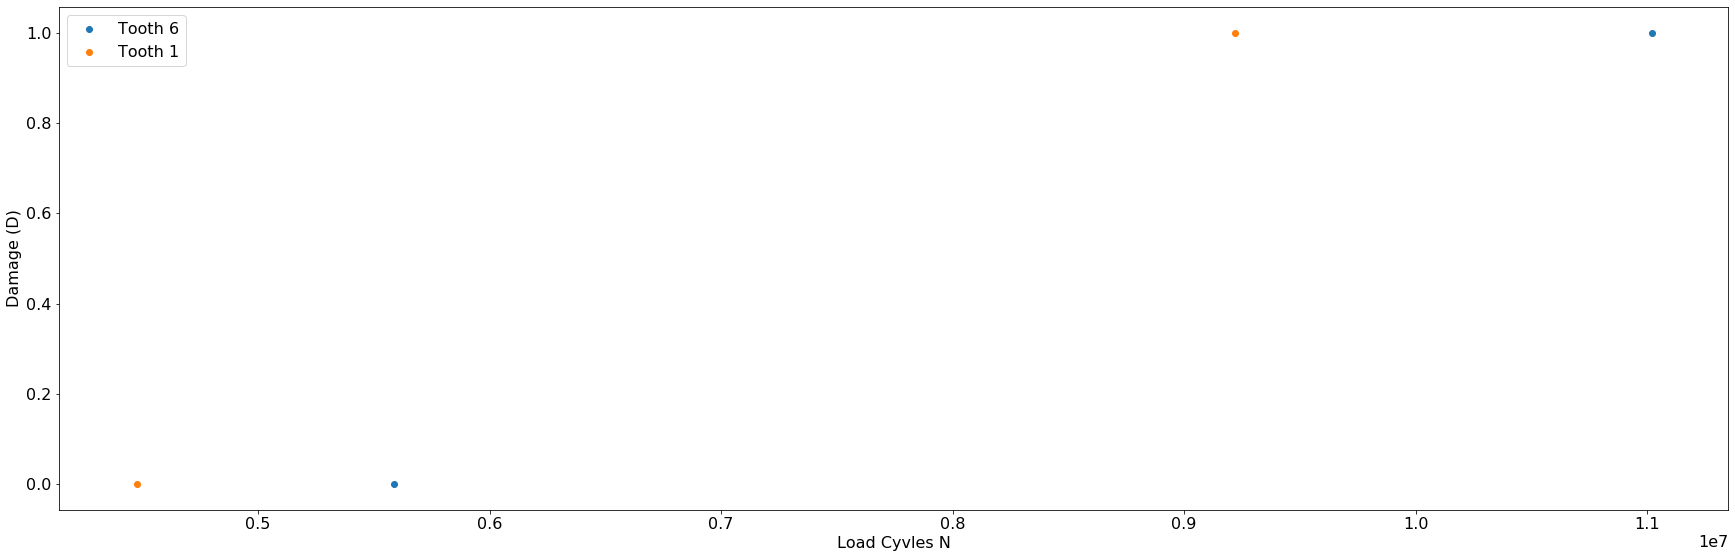

In [68]:
fig = plt.figure()
legend = []
for i, row in deg_model.state0.iterrows():
    plt.scatter([row['n0'], row['neol']], [0, 1])
    legend.append('Tooth %i' % (row['tooth']))
plt.xlabel('Load Cyvles N'), plt.ylabel('Damage (D)'), plt.legend(legend)
plt.show()

<p>Get Linear Damage over Load Cycle Dependency</p>

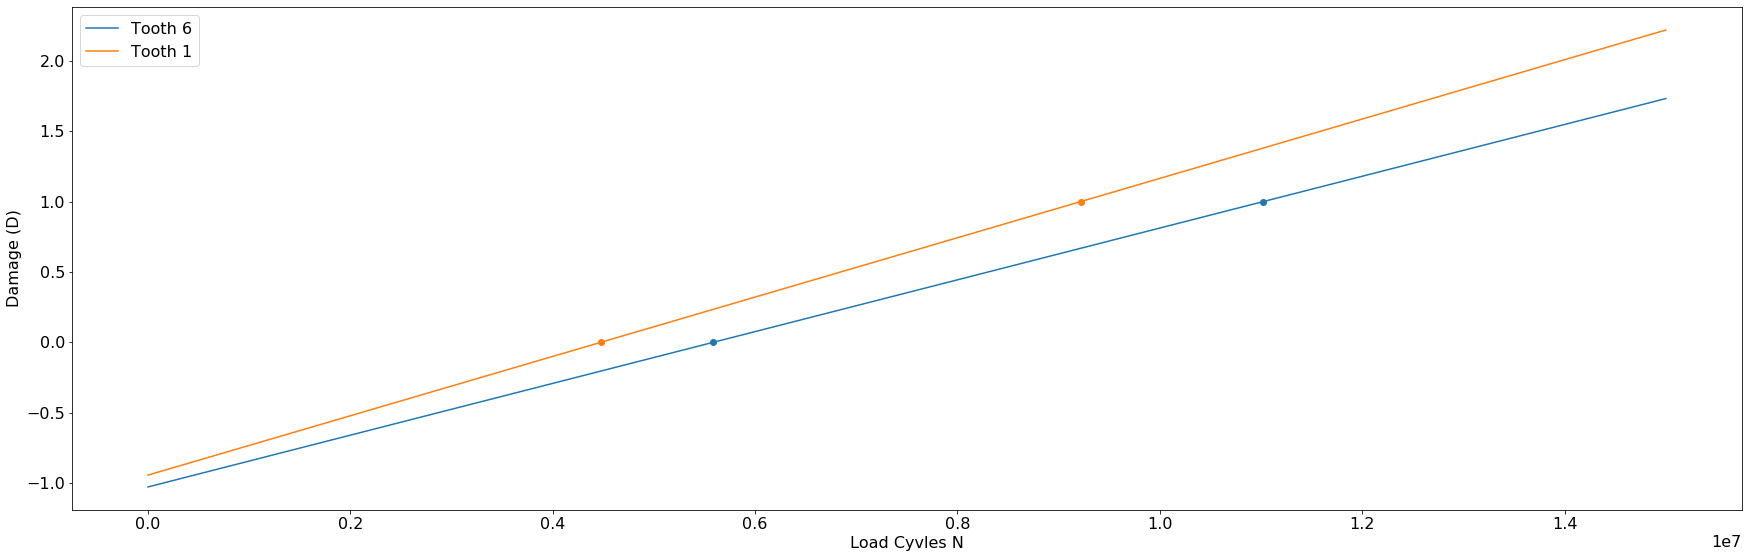

In [69]:
N = np.linspace(0, 1.5e7, 10)
for i, row in deg_model.state0.iterrows():
    m = (1)/(row['neol'] - row['n0'])
    b = 0 - m * row['n0']
    plt.scatter([row['n0'], row['neol']], [0, 1])
    plt.plot(N, (m * N + b))
plt.xlabel('Load Cyvles N'), plt.ylabel('Damage (D)'), plt.legend(legend)
plt.show()

<h3>5. Pitting Size and Damage Dependency</h3>
<br>
<li>Both Pitting Size a and Damage D are a function of Load Cycles N, so it follows:</li>
<li>D(a<sub>0</sub>) = 0</li>
<li>D(a<sub>eol</sub>) = 1</li>
<li>In General: a(D(N)) = a<sub>d</sub></li>

<h3>6. Defining State0</h3>
<br>
<li>Assumption: Linear Damage Accumulation</li>
<li>All values are valid for the reference load (torque) given in woehler curve definition</li>
<li>At State0 (Initialization) the following is known:</li>
<ul>
    <li>Degradation Function: a(N) = a<sub>N</sub></li>
    <li>Damage Function: D(N) = d<sub>N</sub></li>
    <li>Damage Pitting Dependencie: a(D(N)) = a<sub>d</sub></li>
</ul>

<p>Values @ State0</p>

In [70]:
print('Load Cycle:                 %i' % (deg_model.nolc[0]))
print('Failing teeth:              %s' % ('|'.join(['   %i   ' % (tooth) for tooth in deg_model.state0['tooth']])))
print('Corresponding Damage:       %s' % ('|'.join(['%.4f' % (damage) for damage in deg_model.damage[-1]])))
print('Corresponding Pitting Size: %s' % ('|'.join(['  %.4f  ' % (ps) if np.isnan(ps) else '%.4f' % (ps) for ps in deg_model.pitting_size[-1]])))

Load Cycle:                 0
Failing teeth:                 6   |   1   
Corresponding Damage:       -1.0284|-0.9442
Corresponding Pitting Size:   nan  |  nan  


<h3>7. Calculating &Delta;D </h3>
<br>
<li>Given:</li>
<ul>
    <li>List of loads applied on tooth i</li>
    <li>Load Cycles n<sub>p</sub> and n<sub>p-1</sub></li>
    <li>Previous Damage D<sub>p-1, i</sub> </li>
</ul>
<li>Searched:</li>
<ul>
    <li>&Delta;D = D(n<sub>p</sub> - n<sub>p-1</sub>)</li>
    <li>Current Damage D<sub>p, i</sub> </li>
</ul>
<p><b>&Delta;D will be computed for all full Load Cycles (e.g. considering gear_ratio for output gear -> 10,5 Load Cycles will be considered as 10 Load Cycles)</b></p>

<p>Definition of Given</p>

In [71]:
loads = [195, 200, 205]
curr_cycle = 73

<p>From State0</p>

In [72]:
idx = 0 # Tooth ID
prev_cycle = deg_model.nolc[-1]
tooth_i = deg_model.state0['tooth'].to_list()[idx]
prev_damage = deg_model.damage[-1][idx]
prev_pitting = deg_model.pitting_size[-1][idx]
n0, neol = deg_model.state0['n0'][idx], deg_model.state0['neol'][idx]
T1, k = Deg_Gear['Woehler']['torqp'], Deg_Gear['Woehler']['k']

<p>Define Woehler for Damage tooth_i</p>

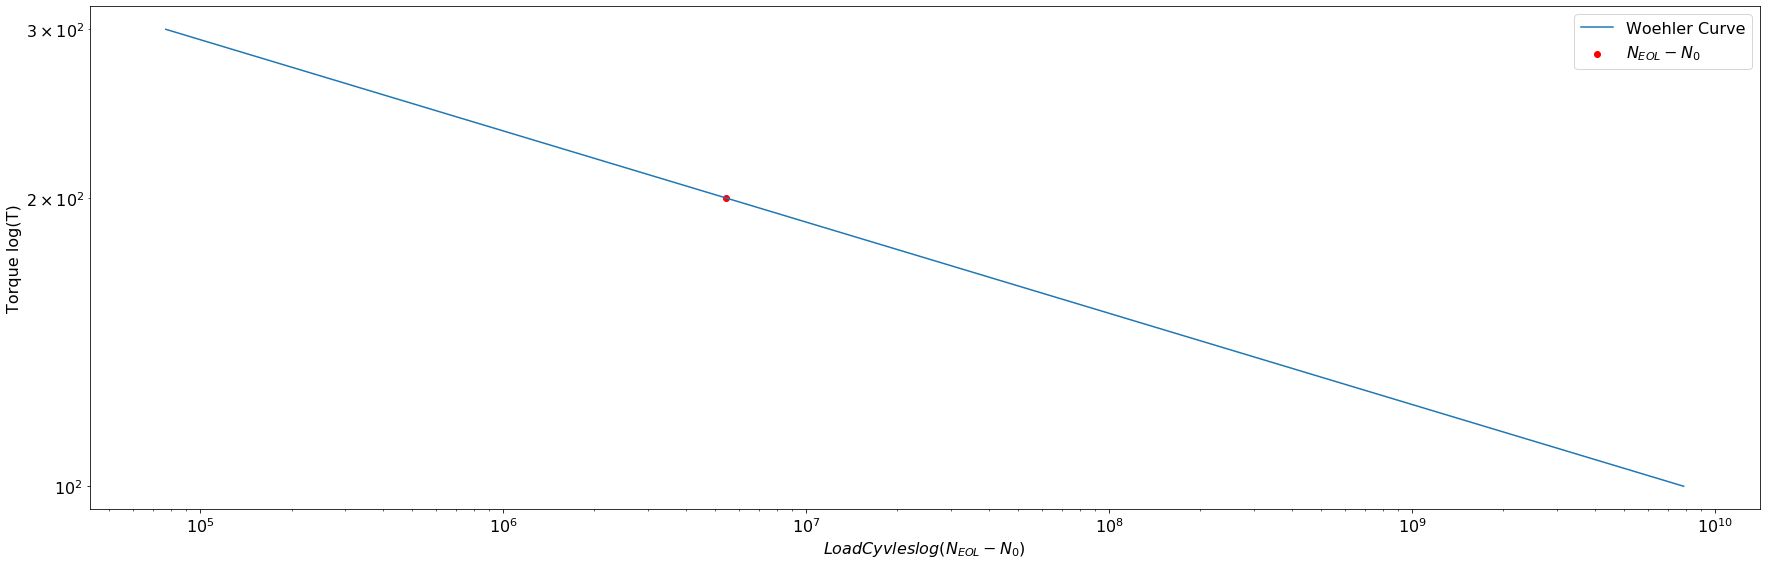

In [73]:
N1 = neol - n0
torq = np.linspace(T1*0.5, T1*1.5, 10)
N = N1 * np.power((torq / T1), -1*k)

plt.plot(N, torq), plt.scatter(N1, T1, c='r')
plt.xscale('log'), plt.yscale('log'), plt.xlabel('$Load Cyvles log(N_{EOL}-N_0)$'), plt.ylabel('Torque log(T)'), plt.legend(['Woehler Curve', '$N_{EOL} - N_{0}$'])
plt.show()

<p>Get Damage Equivalent D* for all loads</p>

In [74]:
damage_equivalents = []
for load in loads:
    N2 = N1 * np.power((load / T1), -1*k)
    damage = 1/N2
    damage_equivalents.append(damage)
print('Loads:  %s' % ('|'.join(['  %.3f  ' % (load) for load in loads])))
print('D\'s:    %s' % ('|'.join([' %.3e ' % (de) for de in damage_equivalents])))

Loads:    195.000  |  200.000  |  205.000  
D's:     1.411e-07 | 1.840e-07 | 2.385e-07 


<p>Repeat Damage Equivalent D* for &Delta;N load cycle</p>

In [75]:
delta_n = int(np.floor(curr_cycle - prev_cycle))
repeated_damage_equivalent = gf.repeat2no_values(np.array(damage_equivalents), delta_n)

print('\u0394N = %i' % (delta_n))
print('D* Shape: %s' % (str(repeated_damage_equivalent.shape)))

ΔN = 73
D* Shape: (73,)


<p>Calculate &Delta;D = &Sum;D*</p>

In [76]:
delta_d = np.sum(repeated_damage_equivalent)
print('\u0394D = \u2211 D* = %.3e for \u0394N = %i load cycles' % (delta_d, delta_n))

ΔD = ∑ D* = 1.367e-05 for ΔN = 73 load cycles


<h3>8. Calculating current D </h3>
<br>
<p>D<sub>p</sub> = D<sub>p-1</sub> + &Delta;D</p>

In [77]:
curr_damage = prev_damage + delta_d
print('D(p) = D(p-1) + \u0394D = %.3e' % (curr_damage))

D(p) = D(p-1) + ΔD = -1.028e+00


<h3>9. Calculating a<sub>p</sub> </h3>
<br>
<p>Using: Damage Pitting Dependencie: a(D(N))</p>
<ul>
    <li>a(D(N)) is given for each tooth</li>
</ul>


<div style="background-color:rgb(0, 190, 255);color:black;padding:0.5em;letter-spacing:0.1em;font-size:1.5em;align=center">
<p><b>Degradation-Vibration Dependency Element Definition</b></p>
</div>
<br>
<p>Module Methods Connection Vibration and Degradtion:</p>
<li>Getting Loads from Torque Signal for Gear Degradation</li>
<li>Translating Pitting Size into Vibration</li>


<h3>Gear Element</h3>
<p>Keyword Attributes: <br>
<ol>
    <li>signal: <a href="NonstationarySignals">Nonstationary Signals</a><br></li>
    <li>fc_factor: <a href="NonstationarySignals">Nonstationary Signals</a><br></li>
    <li>bw_factor: <a href="NonstationarySignals">Nonstationary Signals</a><br></li>
    <li>bwr_factor: <a href="NonstationarySignals">Nonstationary Signals</a><br></li>
    <li>scale_method: <a href="AmplitudeMethod">Scale Method to scale Amplitude based on pitting size(see Torque Influence Method as reference)</a><br></li>
    <li>scale_attributes: <a href="AmplitudeMethod">Attributes regarding Scale Method to (see Torque Influence Attributes as reference)</a><br></li>
    <li>torq_influence:  <a href="TorqueMethod">If True Torque Influence will be taken into account in the same way as in vibration definition</a><br></li>
    <li>noise_method:  <a href="AmplitudeMethod">Method to create Signal Noise (repeat methods are not working)</a><br></li>
    <li>noise_attributes: <a href="AmplitudeMethod">Attributes regarding the Method to create Signal Noise</a><br></li>
    <li>t2t_factor: <a href="">If 1 loads are calculated without any overlap between two tooh and all loads are considered. If t2t_factor > 1 there is a overlap of loads considered for each tooth </a><br></li>
</ol>
</p>

In [78]:
GearDegVibDict = {'signal': 'gausspulse',                                # Signal type for gear
                   'fc_factor': 2*rotational_frequency_in,                                      # fc = frequency * fc_factor (see gauspulse defintion)
                   'bw_factor': 0.5,                                    # see gauspulse defintion
                   'bwr_factor': -6,                                    # see gauspulse defintion
                   'scale_method': 'linear',                            # Scale Method (See Torque Influence Method)
                   'scale_attributes': {'scale_min': 0,                 # Attributes regarding Scale Method for gear signal (see Torque Influence Method)
                                       'scale_max': 1,
                                       'value_min': 0,
                                       'value_max': 4,
                                       'exponent': 2},
                   'torq_influence': True,                              # If True Torque Influence will be taken into account in the same way as in vibration definition
                   'noise_method': 'gaussian',                          # Noise Method
                   'noise_attributes': {'mu': 0, 'sigma': 0.005},       # Attributes regarding Noise Method for
                   't2t_factor': 1
                   }